In [ ]:
import os
import shutil
import random

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms, datasets
import imgaug.augmenters as iaa
import imgaug
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import glob
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import copy
from tqdm import tqdm

/home/student/miniconda3/envs/hw2_env_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Analysis and Visualization - Task 2

In the second task of the course Data Analysis and Visualization we try to optimize a given model performance only by changing the given dataset. The basic dataset is a dataset of hand written roman numerals and each image is labeled with the numeral written in it. The given model will classify these images and we will try to improve its performance by training it on a better dataset.

We are also given a training procedure which trains the model which is a ResNet50 - a Convolutional Neural Network. The final product of our work will be the edited dataset.

In addition, we have the following limitation- the new dataset can not contain more than 10,000 images (for both training and validation of the model)

### Github repository link:
https://github.com/Zilber-a/hw2_094295

### Chapters
- Data cleaning
- Data exploration
- Creating test and validation sets
- Data augmentation
- Train-Validation Split
- Analyzing Results and Model
- Creating the Final Dataset




# Data cleaning

With the given dataset we had 2078 images (in both train,val). After the manual fixing of some labels and the removal of images the dataset has 1857 images.
We encountered two types of images that needed to be fixed:
1. Images that were not labeled correctly (for example II labeled as I) (their labeled was fixed)
2. Images that don't belong to any of the labels (were removed).


Examples of removed images:

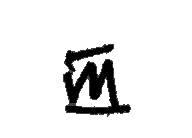

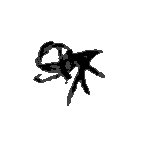

# Data exploration

The availble labels in our dataset are as follows:

In [ ]:
classes = os.listdir('data/train/')
classes.sort()
classes

['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']

A few examples of images from the dataset:

Text(0.5, 1.0, "['iv', 'ii', 'iv', 'iii', 'iv', 'x', 'iv', 'iii', 'viii', 'iv', 'iv', 'iv', 'vii', 'i', 'ix', 'vi']")

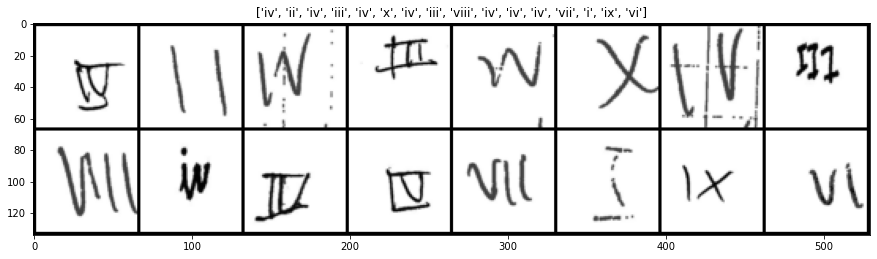

In [ ]:
data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])
train_dataset = datasets.ImageFolder("data/train", data_transforms)
class_names = train_dataset.classes
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)
title = [class_names[x] for x in classes]
out = out.numpy().transpose((1, 2, 0))
plt.figure(figsize=(15, 15))
plt.imshow(out)
plt.title(title)

We first look at the distribution of labels:

In [ ]:
labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
dict_sizes = {}
for label in labels:
    images = os.listdir('data/train/'+label)
    dict_sizes[label] = len(images)
print(dict_sizes)

{'i': 243, 'ii': 153, 'iii': 150, 'iv': 264, 'ix': 214, 'v': 173, 'vi': 162, 'vii': 167, 'viii': 157, 'x': 174}


The data is fairly balanced but the label with the most images ('i' - 243) has 1.62 times more images than the label with the least images ('iii' - 150). Therefore, during the training of the model we will consider changing the distribution. This is mainly due to the fact that we do not have information about the label distribution of the test dataset on which we will be evaluated on, and we did not receive any a-priori information about one of the labels being more important to classify correctly than others. Therefore, we might want to look into balacing the dataset before training the model, in order to give all labels equal weight.

# Creating test and validation sets

In order to evaluate and select our final dataset we create the following:

### Test set

this dataset will be used to evaluate our final model and will allow us to understand its performance on unseen data. We draw the test set once and only use it to test the model trained on the best dataset. In other words, only after we have used other methods to choose the best dataset on which to train the final model, we will check the model's performance on this never seen before dataset, in order to get a sense of approximately what accuracy would our model get on the test set which we will be evaluated on.

### Validation sets

Note that we are using two validation sets, one for each of the following steps (denoted as first and second validation sets):
1. Choice of augmentation method, split size between train and 2nd validation set. This validation set is drawn once, thus we will now sample it, and use it for selection of the above. We select the above by creating multiple datasets- with both validation and train, and then train the ResNet on all of them, and finally check the accuracy of all of them on that validation set. The dataset with the highest validation accuracy will be chosen. That validation set will not be part of the final submitted dataset, as it just assists us in choosing the final dataset.
2. Choice of best ResNet model. This is done in run_train_val.py. That validation set is submitted as part of the final dataset and will be drawn multiple times to try and find the best dataset to be trained on.

We create a test and the first validation set (All images are currenly in data/train):

In [ ]:
# The function creates a dataset from the train set, such that each label appears move_size times.
def move_train(path, from_path="data/train/" , move_size = 25):
    random.seed(10)
    labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
    if not os.path.exists(path):
        os.mkdir(path)
    for label in labels:
        if not os.path.exists(path+'/'+label):
            os.mkdir(path+'/'+label)
    for label in labels:
        images = os.listdir(from_path+label)
        if move_size > 1:
            indicies = random.sample(list(range(len(images))), move_size)
        else:
            indicies = random.sample(list(range(len(images))), int(len(images)*move_size))    
        images_test = [images[i] for i in indicies]
        for image in images_test:
            shutil.move(from_path+label+'/'+image, path+'/'+label+'/'+image)

In [ ]:
# Test set
move_train(path="data/test")
# First validation set
move_train(path="data/validation_first")

# Data augmentation

We will try multiple types of data augmentation (zooming in, rotating...), and because of the slight imbalance we have seen in the dataset we change the distribution to a uniform one - 1000 images per label (in both validation and train).

We will use 20% of the data as validation (later we might find a better proportion). The best data augmentation method will be selected based on accuracy of the produced model based on the first validation set.

In [ ]:
# move train images to new folders, each time use different augmentation on them
move_train(path="data/val_")
move_train(path="data/train_", move_size=1)

We will try using the following augmentations:
- WithBrightnessChannels
- Affine
- ShearX
- PiecewiseAffine
- PerspectiveTransform

We look at few examples of each type of augmentation:

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_examples(aug_seq):
    original = np.array(Image.open('data/train_/iv/adb83398-ce5d-11eb-b317-38f9d35ea60f.png').convert("RGB"))
    originals = [original]*4
    images = [original]
    images += aug_seq(images=originals)
        
    fig = plt.figure(figsize=(30., 30.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

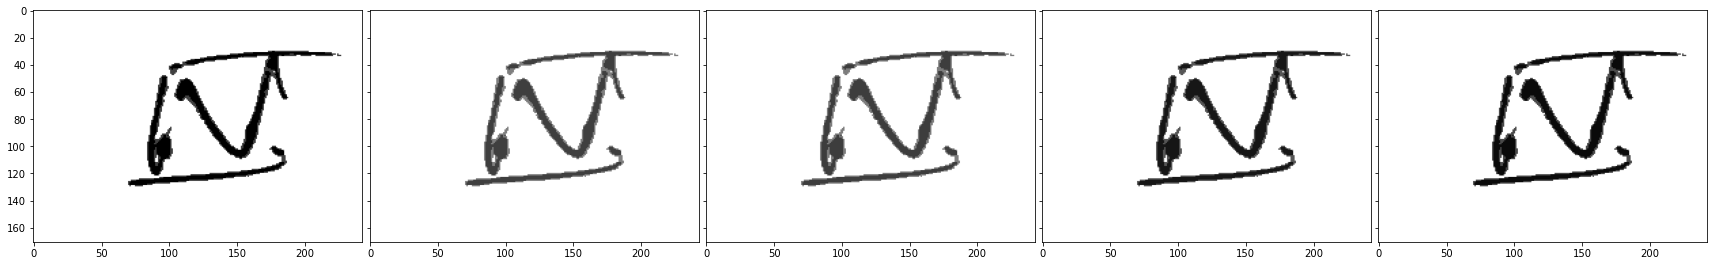

In [ ]:
seq = iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80)))])
show_examples(seq)

This type of augmentation changes the brightness of the image.

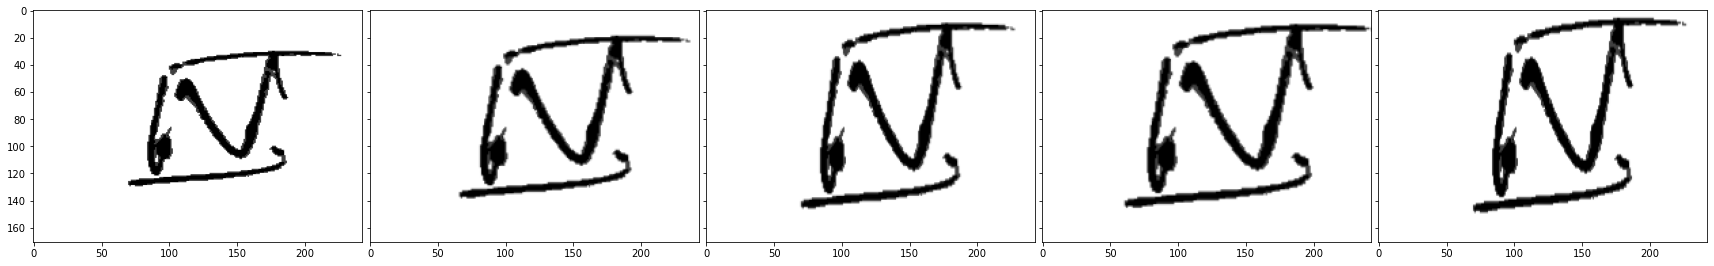

In [ ]:
seq = iaa.Sequential([iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)})])
show_examples(seq)

This type of augmentation stretches the image both on the x and y axis.

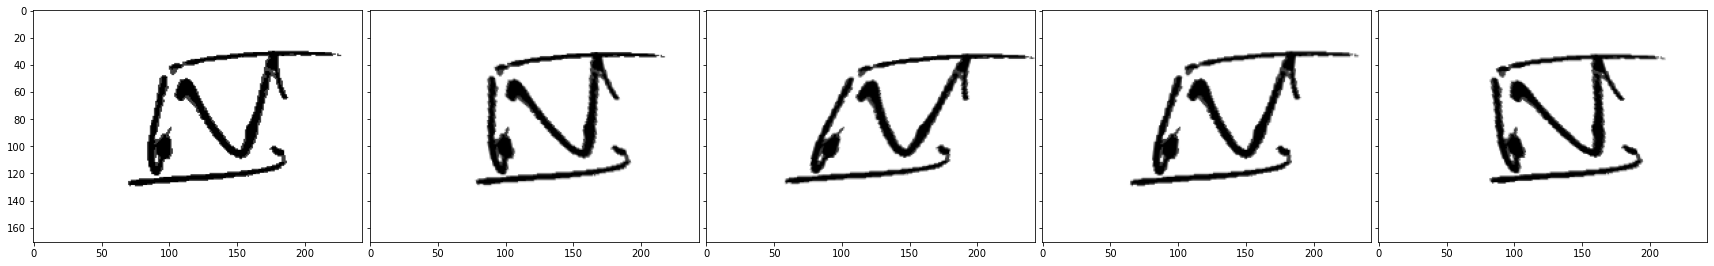

In [ ]:
seq = iaa.Sequential([iaa.ShearX((-15, 15),cval=255)])
show_examples(seq)

This type of augmentation "smears" the image from left to right or vice-versa.

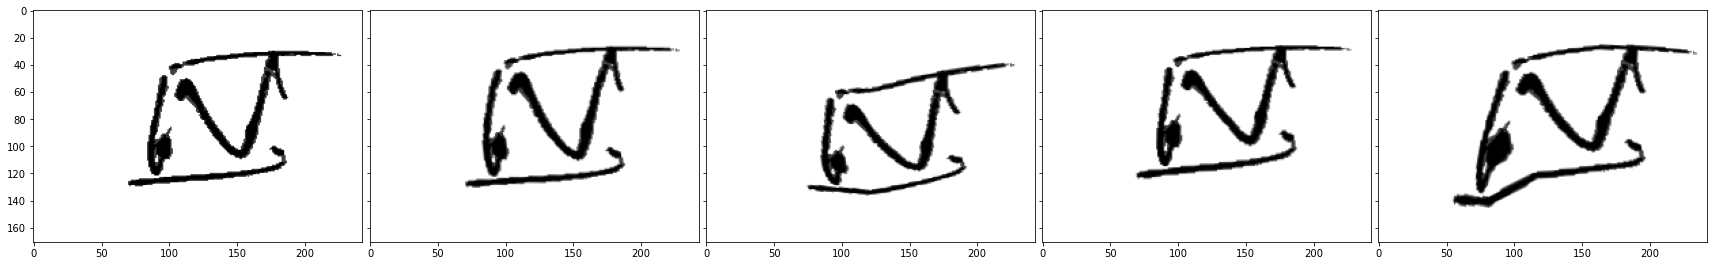

In [ ]:
seq = iaa.Sequential([iaa.PiecewiseAffine(scale=(0.03, 0.05))])
show_examples(seq)

This type of augmentation distorts the image. We have experimented and chose parameters that result in visible changes to the original image, but that still result in a recognizable image that can likely be learned and classified.

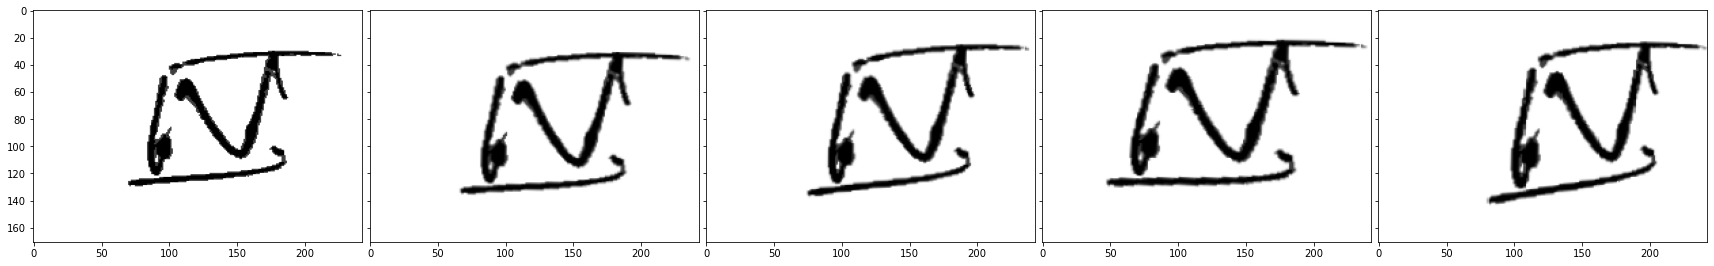

In [ ]:
seq = iaa.Sequential([iaa.PerspectiveTransform(scale=(0.01, 0.12))])
show_examples(seq)

This type of augmentation simulates a change in perspective of the image.

All augmentations used together:

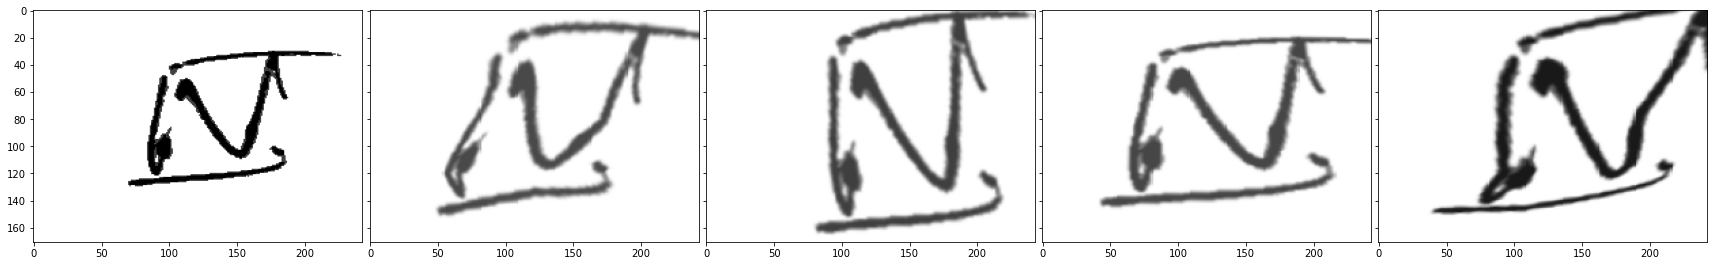

In [ ]:
seq = iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))), iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}), iaa.ShearX((-15, 15),cval=255), iaa.PiecewiseAffine(scale=(0.03, 0.05)), iaa.PerspectiveTransform(scale=(0.01, 0.12))])
show_examples(seq)

We define the following functions to augment data, manage the train\val folders and test the model's accuracy on a given folder.

In [ ]:
def augment_train_val(seq, num_label_train, num_label_val):
    rng = imgaug.random.RNG(41)
    labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
    # create train set
    for label in labels:
        images_train = os.listdir('data/train_/'+label)
        times_augment = math.ceil(num_label_train/len(images_train))-1
        i = 0
        saved = 0
        for image_path in images_train:
            original = Image.open('data/train_/'+label+'/'+image_path).convert("RGB")
            original_np = np.array(original)
            images = [original_np]*(times_augment)
            images_aug = seq(images=images)
            
            if (saved<num_label_train):
                original.save('data/train/'+label+'/'+str(i)+'.jpg')
                saved += 1
            i += 1
            for j in range(0, times_augment):
                if (saved<num_label_train):
                    im = Image.fromarray(np.uint8(images_aug[j]))
                    im.save('data/train/'+label+'/'+str(i)+'_'+str(j)+'.jpg')
                    saved += 1
            if saved == num_label_train:
                break
                
    # create val set
    for label in labels:
        images_val = os.listdir('data/val_/'+label)
        times_augment = math.ceil(num_label_val/len(images_val))-1
        i = 0
        saved = 0
        for image_path in images_val:
            original = Image.open('data/val_/'+label+'/'+image_path).convert("RGB")
            original_np = np.array(original)
            images = [original_np]*(times_augment)
            images_aug = seq(images=images)
            
            if (saved<num_label_val):
                original.save('data/val/'+label+'/'+str(i)+'.jpg')
                saved += 1
            i += 1
            for j in range(0, times_augment):
                if (saved<num_label_val):
                    im = Image.fromarray(np.uint8(images_aug[j]))
                    im.save('data/val/'+label+'/'+str(i)+'_'+str(j)+'.jpg')
                    saved += 1
            if saved == num_label_val:
                break

def copy_train_val():
    labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
    for label in labels:
        i = 0
        images_train = os.listdir('data/train_/'+label)
        for image_path in images_train:
            original = Image.open('data/train_/'+label+'/'+image_path).convert("RGB")
            original.save('data/train/'+label+'/'+str(i)+'.jpg')
            i += 1
    for label in labels:
        i = 0
        images_val = os.listdir('data/val_/'+label)
        for image_path in images_val:
            original = Image.open('data/val_/'+label+'/'+image_path).convert("RGB")
            original.save('data/val/'+label+'/'+str(i)+'.jpg')
            i += 1
                
def delete_augs():
    labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
    for label in labels:
        files = glob.glob('data/train/'+label+'/*')
        for f in files:
            os.remove(f)
    for label in labels:
        files = glob.glob('data/val/'+label+'/*')
        for f in files:
            os.remove(f)
            
def test_accuracy(test_path="data/validation_first", model_path="trained_model.pt", labelStats=False, returnPreds=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])
    test_dataset = datasets.ImageFolder(test_path, data_transforms)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    NUM_CLASSES = len(test_dataset.classes)

    model_ft = models.resnet50(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model_ft = model_ft.to(device)
    model_ft.load_state_dict(torch.load(model_path))
    model_ft.eval()
    
    num_images = 0
    num_correct = 0
    
    corrects = {label:0 for label in range(NUM_CLASSES)}
    num = {label:0 for label in range(NUM_CLASSES)}
    
    y_preds = []
    y_true = []
    
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
        num_correct += torch.sum(preds == labels.data)
        num_images += len(preds)
        
        num[labels.data[0].item()] += 1
        if torch.sum(preds == labels.data) == 1:
            corrects[labels.data[0].item()] += 1
            
        y_preds.append(preds.item())
        y_true.append(labels.data[0].item())
        
    if returnPreds:
        return num_correct / num_images, y_true, y_preds
    elif labelStats:
        return num_correct / num_images, {label:corrects[label]/num[label] for label in range(NUM_CLASSES)}
    else:
        return num_correct / num_images


We now try some random sets of augmentation methods and test them on a validation set.

Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


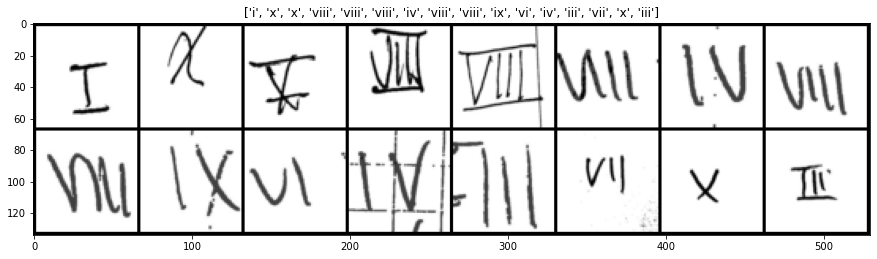

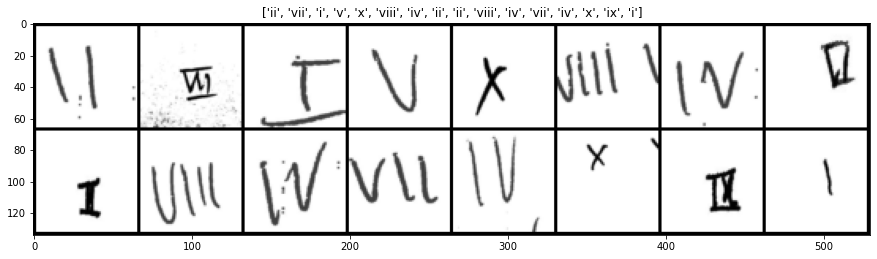

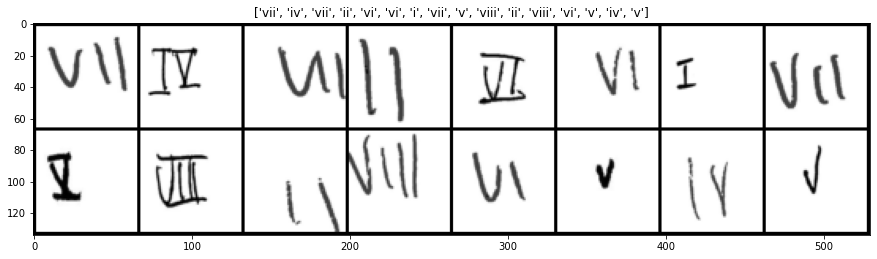

Epoch 1/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.82it/s]


train Loss: 2.6532 Acc: 0.1978


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.46it/s]


val Loss: 2.3352 Acc: 0.2280

Epoch 2/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.14it/s]


train Loss: 1.9449 Acc: 0.3839


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.39it/s]


val Loss: 1.8695 Acc: 0.3920

Epoch 3/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 1.3926 Acc: 0.5547


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.71it/s]


val Loss: 1.5695 Acc: 0.4880

Epoch 4/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.37it/s]


train Loss: 1.0093 Acc: 0.6396


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.92it/s]


val Loss: 2.7303 Acc: 0.3680

Epoch 5/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.8634 Acc: 0.7055


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.47it/s]


val Loss: 1.2611 Acc: 0.6440

Epoch 6/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 0.4744 Acc: 0.8446


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.05it/s]


val Loss: 0.6849 Acc: 0.7720

Epoch 7/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.37it/s]


train Loss: 0.2734 Acc: 0.9205


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.89it/s]


val Loss: 0.6150 Acc: 0.7920

Epoch 8/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.35it/s]


train Loss: 0.1779 Acc: 0.9539


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.14it/s]


val Loss: 0.5870 Acc: 0.8200

Epoch 9/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.1420 Acc: 0.9575


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.16it/s]


val Loss: 0.6161 Acc: 0.8000

Epoch 10/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.1181 Acc: 0.9702


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.49it/s]


val Loss: 0.6165 Acc: 0.8000

Epoch 11/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.0764 Acc: 0.9837


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.22it/s]


val Loss: 0.7138 Acc: 0.7960

Epoch 12/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0679 Acc: 0.9864


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.31it/s]


val Loss: 0.6552 Acc: 0.7920

Epoch 13/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0684 Acc: 0.9864


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.08it/s]


val Loss: 0.5783 Acc: 0.8120

Epoch 14/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.52it/s]


train Loss: 0.0672 Acc: 0.9855


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.40it/s]


val Loss: 0.5889 Acc: 0.8120

Epoch 15/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.48it/s]


train Loss: 0.0633 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.53it/s]


val Loss: 0.5838 Acc: 0.8080

Epoch 16/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.43it/s]


train Loss: 0.0589 Acc: 0.9928


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.97it/s]


val Loss: 0.5999 Acc: 0.8000

Epoch 17/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.45it/s]


train Loss: 0.0544 Acc: 0.9946


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.05it/s]


val Loss: 0.5766 Acc: 0.8400

Epoch 18/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0534 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.54it/s]


val Loss: 0.5695 Acc: 0.8160

Epoch 19/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 0.0576 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.31it/s]


val Loss: 0.6139 Acc: 0.8120

Epoch 20/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.33it/s]


train Loss: 0.0534 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.72it/s]


val Loss: 0.5835 Acc: 0.8080

Epoch 21/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.11it/s]


train Loss: 0.0570 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.36it/s]


val Loss: 0.5678 Acc: 0.8200

Epoch 22/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.24it/s]


train Loss: 0.0536 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.93it/s]


val Loss: 0.5827 Acc: 0.8160

Epoch 23/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.37it/s]


train Loss: 0.0516 Acc: 0.9946


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.38it/s]


val Loss: 0.6429 Acc: 0.8080

Epoch 24/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.34it/s]


train Loss: 0.0677 Acc: 0.9828


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.10it/s]


val Loss: 0.6484 Acc: 0.8000

Epoch 25/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.39it/s]


train Loss: 0.0634 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.55it/s]


val Loss: 0.6314 Acc: 0.8160

Epoch 26/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.43it/s]


train Loss: 0.0631 Acc: 0.9864


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.20it/s]


val Loss: 0.6098 Acc: 0.8080

Epoch 27/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0578 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.92it/s]


val Loss: 0.5880 Acc: 0.8160

Epoch 28/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.17it/s]


train Loss: 0.0560 Acc: 0.9928


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.40it/s]


val Loss: 0.5661 Acc: 0.8240

Epoch 29/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.48it/s]


train Loss: 0.0500 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.03it/s]


val Loss: 0.5970 Acc: 0.8160

Epoch 30/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.12it/s]


train Loss: 0.0512 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.85it/s]


val Loss: 0.5810 Acc: 0.8120

Epoch 31/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.08it/s]


train Loss: 0.0606 Acc: 0.9874


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.15it/s]


val Loss: 0.5806 Acc: 0.8240

Epoch 32/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.0593 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.76it/s]


val Loss: 0.5676 Acc: 0.8200

Epoch 33/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.48it/s]


train Loss: 0.0619 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.25it/s]


val Loss: 0.6095 Acc: 0.8200

Epoch 34/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.12it/s]


train Loss: 0.0596 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.92it/s]


val Loss: 0.5721 Acc: 0.8120

Epoch 35/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0630 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.33it/s]


val Loss: 0.5799 Acc: 0.8200

Epoch 36/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.27it/s]


train Loss: 0.0541 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.46it/s]


val Loss: 0.5815 Acc: 0.8120

Epoch 37/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.06it/s]


train Loss: 0.0556 Acc: 0.9946


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.21it/s]


val Loss: 0.6200 Acc: 0.8080

Epoch 38/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.04it/s]


train Loss: 0.0635 Acc: 0.9864


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.20it/s]


val Loss: 0.5976 Acc: 0.8040

Epoch 39/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.04it/s]


train Loss: 0.0535 Acc: 0.9937


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.77it/s]


val Loss: 0.5753 Acc: 0.8200

Epoch 40/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.19it/s]


train Loss: 0.0549 Acc: 0.9955


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.47it/s]


val Loss: 0.6287 Acc: 0.8080

Epoch 41/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.0627 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.22it/s]


val Loss: 0.6138 Acc: 0.8120

Epoch 42/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.47it/s]


train Loss: 0.0619 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.13it/s]


val Loss: 0.5710 Acc: 0.8200

Epoch 43/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.43it/s]


train Loss: 0.0603 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.45it/s]


val Loss: 0.6118 Acc: 0.8000

Epoch 44/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.45it/s]


train Loss: 0.0548 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.69it/s]


val Loss: 0.6059 Acc: 0.8160

Epoch 45/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.51it/s]


train Loss: 0.0676 Acc: 0.9855


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.70it/s]


val Loss: 0.5795 Acc: 0.8200

Epoch 46/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.10it/s]


train Loss: 0.0531 Acc: 0.9928


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.35it/s]


val Loss: 0.5979 Acc: 0.8120

Epoch 47/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0552 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.83it/s]


val Loss: 0.5752 Acc: 0.8120

Epoch 48/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.26it/s]


train Loss: 0.0602 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.24it/s]


val Loss: 0.6094 Acc: 0.8120

Epoch 49/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0610 Acc: 0.9855


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.43it/s]


val Loss: 0.5963 Acc: 0.8200

Epoch 50/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.37it/s]


train Loss: 0.0584 Acc: 0.9883


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.73it/s]


val Loss: 0.6042 Acc: 0.8040

Epoch 51/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.11it/s]


train Loss: 0.0573 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.94it/s]


val Loss: 0.5696 Acc: 0.8200

Epoch 52/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0620 Acc: 0.9883


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.45it/s]


val Loss: 0.6668 Acc: 0.8080

Epoch 53/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.47it/s]


train Loss: 0.0500 Acc: 0.9955


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.73it/s]


val Loss: 0.5759 Acc: 0.8200

Epoch 54/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.25it/s]


train Loss: 0.0691 Acc: 0.9874


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.37it/s]


val Loss: 0.5809 Acc: 0.8160

Epoch 55/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0554 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.46it/s]


val Loss: 0.5967 Acc: 0.8120

Epoch 56/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.39it/s]


train Loss: 0.0748 Acc: 0.9810


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.22it/s]


val Loss: 0.5785 Acc: 0.8080

Epoch 57/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0569 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.24it/s]


val Loss: 0.6231 Acc: 0.8240

Epoch 58/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.49it/s]


train Loss: 0.0552 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.49it/s]


val Loss: 0.5771 Acc: 0.8240

Epoch 59/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.48it/s]


train Loss: 0.0580 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.37it/s]


val Loss: 0.6165 Acc: 0.7920

Epoch 60/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.43it/s]


train Loss: 0.0562 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.88it/s]


val Loss: 0.5921 Acc: 0.8040

Epoch 61/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 0.0544 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.09it/s]


val Loss: 0.5794 Acc: 0.8240

Epoch 62/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.46it/s]


train Loss: 0.0577 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.50it/s]


val Loss: 0.6423 Acc: 0.8120

Epoch 63/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.36it/s]


train Loss: 0.0667 Acc: 0.9883


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.28it/s]


val Loss: 0.6099 Acc: 0.8040

Epoch 64/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.0593 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.57it/s]


val Loss: 0.5966 Acc: 0.8040

Epoch 65/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0576 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.61it/s]


val Loss: 0.5902 Acc: 0.8080

Epoch 66/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.37it/s]


train Loss: 0.0598 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.45it/s]


val Loss: 0.6162 Acc: 0.8040

Epoch 67/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.23it/s]


train Loss: 0.0436 Acc: 0.9973


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.61it/s]


val Loss: 0.5983 Acc: 0.8200

Epoch 68/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.00it/s]


train Loss: 0.0571 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.36it/s]


val Loss: 0.6122 Acc: 0.7960

Epoch 69/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.16it/s]


train Loss: 0.0601 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.91it/s]


val Loss: 0.5985 Acc: 0.8080

Epoch 70/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.46it/s]


train Loss: 0.0599 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.29it/s]


val Loss: 0.6019 Acc: 0.8200

Epoch 71/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.0547 Acc: 0.9928


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.27it/s]


val Loss: 0.5853 Acc: 0.8040

Epoch 72/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.50it/s]


train Loss: 0.0728 Acc: 0.9855


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.62it/s]


val Loss: 0.5762 Acc: 0.8200

Epoch 73/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0801 Acc: 0.9783


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.30it/s]


val Loss: 0.6453 Acc: 0.8120

Epoch 74/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.0558 Acc: 0.9874


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.70it/s]


val Loss: 0.5950 Acc: 0.8160

Epoch 75/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.49it/s]


train Loss: 0.0542 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.64it/s]


val Loss: 0.6045 Acc: 0.8160

Epoch 76/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.38it/s]


train Loss: 0.0518 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.00it/s]


val Loss: 0.5690 Acc: 0.8240

Epoch 77/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.43it/s]


train Loss: 0.0754 Acc: 0.9846


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.14it/s]


val Loss: 0.6226 Acc: 0.7920

Epoch 78/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.32it/s]


train Loss: 0.0702 Acc: 0.9837


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.41it/s]


val Loss: 0.5969 Acc: 0.8120

Epoch 79/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.46it/s]


train Loss: 0.0557 Acc: 0.9928


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.55it/s]


val Loss: 0.5877 Acc: 0.8080

Epoch 80/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.45it/s]


train Loss: 0.0454 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.22it/s]


val Loss: 0.6049 Acc: 0.8240

Epoch 81/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.37it/s]


train Loss: 0.0662 Acc: 0.9874


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.22it/s]


val Loss: 0.5790 Acc: 0.8200

Epoch 82/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.44it/s]


train Loss: 0.0646 Acc: 0.9874


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.97it/s]


val Loss: 0.6156 Acc: 0.8160

Epoch 83/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.32it/s]


train Loss: 0.0595 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.96it/s]


val Loss: 0.5798 Acc: 0.8160

Epoch 84/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.43it/s]


train Loss: 0.0537 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.35it/s]


val Loss: 0.5823 Acc: 0.8120

Epoch 85/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0614 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.41it/s]


val Loss: 0.5945 Acc: 0.8040

Epoch 86/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.38it/s]


train Loss: 0.0545 Acc: 0.9919


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.02it/s]


val Loss: 0.6188 Acc: 0.7920

Epoch 87/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0566 Acc: 0.9892


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.55it/s]


val Loss: 0.5978 Acc: 0.8080

Epoch 88/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0544 Acc: 0.9946


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.35it/s]


val Loss: 0.6273 Acc: 0.8120

Epoch 89/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0473 Acc: 0.9955


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.78it/s]


val Loss: 0.5897 Acc: 0.8160

Epoch 90/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0734 Acc: 0.9810


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.12it/s]


val Loss: 0.5888 Acc: 0.8080

Epoch 91/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0580 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.11it/s]


val Loss: 0.5720 Acc: 0.8200

Epoch 92/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 0.0579 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.69it/s]


val Loss: 0.5844 Acc: 0.8080

Epoch 93/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 0.0638 Acc: 0.9828


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.73it/s]


val Loss: 0.6178 Acc: 0.8000

Epoch 94/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.33it/s]


train Loss: 0.0674 Acc: 0.9810


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.24it/s]


val Loss: 0.5682 Acc: 0.8160

Epoch 95/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.38it/s]


train Loss: 0.0575 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.69it/s]


val Loss: 0.5911 Acc: 0.8120

Epoch 96/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.29it/s]


train Loss: 0.0621 Acc: 0.9883


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.91it/s]


val Loss: 0.5870 Acc: 0.8280

Epoch 97/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.40it/s]


train Loss: 0.0632 Acc: 0.9901


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.36it/s]


val Loss: 0.6355 Acc: 0.8160

Epoch 98/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 0.0544 Acc: 0.9910


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.60it/s]


val Loss: 0.5715 Acc: 0.8120

Epoch 99/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 0.0654 Acc: 0.9855


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.15it/s]


val Loss: 0.5828 Acc: 0.8160

Epoch 100/100
----------


100%|█████████████████████████████████████████████████████████████████████████| 70/70 [00:06<00:00, 11.35it/s]


train Loss: 0.0538 Acc: 0.9937


100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.78it/s]


val Loss: 0.6118 Acc: 0.8000

Training complete in 11m 27s
Best val Acc: 0.840000
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


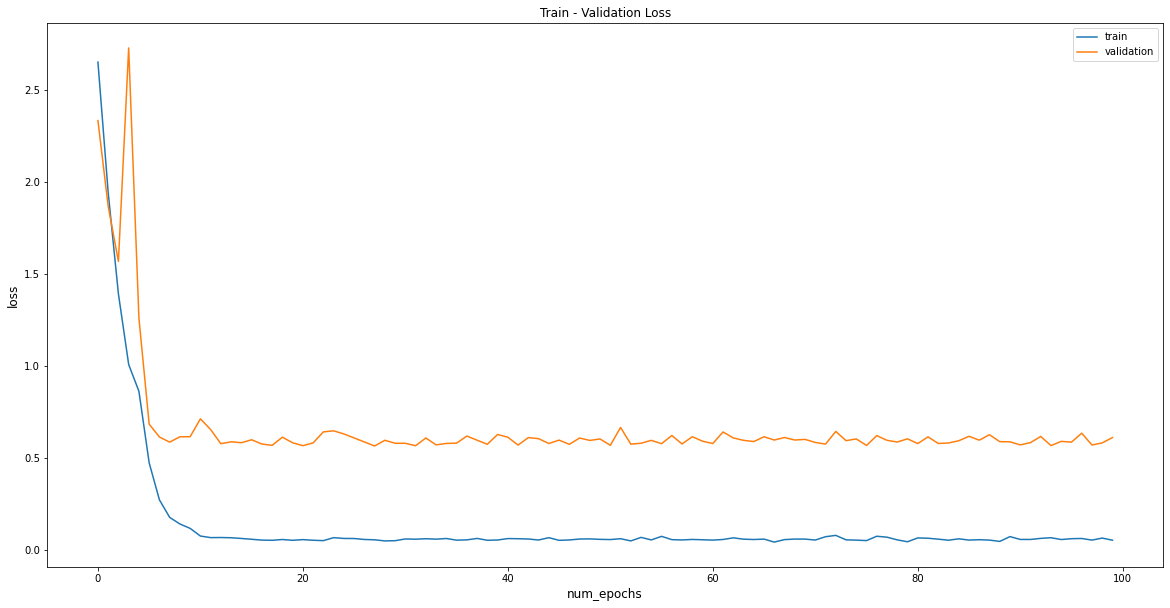

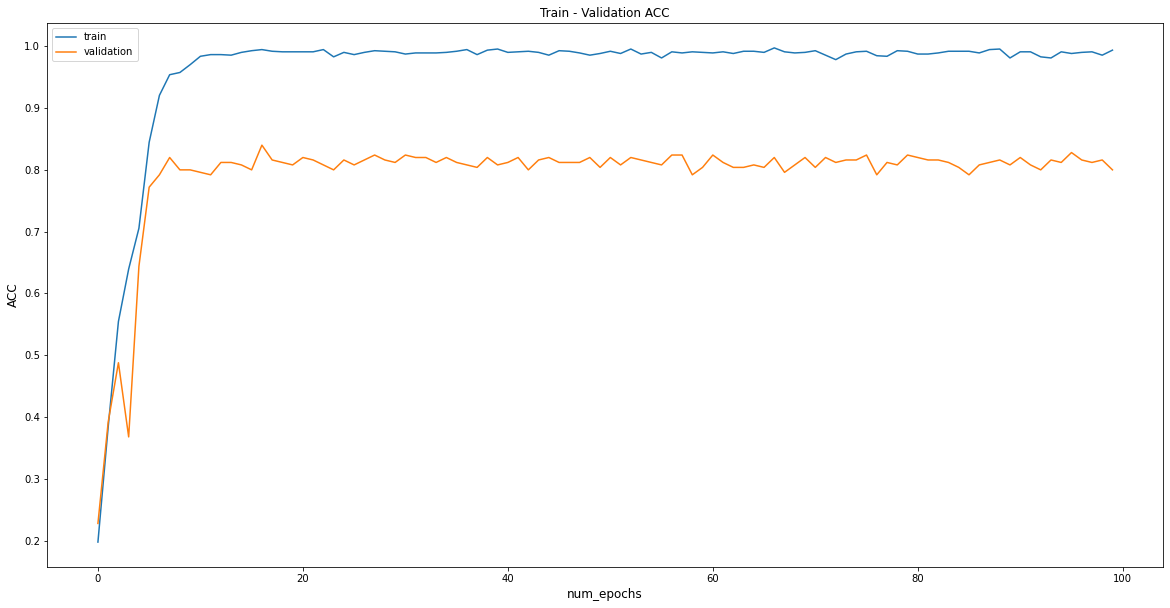

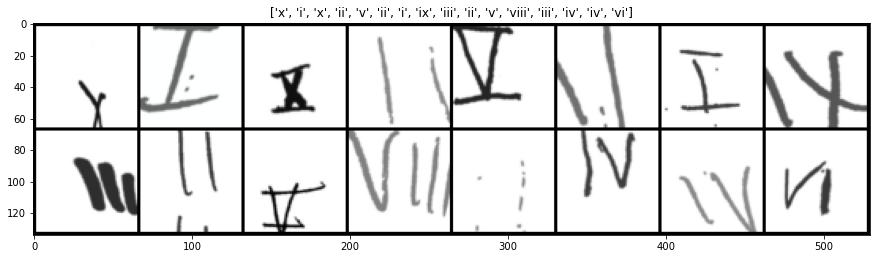

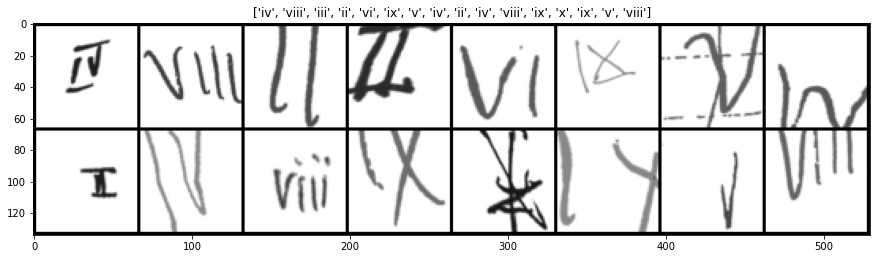

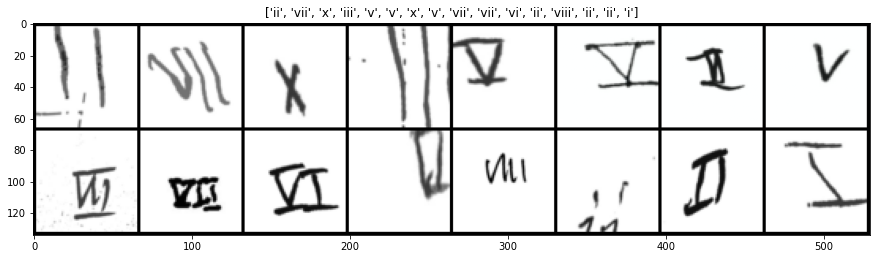

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 1.7300 Acc: 0.4320


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.58it/s]


val Loss: 1.1933 Acc: 0.6145

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.7752 Acc: 0.7409


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.48it/s]


val Loss: 0.9951 Acc: 0.6835

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.5456 Acc: 0.8213


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.71it/s]


val Loss: 0.8101 Acc: 0.7485

Epoch 4/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.4427 Acc: 0.8546


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.41it/s]


val Loss: 0.6771 Acc: 0.7935

Epoch 5/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.3459 Acc: 0.8880


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.90it/s]


val Loss: 0.7484 Acc: 0.7895

Epoch 6/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.1224 Acc: 0.9616


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.17it/s]


val Loss: 0.4659 Acc: 0.8595

Epoch 7/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0760 Acc: 0.9763


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.4953 Acc: 0.8625

Epoch 8/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0531 Acc: 0.9838


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.5434 Acc: 0.8590

Epoch 9/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0396 Acc: 0.9870


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.6025 Acc: 0.8585

Epoch 10/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0317 Acc: 0.9901


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.5731 Acc: 0.8570

Epoch 11/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0179 Acc: 0.9962


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.5648 Acc: 0.8620

Epoch 12/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0148 Acc: 0.9962


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.66it/s]


val Loss: 0.5879 Acc: 0.8590

Epoch 13/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0116 Acc: 0.9981


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.5670 Acc: 0.8655

Epoch 14/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0117 Acc: 0.9980


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.5719 Acc: 0.8630

Epoch 15/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.12it/s]


train Loss: 0.0099 Acc: 0.9980


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.90it/s]


val Loss: 0.5795 Acc: 0.8570

Epoch 16/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0084 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.92it/s]


val Loss: 0.5965 Acc: 0.8570

Epoch 17/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0081 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.36it/s]


val Loss: 0.5908 Acc: 0.8605

Epoch 18/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0081 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.5789 Acc: 0.8635

Epoch 19/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0090 Acc: 0.9984


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.86it/s]


val Loss: 0.5813 Acc: 0.8560

Epoch 20/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0082 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.20it/s]


val Loss: 0.5798 Acc: 0.8635

Epoch 21/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.05it/s]


train Loss: 0.0079 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.32it/s]


val Loss: 0.5820 Acc: 0.8615

Epoch 22/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0081 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.35it/s]


val Loss: 0.5934 Acc: 0.8615

Epoch 23/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.99it/s]


train Loss: 0.0068 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.5935 Acc: 0.8585

Epoch 24/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.09it/s]


train Loss: 0.0067 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.02it/s]


val Loss: 0.5889 Acc: 0.8605

Epoch 25/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0066 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.5954 Acc: 0.8600

Epoch 26/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0072 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.5776 Acc: 0.8655

Epoch 27/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.08it/s]


train Loss: 0.0069 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.46it/s]


val Loss: 0.5895 Acc: 0.8615

Epoch 28/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0090 Acc: 0.9981


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.5860 Acc: 0.8625

Epoch 29/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0073 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.48it/s]


val Loss: 0.5766 Acc: 0.8635

Epoch 30/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]


train Loss: 0.0075 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.17it/s]


val Loss: 0.5653 Acc: 0.8635

Epoch 31/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0073 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.40it/s]


val Loss: 0.5768 Acc: 0.8635

Epoch 32/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0067 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.66it/s]


val Loss: 0.5971 Acc: 0.8615

Epoch 33/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0076 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.28it/s]


val Loss: 0.5800 Acc: 0.8625

Epoch 34/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 0.0070 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.46it/s]


val Loss: 0.5682 Acc: 0.8650

Epoch 35/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0075 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.54it/s]


val Loss: 0.5847 Acc: 0.8610

Epoch 36/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0073 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.57it/s]


val Loss: 0.5714 Acc: 0.8655

Epoch 37/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 0.0066 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.68it/s]


val Loss: 0.5790 Acc: 0.8625

Epoch 38/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0080 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.53it/s]


val Loss: 0.5961 Acc: 0.8570

Epoch 39/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0078 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.62it/s]


val Loss: 0.5646 Acc: 0.8655

Epoch 40/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0081 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.24it/s]


val Loss: 0.5865 Acc: 0.8600

Epoch 41/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0075 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.38it/s]


val Loss: 0.5766 Acc: 0.8625

Epoch 42/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0080 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.34it/s]


val Loss: 0.5892 Acc: 0.8630

Epoch 43/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0077 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.62it/s]


val Loss: 0.5910 Acc: 0.8585

Epoch 44/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0070 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.95it/s]


val Loss: 0.5748 Acc: 0.8645

Epoch 45/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.08it/s]


train Loss: 0.0082 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.94it/s]


val Loss: 0.5830 Acc: 0.8645

Epoch 46/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0087 Acc: 0.9982


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.43it/s]


val Loss: 0.5938 Acc: 0.8595

Epoch 47/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.07it/s]


train Loss: 0.0079 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.63it/s]


val Loss: 0.5924 Acc: 0.8595

Epoch 48/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.11it/s]


train Loss: 0.0088 Acc: 0.9981


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.83it/s]


val Loss: 0.5856 Acc: 0.8590

Epoch 49/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.11it/s]


train Loss: 0.0071 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.81it/s]


val Loss: 0.5860 Acc: 0.8645

Epoch 50/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0069 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.91it/s]


val Loss: 0.5841 Acc: 0.8650

Epoch 51/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0087 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5868 Acc: 0.8595

Epoch 52/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.08it/s]


train Loss: 0.0082 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.85it/s]


val Loss: 0.5809 Acc: 0.8610

Epoch 53/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0072 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.83it/s]


val Loss: 0.5825 Acc: 0.8650

Epoch 54/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0075 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.5766 Acc: 0.8615

Epoch 55/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0077 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.36it/s]


val Loss: 0.5936 Acc: 0.8600

Epoch 56/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0076 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.60it/s]


val Loss: 0.6121 Acc: 0.8600

Epoch 57/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0081 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.30it/s]


val Loss: 0.5863 Acc: 0.8625

Epoch 58/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0083 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.43it/s]


val Loss: 0.5927 Acc: 0.8615

Epoch 59/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.04it/s]


train Loss: 0.0068 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.5798 Acc: 0.8650

Epoch 60/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0088 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.5890 Acc: 0.8615

Epoch 61/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0085 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.5722 Acc: 0.8670

Epoch 62/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0077 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.46it/s]


val Loss: 0.5801 Acc: 0.8590

Epoch 63/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0076 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.48it/s]


val Loss: 0.6024 Acc: 0.8610

Epoch 64/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0073 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.40it/s]


val Loss: 0.5818 Acc: 0.8625

Epoch 65/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0078 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.42it/s]


val Loss: 0.5889 Acc: 0.8625

Epoch 66/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.17it/s]


train Loss: 0.0074 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.42it/s]


val Loss: 0.5784 Acc: 0.8635

Epoch 67/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0076 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.27it/s]


val Loss: 0.5858 Acc: 0.8580

Epoch 68/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.08it/s]


train Loss: 0.0082 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.52it/s]


val Loss: 0.5793 Acc: 0.8640

Epoch 69/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0095 Acc: 0.9984


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.93it/s]


val Loss: 0.5835 Acc: 0.8630

Epoch 70/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0070 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.32it/s]


val Loss: 0.6047 Acc: 0.8625

Epoch 71/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]


train Loss: 0.0070 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.5877 Acc: 0.8625

Epoch 72/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0070 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5767 Acc: 0.8640

Epoch 73/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0086 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.38it/s]


val Loss: 0.5985 Acc: 0.8620

Epoch 74/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0069 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.80it/s]


val Loss: 0.5919 Acc: 0.8630

Epoch 75/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0091 Acc: 0.9982


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.83it/s]


val Loss: 0.5981 Acc: 0.8640

Epoch 76/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0073 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.50it/s]


val Loss: 0.5947 Acc: 0.8615

Epoch 77/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0074 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.5818 Acc: 0.8610

Epoch 78/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0076 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.03it/s]


val Loss: 0.5955 Acc: 0.8620

Epoch 79/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0084 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.59it/s]


val Loss: 0.5909 Acc: 0.8615

Epoch 80/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0076 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.42it/s]


val Loss: 0.5651 Acc: 0.8670

Epoch 81/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0075 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.04it/s]


val Loss: 0.5714 Acc: 0.8635

Epoch 82/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0084 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.51it/s]


val Loss: 0.5748 Acc: 0.8605

Epoch 83/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0069 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.52it/s]


val Loss: 0.5710 Acc: 0.8625

Epoch 84/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0077 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.5835 Acc: 0.8610

Epoch 85/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0074 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.18it/s]


val Loss: 0.5845 Acc: 0.8635

Epoch 86/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0075 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.81it/s]


val Loss: 0.5922 Acc: 0.8655

Epoch 87/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0080 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.44it/s]


val Loss: 0.5771 Acc: 0.8610

Epoch 88/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.97it/s]


train Loss: 0.0081 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.18it/s]


val Loss: 0.5777 Acc: 0.8585

Epoch 89/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0079 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.18it/s]


val Loss: 0.5693 Acc: 0.8640

Epoch 90/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0065 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.90it/s]


val Loss: 0.5856 Acc: 0.8640

Epoch 91/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0070 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.39it/s]


val Loss: 0.5788 Acc: 0.8605

Epoch 92/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.73it/s]


train Loss: 0.0071 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.95it/s]


val Loss: 0.5904 Acc: 0.8605

Epoch 93/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0079 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.22it/s]


val Loss: 0.5802 Acc: 0.8615

Epoch 94/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.99it/s]


train Loss: 0.0070 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.44it/s]


val Loss: 0.5794 Acc: 0.8635

Epoch 95/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0080 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.24it/s]


val Loss: 0.5735 Acc: 0.8645

Epoch 96/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0073 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.00it/s]


val Loss: 0.5672 Acc: 0.8640

Epoch 97/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0081 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.54it/s]


val Loss: 0.5877 Acc: 0.8605

Epoch 98/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0067 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.86it/s]


val Loss: 0.5853 Acc: 0.8605

Epoch 99/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.05it/s]


train Loss: 0.0078 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.34it/s]


val Loss: 0.5896 Acc: 0.8640

Epoch 100/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.87it/s]


train Loss: 0.0075 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.09it/s]


val Loss: 0.5718 Acc: 0.8635

Training complete in 83m 4s
Best val Acc: 0.867000
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


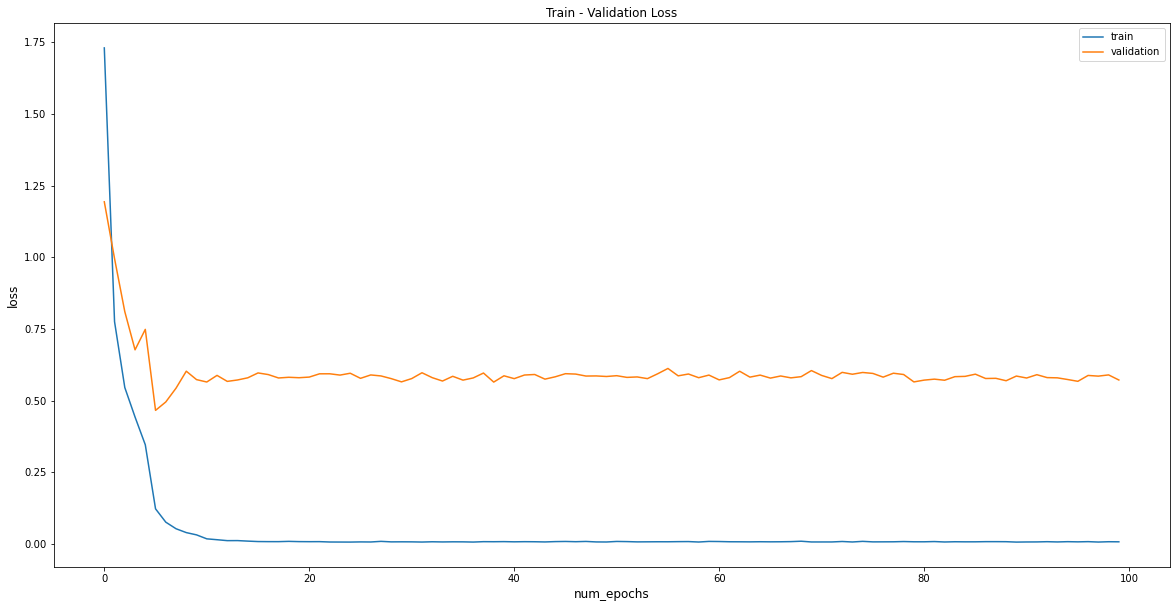

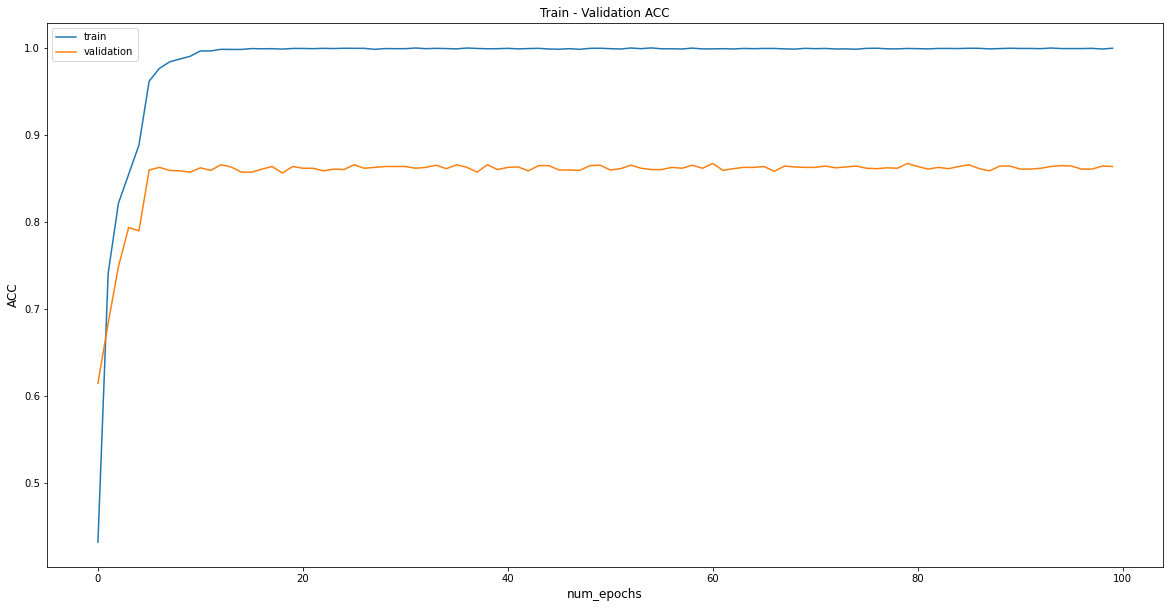

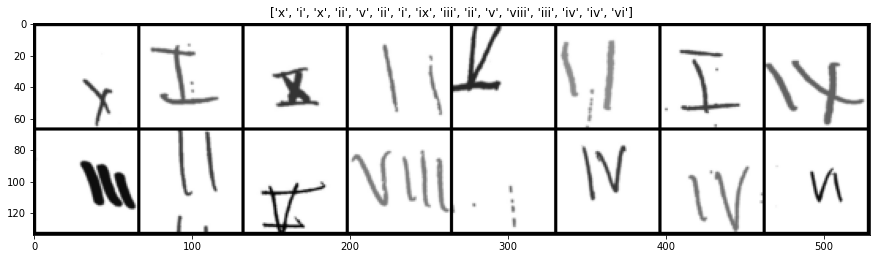

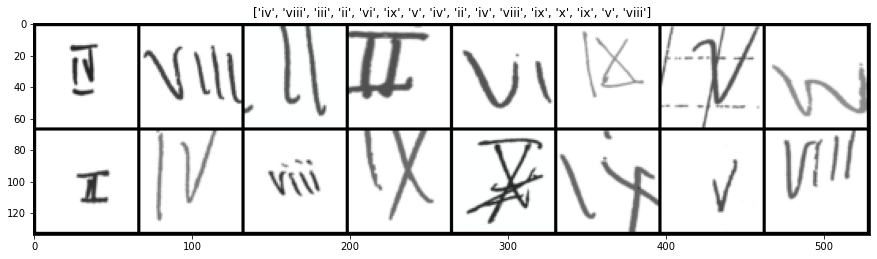

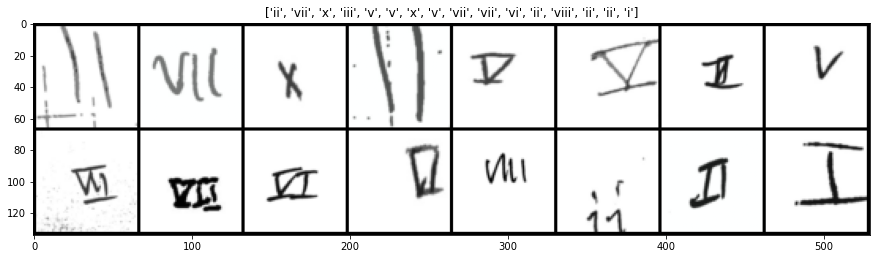

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 1.5285 Acc: 0.5076


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.66it/s]


val Loss: 2.8607 Acc: 0.4095

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.5936 Acc: 0.8114


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.5285 Acc: 0.8265

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.3862 Acc: 0.8810


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.02it/s]


val Loss: 0.7360 Acc: 0.7750

Epoch 4/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.3128 Acc: 0.9020


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.6955 Acc: 0.8130

Epoch 5/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.2889 Acc: 0.9134


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.06it/s]


val Loss: 0.5685 Acc: 0.8405

Epoch 6/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0654 Acc: 0.9810


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.3893 Acc: 0.8925

Epoch 7/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0323 Acc: 0.9908


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.76it/s]


val Loss: 0.4210 Acc: 0.8900

Epoch 8/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0225 Acc: 0.9942


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.4217 Acc: 0.8905

Epoch 9/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0142 Acc: 0.9964


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.53it/s]


val Loss: 0.4589 Acc: 0.8835

Epoch 10/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0099 Acc: 0.9982


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.28it/s]


val Loss: 0.4334 Acc: 0.9000

Epoch 11/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0079 Acc: 0.9981


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.4485 Acc: 0.8975

Epoch 12/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0053 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.87it/s]


val Loss: 0.4673 Acc: 0.8935

Epoch 13/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0053 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.58it/s]


val Loss: 0.4306 Acc: 0.8965

Epoch 14/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0043 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.4398 Acc: 0.9020

Epoch 15/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0041 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.4557 Acc: 0.8945

Epoch 16/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0041 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.46it/s]


val Loss: 0.4720 Acc: 0.8955

Epoch 17/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0038 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.24it/s]


val Loss: 0.4718 Acc: 0.8970

Epoch 18/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0041 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.31it/s]


val Loss: 0.4619 Acc: 0.8970

Epoch 19/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0038 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.4638 Acc: 0.8935

Epoch 20/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0036 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.18it/s]


val Loss: 0.4734 Acc: 0.9000

Epoch 21/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0032 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.71it/s]


val Loss: 0.4623 Acc: 0.8960

Epoch 22/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0034 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.74it/s]


val Loss: 0.4850 Acc: 0.8960

Epoch 23/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0030 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.58it/s]


val Loss: 0.4550 Acc: 0.8970

Epoch 24/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.09it/s]


train Loss: 0.0037 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.4660 Acc: 0.8975

Epoch 25/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0029 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.55it/s]


val Loss: 0.4696 Acc: 0.8965

Epoch 26/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.4592 Acc: 0.9005

Epoch 27/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0035 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.4717 Acc: 0.8970

Epoch 28/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0037 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.07it/s]


val Loss: 0.4515 Acc: 0.8985

Epoch 29/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0034 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.4622 Acc: 0.8990

Epoch 30/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0028 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.4524 Acc: 0.8940

Epoch 31/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0035 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.93it/s]


val Loss: 0.4794 Acc: 0.8970

Epoch 32/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0031 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.83it/s]


val Loss: 0.4809 Acc: 0.8965

Epoch 33/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.80it/s]


val Loss: 0.4678 Acc: 0.8960

Epoch 34/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0030 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.80it/s]


val Loss: 0.4423 Acc: 0.9005

Epoch 35/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0031 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.4619 Acc: 0.8985

Epoch 36/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0030 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.4474 Acc: 0.8975

Epoch 37/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.98it/s]


val Loss: 0.4671 Acc: 0.8985

Epoch 38/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0031 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.08it/s]


val Loss: 0.4596 Acc: 0.8980

Epoch 39/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.08it/s]


train Loss: 0.0030 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.76it/s]


val Loss: 0.4466 Acc: 0.8975

Epoch 40/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0026 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.24it/s]


val Loss: 0.4634 Acc: 0.8935

Epoch 41/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0035 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.45it/s]


val Loss: 0.4460 Acc: 0.8980

Epoch 42/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0034 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.92it/s]


val Loss: 0.4715 Acc: 0.8920

Epoch 43/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.4726 Acc: 0.8965

Epoch 44/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0039 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.93it/s]


val Loss: 0.4623 Acc: 0.8955

Epoch 45/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0044 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.80it/s]


val Loss: 0.4691 Acc: 0.8985

Epoch 46/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0041 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.85it/s]


val Loss: 0.4616 Acc: 0.8985

Epoch 47/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0035 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.83it/s]


val Loss: 0.4628 Acc: 0.8965

Epoch 48/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0028 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.99it/s]


val Loss: 0.4650 Acc: 0.8980

Epoch 49/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0027 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.4752 Acc: 0.8960

Epoch 50/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0038 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.05it/s]


val Loss: 0.4727 Acc: 0.8905

Epoch 51/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0038 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4767 Acc: 0.8930

Epoch 52/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0030 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.62it/s]


val Loss: 0.4575 Acc: 0.8970

Epoch 53/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0035 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.4635 Acc: 0.8955

Epoch 54/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0031 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.24it/s]


val Loss: 0.4439 Acc: 0.8955

Epoch 55/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0041 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.05it/s]


val Loss: 0.4666 Acc: 0.8945

Epoch 56/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0034 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.4873 Acc: 0.8915

Epoch 57/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0037 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.4439 Acc: 0.8985

Epoch 58/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0031 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.71it/s]


val Loss: 0.4834 Acc: 0.8960

Epoch 59/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0031 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.82it/s]


val Loss: 0.4498 Acc: 0.8975

Epoch 60/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0034 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.66it/s]


val Loss: 0.4583 Acc: 0.8985

Epoch 61/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0049 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 25.00it/s]


val Loss: 0.4678 Acc: 0.8980

Epoch 62/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.4557 Acc: 0.8970

Epoch 63/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0033 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.4680 Acc: 0.8990

Epoch 64/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0033 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.90it/s]


val Loss: 0.4662 Acc: 0.8975

Epoch 65/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.4704 Acc: 0.8975

Epoch 66/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.87it/s]


val Loss: 0.4648 Acc: 0.8955

Epoch 67/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0037 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.15it/s]


val Loss: 0.4749 Acc: 0.8945

Epoch 68/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0030 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4529 Acc: 0.9020

Epoch 69/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0041 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4539 Acc: 0.8970

Epoch 70/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0035 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.96it/s]


val Loss: 0.4675 Acc: 0.8930

Epoch 71/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0036 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.02it/s]


val Loss: 0.4711 Acc: 0.8975

Epoch 72/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.07it/s]


train Loss: 0.0028 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.4656 Acc: 0.9000

Epoch 73/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0039 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.29it/s]


val Loss: 0.4719 Acc: 0.8960

Epoch 74/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0030 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.4643 Acc: 0.8950

Epoch 75/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0035 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.4732 Acc: 0.8985

Epoch 76/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0032 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.4650 Acc: 0.9005

Epoch 77/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0031 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.59it/s]


val Loss: 0.4651 Acc: 0.8975

Epoch 78/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0031 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.4775 Acc: 0.8995

Epoch 79/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0030 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.4590 Acc: 0.9015

Epoch 80/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0040 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.4572 Acc: 0.9005

Epoch 81/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 0.0030 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.36it/s]


val Loss: 0.4480 Acc: 0.8970

Epoch 82/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0043 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.4549 Acc: 0.8965

Epoch 83/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.4650 Acc: 0.8990

Epoch 84/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0035 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.4638 Acc: 0.8960

Epoch 85/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0033 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.43it/s]


val Loss: 0.4723 Acc: 0.8985

Epoch 86/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0032 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.4619 Acc: 0.8980

Epoch 87/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0033 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.48it/s]


val Loss: 0.4577 Acc: 0.8965

Epoch 88/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0036 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.95it/s]


val Loss: 0.4591 Acc: 0.8955

Epoch 89/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.03it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4565 Acc: 0.8975

Epoch 90/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.62it/s]


val Loss: 0.4696 Acc: 0.8985

Epoch 91/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0033 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.95it/s]


val Loss: 0.4565 Acc: 0.8995

Epoch 92/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0032 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.4776 Acc: 0.8950

Epoch 93/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0032 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.4577 Acc: 0.9000

Epoch 94/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0037 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.4646 Acc: 0.8995

Epoch 95/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0039 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.80it/s]


val Loss: 0.4623 Acc: 0.9015

Epoch 96/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.01it/s]


val Loss: 0.4467 Acc: 0.8990

Epoch 97/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0033 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.4614 Acc: 0.9000

Epoch 98/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0044 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.03it/s]


val Loss: 0.4650 Acc: 0.8990

Epoch 99/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0033 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.4652 Acc: 0.8970

Epoch 100/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0038 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.05it/s]


val Loss: 0.4579 Acc: 0.8970

Training complete in 82m 30s
Best val Acc: 0.902000
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


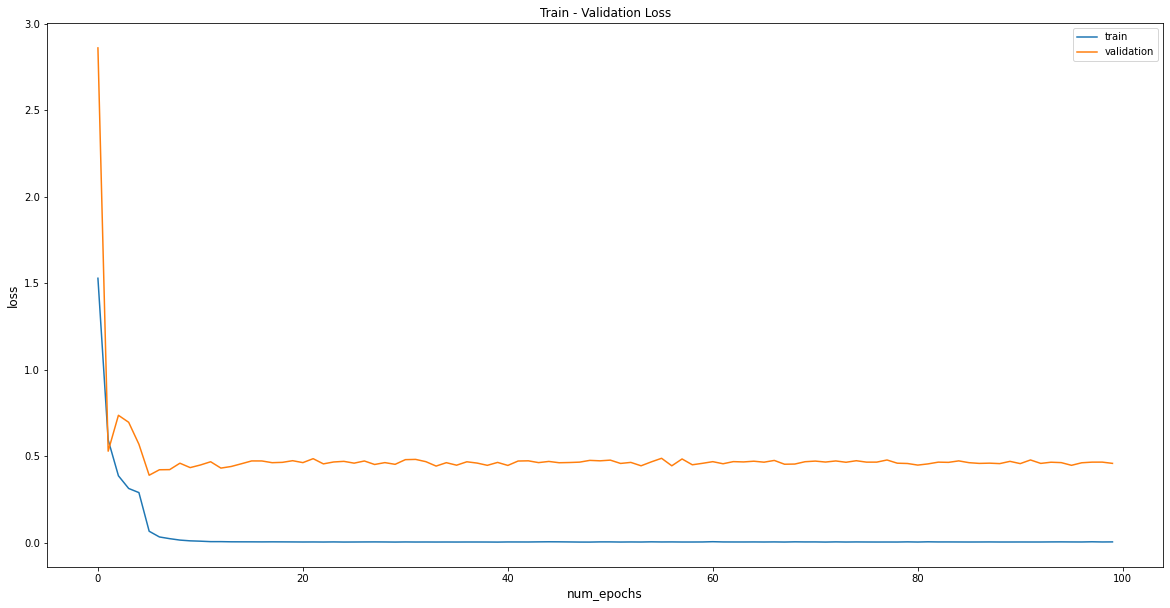

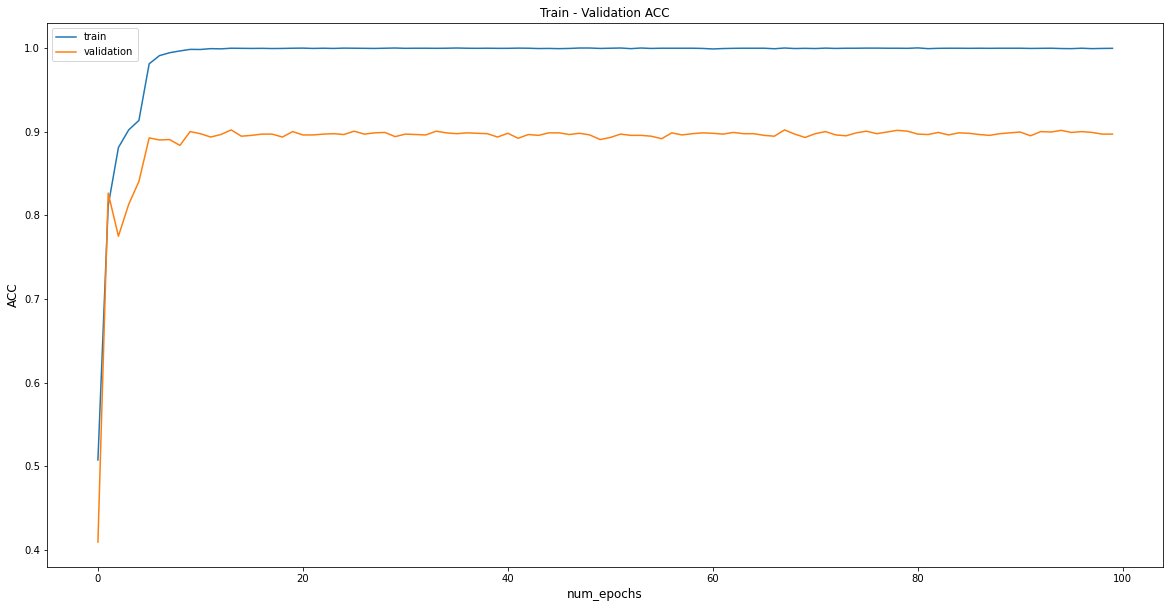

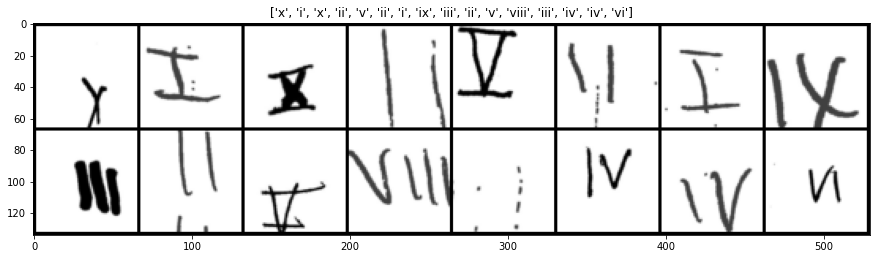

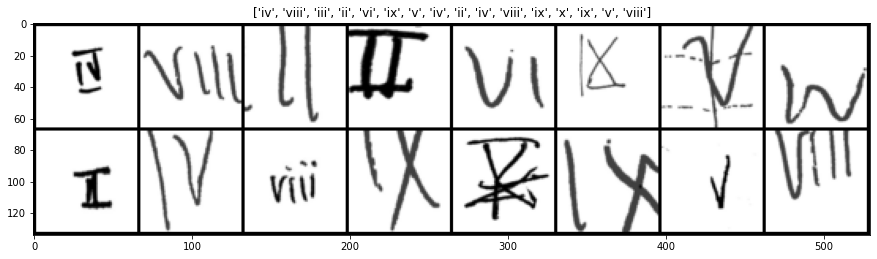

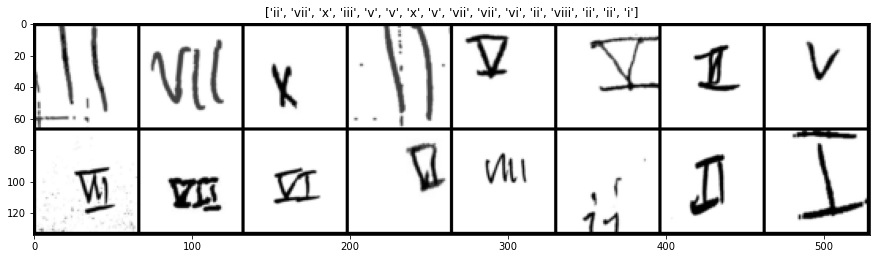

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 1.4956 Acc: 0.5224


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.24it/s]


val Loss: 1.5984 Acc: 0.5650

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.5421 Acc: 0.8244


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.6111 Acc: 0.8080

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.3391 Acc: 0.8970


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.9083 Acc: 0.7510

Epoch 4/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.2905 Acc: 0.9123


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.8403 Acc: 0.7760

Epoch 5/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.2374 Acc: 0.9286


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.59it/s]


val Loss: 0.7563 Acc: 0.7925

Epoch 6/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0500 Acc: 0.9860


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.30it/s]


val Loss: 0.5561 Acc: 0.8575

Epoch 7/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0201 Acc: 0.9950


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.35it/s]


val Loss: 0.5508 Acc: 0.8655

Epoch 8/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0119 Acc: 0.9980


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.5488 Acc: 0.8660

Epoch 9/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0066 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.6235 Acc: 0.8625

Epoch 10/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0086 Acc: 0.9979


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.6372 Acc: 0.8645

Epoch 11/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0066 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.6348 Acc: 0.8615

Epoch 12/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0048 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.50it/s]


val Loss: 0.6130 Acc: 0.8720

Epoch 13/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.11it/s]


train Loss: 0.0036 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.5848 Acc: 0.8740

Epoch 14/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0027 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.6053 Acc: 0.8650

Epoch 15/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0028 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.71it/s]


val Loss: 0.5956 Acc: 0.8685

Epoch 16/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0026 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.6308 Acc: 0.8675

Epoch 17/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0020 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.6128 Acc: 0.8660

Epoch 18/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0022 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.47it/s]


val Loss: 0.6104 Acc: 0.8650

Epoch 19/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0026 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.6219 Acc: 0.8665

Epoch 20/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0024 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.6071 Acc: 0.8675

Epoch 21/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0024 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.6174 Acc: 0.8690

Epoch 22/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.6220 Acc: 0.8685

Epoch 23/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.03it/s]


val Loss: 0.6071 Acc: 0.8680

Epoch 24/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0020 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.6186 Acc: 0.8685

Epoch 25/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0021 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.55it/s]


val Loss: 0.6161 Acc: 0.8670

Epoch 26/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0022 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.6112 Acc: 0.8650

Epoch 27/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 25.00it/s]


val Loss: 0.6266 Acc: 0.8640

Epoch 28/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0023 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.6246 Acc: 0.8680

Epoch 29/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.01it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.6134 Acc: 0.8655

Epoch 30/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.04it/s]


val Loss: 0.6058 Acc: 0.8685

Epoch 31/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0018 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.49it/s]


val Loss: 0.6135 Acc: 0.8640

Epoch 32/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0018 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.6371 Acc: 0.8660

Epoch 33/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0024 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.05it/s]


val Loss: 0.6097 Acc: 0.8670

Epoch 34/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0020 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.6029 Acc: 0.8695

Epoch 35/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.6214 Acc: 0.8660

Epoch 36/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0023 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.52it/s]


val Loss: 0.6124 Acc: 0.8705

Epoch 37/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0025 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.50it/s]


val Loss: 0.6110 Acc: 0.8660

Epoch 38/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.58it/s]


val Loss: 0.6135 Acc: 0.8695

Epoch 39/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.17it/s]


train Loss: 0.0025 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.87it/s]


val Loss: 0.5951 Acc: 0.8690

Epoch 40/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.97it/s]


train Loss: 0.0020 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.6083 Acc: 0.8685

Epoch 41/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0022 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.45it/s]


val Loss: 0.6092 Acc: 0.8675

Epoch 42/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.01it/s]


train Loss: 0.0026 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.6219 Acc: 0.8665

Epoch 43/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.66it/s]


val Loss: 0.6082 Acc: 0.8700

Epoch 44/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0020 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.6086 Acc: 0.8680

Epoch 45/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0023 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.6191 Acc: 0.8650

Epoch 46/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0020 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.36it/s]


val Loss: 0.6178 Acc: 0.8660

Epoch 47/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.88it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.56it/s]


val Loss: 0.6246 Acc: 0.8690

Epoch 48/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0018 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.6239 Acc: 0.8645

Epoch 49/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0022 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.60it/s]


val Loss: 0.6203 Acc: 0.8675

Epoch 50/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.26it/s]


val Loss: 0.6105 Acc: 0.8695

Epoch 51/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.89it/s]


train Loss: 0.0024 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.6179 Acc: 0.8685

Epoch 52/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0020 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.56it/s]


val Loss: 0.6129 Acc: 0.8670

Epoch 53/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0021 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.6336 Acc: 0.8645

Epoch 54/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.93it/s]


train Loss: 0.0025 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.30it/s]


val Loss: 0.5966 Acc: 0.8705

Epoch 55/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.56it/s]


val Loss: 0.6144 Acc: 0.8680

Epoch 56/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0022 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.6374 Acc: 0.8695

Epoch 57/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0020 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.56it/s]


val Loss: 0.6021 Acc: 0.8685

Epoch 58/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.03it/s]


train Loss: 0.0022 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.28it/s]


val Loss: 0.6200 Acc: 0.8650

Epoch 59/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0017 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.64it/s]


val Loss: 0.6098 Acc: 0.8670

Epoch 60/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0023 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.35it/s]


val Loss: 0.6240 Acc: 0.8685

Epoch 61/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.96it/s]


train Loss: 0.0023 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.06it/s]


val Loss: 0.6193 Acc: 0.8625

Epoch 62/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.04it/s]


train Loss: 0.0019 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.49it/s]


val Loss: 0.5963 Acc: 0.8695

Epoch 63/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0019 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.6378 Acc: 0.8670

Epoch 64/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0022 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.63it/s]


val Loss: 0.6271 Acc: 0.8635

Epoch 65/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0025 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.6381 Acc: 0.8645

Epoch 66/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0023 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.58it/s]


val Loss: 0.6193 Acc: 0.8685

Epoch 67/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.17it/s]


train Loss: 0.0020 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.6284 Acc: 0.8675

Epoch 68/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0016 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.6049 Acc: 0.8680

Epoch 69/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0022 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.6003 Acc: 0.8710

Epoch 70/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0019 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.6325 Acc: 0.8725

Epoch 71/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.6262 Acc: 0.8660

Epoch 72/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0019 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.16it/s]


val Loss: 0.6117 Acc: 0.8665

Epoch 73/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0016 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.46it/s]


val Loss: 0.6231 Acc: 0.8695

Epoch 74/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0024 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.93it/s]


val Loss: 0.6169 Acc: 0.8705

Epoch 75/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0023 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.6194 Acc: 0.8660

Epoch 76/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0019 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.6226 Acc: 0.8645

Epoch 77/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 0.0018 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.78it/s]


val Loss: 0.6279 Acc: 0.8625

Epoch 78/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.46it/s]


val Loss: 0.6284 Acc: 0.8675

Epoch 79/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.62it/s]


val Loss: 0.6084 Acc: 0.8670

Epoch 80/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.99it/s]


train Loss: 0.0019 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.91it/s]


val Loss: 0.6157 Acc: 0.8640

Epoch 81/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0024 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.45it/s]


val Loss: 0.6147 Acc: 0.8685

Epoch 82/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0022 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.74it/s]


val Loss: 0.6089 Acc: 0.8650

Epoch 83/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.12it/s]


train Loss: 0.0020 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.90it/s]


val Loss: 0.6212 Acc: 0.8640

Epoch 84/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0018 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.6228 Acc: 0.8655

Epoch 85/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0028 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.6281 Acc: 0.8625

Epoch 86/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0019 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.6329 Acc: 0.8685

Epoch 87/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.49it/s]


val Loss: 0.6118 Acc: 0.8670

Epoch 88/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0020 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.6078 Acc: 0.8670

Epoch 89/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0026 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.04it/s]


val Loss: 0.6051 Acc: 0.8665

Epoch 90/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0014 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.6129 Acc: 0.8645

Epoch 91/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0019 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.6149 Acc: 0.8685

Epoch 92/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.6322 Acc: 0.8620

Epoch 93/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0026 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.68it/s]


val Loss: 0.6097 Acc: 0.8695

Epoch 94/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0022 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.56it/s]


val Loss: 0.6273 Acc: 0.8635

Epoch 95/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0021 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.19it/s]


val Loss: 0.6165 Acc: 0.8690

Epoch 96/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0020 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.32it/s]


val Loss: 0.6053 Acc: 0.8660

Epoch 97/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0027 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.70it/s]


val Loss: 0.6255 Acc: 0.8650

Epoch 98/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0017 Acc: 1.0000


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.86it/s]


val Loss: 0.6100 Acc: 0.8675

Epoch 99/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0020 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.36it/s]


val Loss: 0.6135 Acc: 0.8670

Epoch 100/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.04it/s]


train Loss: 0.0022 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.33it/s]


val Loss: 0.6075 Acc: 0.8650

Training complete in 82m 50s
Best val Acc: 0.874000
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


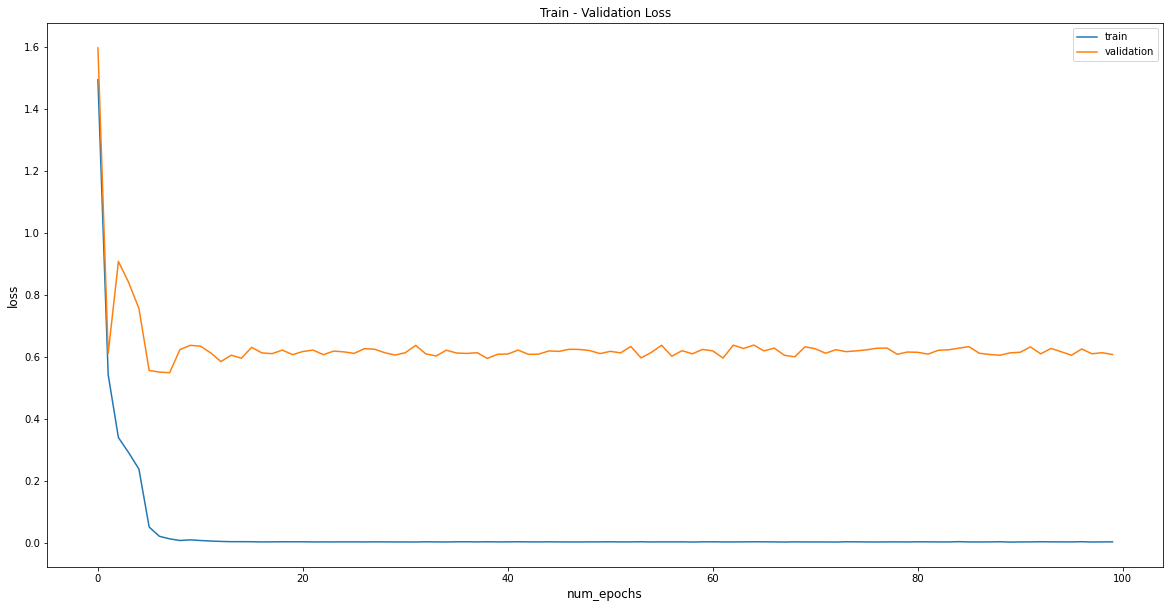

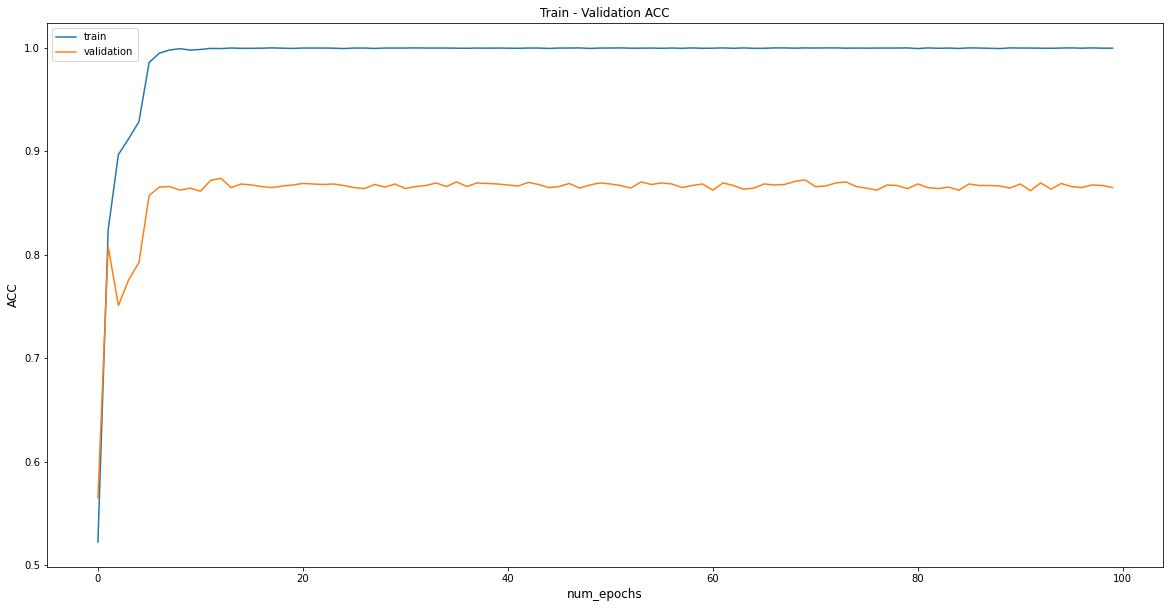

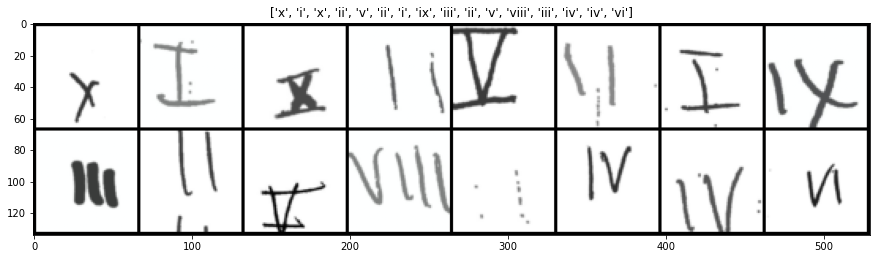

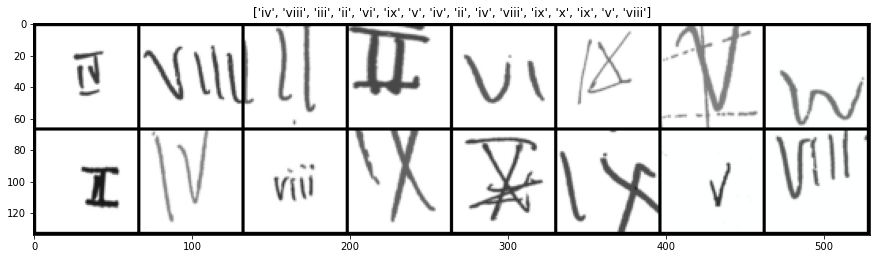

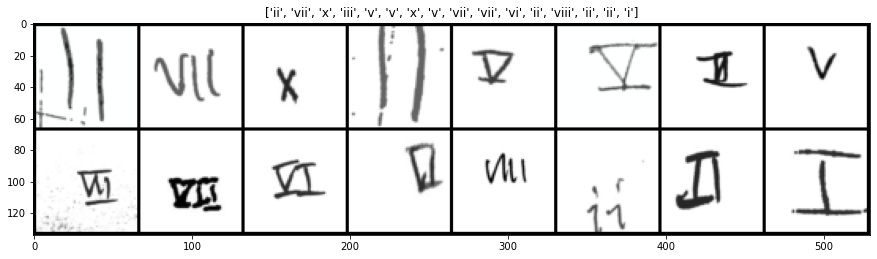

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 1.6216 Acc: 0.4839


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.40it/s]


val Loss: 1.5642 Acc: 0.5485

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.5882 Acc: 0.8110


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 1.0999 Acc: 0.7460

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.3843 Acc: 0.8781


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.41it/s]


val Loss: 0.7769 Acc: 0.7940

Epoch 4/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.3091 Acc: 0.9024


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.53it/s]


val Loss: 1.4677 Acc: 0.6745

Epoch 5/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.1979 Acc: 0.9375


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.83it/s]


val Loss: 0.7466 Acc: 0.7970

Epoch 6/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0597 Acc: 0.9828


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.3979 Acc: 0.8770

Epoch 7/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.11it/s]


train Loss: 0.0266 Acc: 0.9924


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.4133 Acc: 0.8890

Epoch 8/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0172 Acc: 0.9958


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.4198 Acc: 0.8860

Epoch 9/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0163 Acc: 0.9951


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.62it/s]


val Loss: 0.4340 Acc: 0.8860

Epoch 10/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0129 Acc: 0.9964


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.45it/s]


val Loss: 0.5046 Acc: 0.8800

Epoch 11/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0087 Acc: 0.9974


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.85it/s]


val Loss: 0.4562 Acc: 0.8860

Epoch 12/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.08it/s]


train Loss: 0.0064 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.43it/s]


val Loss: 0.4744 Acc: 0.8875

Epoch 13/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0055 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.4430 Acc: 0.8955

Epoch 14/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0049 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.63it/s]


val Loss: 0.4678 Acc: 0.8895

Epoch 15/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0033 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4779 Acc: 0.8915

Epoch 16/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0033 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.17it/s]


val Loss: 0.4969 Acc: 0.8875

Epoch 17/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0028 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.4855 Acc: 0.8925

Epoch 18/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0030 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.41it/s]


val Loss: 0.4868 Acc: 0.8930

Epoch 19/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 0.0029 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.4768 Acc: 0.8895

Epoch 20/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0036 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.56it/s]


val Loss: 0.4914 Acc: 0.8900

Epoch 21/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.84it/s]


train Loss: 0.0033 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.12it/s]


val Loss: 0.4761 Acc: 0.8925

Epoch 22/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0034 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.46it/s]


val Loss: 0.5036 Acc: 0.8910

Epoch 23/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.68it/s]


val Loss: 0.5005 Acc: 0.8930

Epoch 24/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0034 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.4923 Acc: 0.8920

Epoch 25/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0029 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.4825 Acc: 0.8940

Epoch 26/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.06it/s]


train Loss: 0.0029 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.57it/s]


val Loss: 0.4822 Acc: 0.8920

Epoch 27/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0025 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.85it/s]


val Loss: 0.4881 Acc: 0.8900

Epoch 28/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0040 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.4751 Acc: 0.8930

Epoch 29/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.12it/s]


train Loss: 0.0033 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.87it/s]


val Loss: 0.4833 Acc: 0.8935

Epoch 30/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0030 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.4608 Acc: 0.8910

Epoch 31/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0029 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4817 Acc: 0.8925

Epoch 32/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0027 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.50it/s]


val Loss: 0.4969 Acc: 0.8850

Epoch 33/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0029 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.4905 Acc: 0.8930

Epoch 34/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0034 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.12it/s]


val Loss: 0.4728 Acc: 0.8930

Epoch 35/100
----------


  5%|███▍                                                                    | 24/500 [00:02<00:41, 11.43it/s]Bad pipe message: %s [b'\x01]c\xdf)t\x9dO\x1d\xc0\x8c\xf2@!\xa9\x01`\xb9 W\xf4\xf6t\xdfH\xa5+\xfb\xfb~E\x99J\x9c .\xe9\xd2\xef9\x92\xa4Y\xde-\xce\xc39>\xca\x1a\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.']
Bad pipe message: %s [b'\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08']
Bad pipe message: %s [b'\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x99\x12#\xb2\xe00\x06A\x91\x10\xae\xda\xb8\x97\x940,\x90\x88({\x9c']
Bad pipe message: %s [b"\x0f%\xfc\x10&F\xdc\x12\xbe\xec\x91\x08\x11\xf1\x88\x97cw\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\

train Loss: 0.0027 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.71it/s]


val Loss: 0.4850 Acc: 0.8895

Epoch 36/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0031 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.86it/s]


val Loss: 0.4698 Acc: 0.8915

Epoch 37/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0026 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.4847 Acc: 0.8905

Epoch 38/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0032 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.43it/s]


val Loss: 0.4876 Acc: 0.8920

Epoch 39/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0031 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.4645 Acc: 0.8950

Epoch 40/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0024 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.4811 Acc: 0.8930

Epoch 41/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0026 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.03it/s]


val Loss: 0.4816 Acc: 0.8920

Epoch 42/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0033 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.57it/s]


val Loss: 0.4847 Acc: 0.8905

Epoch 43/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0032 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.11it/s]


val Loss: 0.4944 Acc: 0.8895

Epoch 44/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0036 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4706 Acc: 0.8930

Epoch 45/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0030 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.4859 Acc: 0.8940

Epoch 46/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0028 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.4829 Acc: 0.8925

Epoch 47/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0033 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.53it/s]


val Loss: 0.4957 Acc: 0.8875

Epoch 48/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0033 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.4878 Acc: 0.8905

Epoch 49/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0028 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.98it/s]


val Loss: 0.5019 Acc: 0.8885

Epoch 50/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0030 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.74it/s]


val Loss: 0.4903 Acc: 0.8920

Epoch 51/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0030 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.12it/s]


val Loss: 0.4823 Acc: 0.8895

Epoch 52/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0032 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.63it/s]


val Loss: 0.4841 Acc: 0.8940

Epoch 53/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0030 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.55it/s]


val Loss: 0.4858 Acc: 0.8895

Epoch 54/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0025 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.68it/s]


val Loss: 0.4629 Acc: 0.8920

Epoch 55/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0030 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.23it/s]


val Loss: 0.4961 Acc: 0.8900

Epoch 56/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0032 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.95it/s]


val Loss: 0.5080 Acc: 0.8890

Epoch 57/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0046 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.4800 Acc: 0.8920

Epoch 58/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.4937 Acc: 0.8920

Epoch 59/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0032 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 25.00it/s]


val Loss: 0.4788 Acc: 0.8915

Epoch 60/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0029 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.4795 Acc: 0.8925

Epoch 61/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0031 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.4730 Acc: 0.8930

Epoch 62/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0029 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.71it/s]


val Loss: 0.4761 Acc: 0.8930

Epoch 63/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0036 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.17it/s]


val Loss: 0.5063 Acc: 0.8920

Epoch 64/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0025 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.80it/s]


val Loss: 0.4872 Acc: 0.8885

Epoch 65/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.99it/s]


val Loss: 0.4898 Acc: 0.8910

Epoch 66/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0025 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.42it/s]


val Loss: 0.4755 Acc: 0.8905

Epoch 67/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0037 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.4982 Acc: 0.8905

Epoch 68/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0028 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.71it/s]


val Loss: 0.4740 Acc: 0.8925

Epoch 69/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.12it/s]


train Loss: 0.0030 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.4688 Acc: 0.8950

Epoch 70/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0027 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.95it/s]


val Loss: 0.4933 Acc: 0.8925

Epoch 71/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0034 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 22.90it/s]


val Loss: 0.4841 Acc: 0.8915

Epoch 72/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0027 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.4839 Acc: 0.8900

Epoch 73/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0030 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.05it/s]


val Loss: 0.4940 Acc: 0.8925

Epoch 74/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0035 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.4776 Acc: 0.8940

Epoch 75/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0027 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.5070 Acc: 0.8870

Epoch 76/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.4909 Acc: 0.8925

Epoch 77/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0034 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.4930 Acc: 0.8890

Epoch 78/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0030 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.14it/s]


val Loss: 0.4862 Acc: 0.8945

Epoch 79/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0036 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.4858 Acc: 0.8930

Epoch 80/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0024 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.4825 Acc: 0.8900

Epoch 81/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0032 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.4756 Acc: 0.8940

Epoch 82/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0036 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.4669 Acc: 0.8885

Epoch 83/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0028 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.21it/s]


val Loss: 0.4794 Acc: 0.8905

Epoch 84/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0028 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.46it/s]


val Loss: 0.4779 Acc: 0.8900

Epoch 85/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.09it/s]


train Loss: 0.0041 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5140 Acc: 0.8840

Epoch 86/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0027 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.4948 Acc: 0.8920

Epoch 87/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0032 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.85it/s]


val Loss: 0.4811 Acc: 0.8935

Epoch 88/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0028 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.4629 Acc: 0.8915

Epoch 89/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0032 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.42it/s]


val Loss: 0.4718 Acc: 0.8920

Epoch 90/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0026 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.10it/s]


val Loss: 0.4921 Acc: 0.8930

Epoch 91/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0027 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.4813 Acc: 0.8920

Epoch 92/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0024 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.80it/s]


val Loss: 0.5007 Acc: 0.8875

Epoch 93/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0030 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.4726 Acc: 0.8940

Epoch 94/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0031 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.10it/s]


val Loss: 0.4889 Acc: 0.8910

Epoch 95/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0030 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.4776 Acc: 0.8940

Epoch 96/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0032 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.4646 Acc: 0.8935

Epoch 97/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0032 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.11it/s]


val Loss: 0.4899 Acc: 0.8915

Epoch 98/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0026 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.85it/s]


val Loss: 0.4784 Acc: 0.8945

Epoch 99/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.12it/s]


train Loss: 0.0030 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.47it/s]


val Loss: 0.4850 Acc: 0.8925

Epoch 100/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0027 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.50it/s]


val Loss: 0.4748 Acc: 0.8910

Training complete in 82m 33s
Best val Acc: 0.895500
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


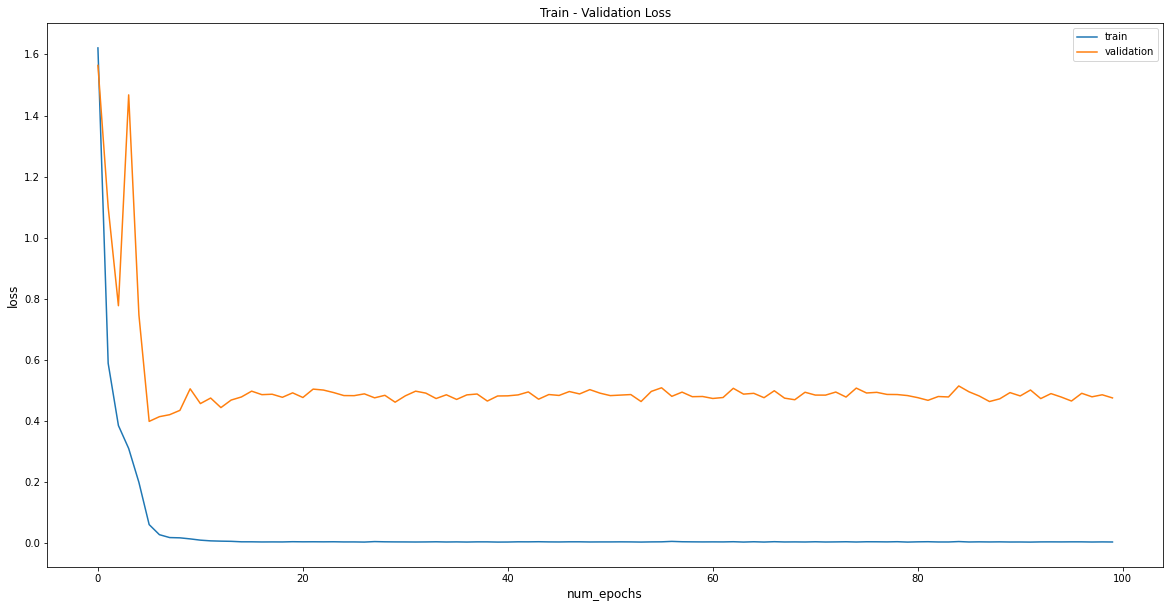

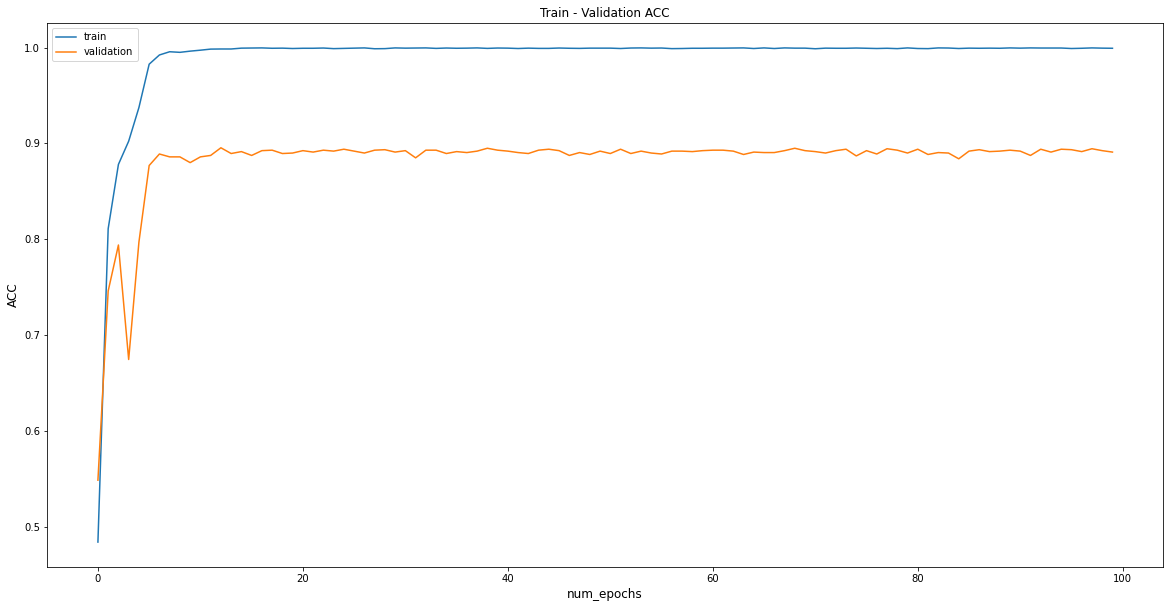

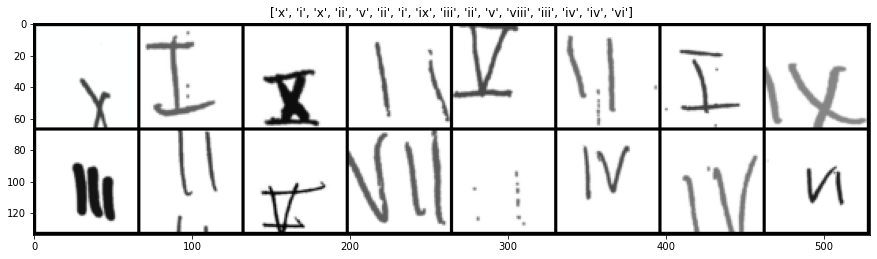

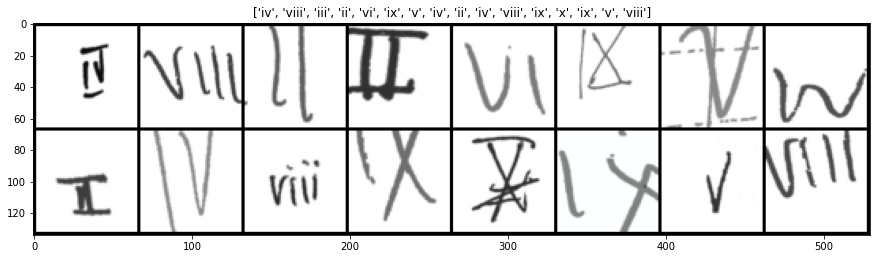

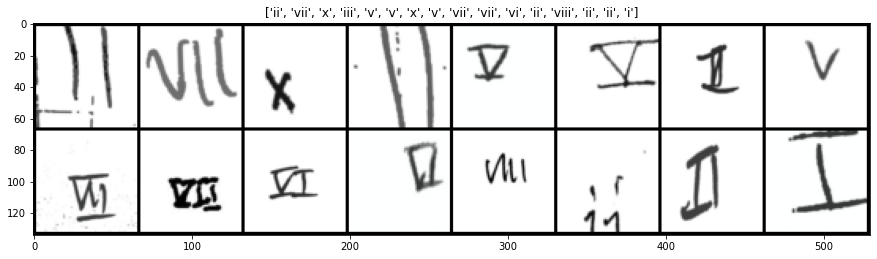

Epoch 1/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]


train Loss: 1.5671 Acc: 0.4944


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 1.1694 Acc: 0.6535

Epoch 2/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.6306 Acc: 0.7955


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.8760 Acc: 0.6985

Epoch 3/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.4174 Acc: 0.8658


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.7504 Acc: 0.7995

Epoch 4/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.3301 Acc: 0.8929


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.56it/s]


val Loss: 0.6615 Acc: 0.8305

Epoch 5/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.2542 Acc: 0.9188


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.6295 Acc: 0.8020

Epoch 6/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0738 Acc: 0.9770


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.52it/s]


val Loss: 0.4374 Acc: 0.8735

Epoch 7/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0357 Acc: 0.9895


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.03it/s]


val Loss: 0.4848 Acc: 0.8745

Epoch 8/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0226 Acc: 0.9951


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.4600 Acc: 0.8780

Epoch 9/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0172 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.5217 Acc: 0.8680

Epoch 10/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0126 Acc: 0.9970


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.5457 Acc: 0.8695

Epoch 11/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0084 Acc: 0.9981


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.5396 Acc: 0.8820

Epoch 12/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0073 Acc: 0.9980


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.74it/s]


val Loss: 0.5595 Acc: 0.8790

Epoch 13/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0060 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.5172 Acc: 0.8800

Epoch 14/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]


train Loss: 0.0046 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.5495 Acc: 0.8795

Epoch 15/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0043 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.96it/s]


val Loss: 0.5574 Acc: 0.8730

Epoch 16/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.5677 Acc: 0.8750

Epoch 17/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.05it/s]


train Loss: 0.0037 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.52it/s]


val Loss: 0.5655 Acc: 0.8775

Epoch 18/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0034 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5440 Acc: 0.8780

Epoch 19/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0046 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.52it/s]


val Loss: 0.5388 Acc: 0.8810

Epoch 20/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.5488 Acc: 0.8810

Epoch 21/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0038 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.5379 Acc: 0.8790

Epoch 22/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0035 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.5679 Acc: 0.8770

Epoch 23/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0032 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.85it/s]


val Loss: 0.5517 Acc: 0.8745

Epoch 24/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 0.0035 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.5477 Acc: 0.8775

Epoch 25/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0032 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.60it/s]


val Loss: 0.5576 Acc: 0.8755

Epoch 26/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0037 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.5444 Acc: 0.8790

Epoch 27/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0037 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.57it/s]


val Loss: 0.5532 Acc: 0.8815

Epoch 28/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.04it/s]


train Loss: 0.0038 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5380 Acc: 0.8820

Epoch 29/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0037 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.41it/s]


val Loss: 0.5376 Acc: 0.8820

Epoch 30/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0033 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.5485 Acc: 0.8770

Epoch 31/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0032 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.54it/s]


val Loss: 0.5558 Acc: 0.8790

Epoch 32/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0030 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.52it/s]


val Loss: 0.5671 Acc: 0.8780

Epoch 33/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0037 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.5423 Acc: 0.8790

Epoch 34/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0033 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.10it/s]


val Loss: 0.5238 Acc: 0.8785

Epoch 35/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0030 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.78it/s]


val Loss: 0.5423 Acc: 0.8810

Epoch 36/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0036 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.5290 Acc: 0.8815

Epoch 37/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0031 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5471 Acc: 0.8790

Epoch 38/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0040 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.5456 Acc: 0.8800

Epoch 39/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.10it/s]


train Loss: 0.0036 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.76it/s]


val Loss: 0.5320 Acc: 0.8765

Epoch 40/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0031 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.00it/s]


val Loss: 0.5494 Acc: 0.8760

Epoch 41/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0032 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.5338 Acc: 0.8770

Epoch 42/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.03it/s]


train Loss: 0.0033 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.5644 Acc: 0.8765

Epoch 43/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0034 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.01it/s]


val Loss: 0.5560 Acc: 0.8760

Epoch 44/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0031 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.03it/s]


val Loss: 0.5419 Acc: 0.8785

Epoch 45/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0044 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.61it/s]


val Loss: 0.5653 Acc: 0.8760

Epoch 46/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0036 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.63it/s]


val Loss: 0.5438 Acc: 0.8770

Epoch 47/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0032 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.90it/s]


val Loss: 0.5590 Acc: 0.8790

Epoch 48/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0037 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.90it/s]


val Loss: 0.5461 Acc: 0.8810

Epoch 49/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0032 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.01it/s]


val Loss: 0.5496 Acc: 0.8805

Epoch 50/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.12it/s]


train Loss: 0.0035 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.5674 Acc: 0.8725

Epoch 51/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0042 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.5524 Acc: 0.8755

Epoch 52/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0035 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.28it/s]


val Loss: 0.5402 Acc: 0.8775

Epoch 53/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0038 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5520 Acc: 0.8770

Epoch 54/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]


train Loss: 0.0037 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.5440 Acc: 0.8740

Epoch 55/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0038 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.76it/s]


val Loss: 0.5584 Acc: 0.8750

Epoch 56/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0033 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.23it/s]


val Loss: 0.5655 Acc: 0.8755

Epoch 57/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0033 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.98it/s]


val Loss: 0.5312 Acc: 0.8790

Epoch 58/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0033 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.74it/s]


val Loss: 0.5588 Acc: 0.8780

Epoch 59/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0036 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.94it/s]


val Loss: 0.5303 Acc: 0.8790

Epoch 60/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0039 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.73it/s]


val Loss: 0.5421 Acc: 0.8785

Epoch 61/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0039 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.43it/s]


val Loss: 0.5634 Acc: 0.8750

Epoch 62/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0033 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.65it/s]


val Loss: 0.5456 Acc: 0.8775

Epoch 63/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0040 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.5563 Acc: 0.8745

Epoch 64/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0034 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.89it/s]


val Loss: 0.5601 Acc: 0.8785

Epoch 65/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0036 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.98it/s]


val Loss: 0.5662 Acc: 0.8765

Epoch 66/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0037 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.67it/s]


val Loss: 0.5521 Acc: 0.8805

Epoch 67/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.23it/s]


train Loss: 0.0034 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.70it/s]


val Loss: 0.5501 Acc: 0.8765

Epoch 68/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0030 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.20it/s]


val Loss: 0.5390 Acc: 0.8790

Epoch 69/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0030 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.5364 Acc: 0.8785

Epoch 70/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0033 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.58it/s]


val Loss: 0.5490 Acc: 0.8730

Epoch 71/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0035 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.69it/s]


val Loss: 0.5656 Acc: 0.8765

Epoch 72/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0030 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.24it/s]


val Loss: 0.5531 Acc: 0.8785

Epoch 73/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0037 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.74it/s]


val Loss: 0.5553 Acc: 0.8765

Epoch 74/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.09it/s]


train Loss: 0.0033 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.75it/s]


val Loss: 0.5632 Acc: 0.8755

Epoch 75/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.02it/s]


train Loss: 0.0042 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.47it/s]


val Loss: 0.5543 Acc: 0.8765

Epoch 76/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.13it/s]


train Loss: 0.0034 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.28it/s]


val Loss: 0.5571 Acc: 0.8755

Epoch 77/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0034 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.07it/s]


val Loss: 0.5404 Acc: 0.8800

Epoch 78/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0038 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.88it/s]


val Loss: 0.5525 Acc: 0.8795

Epoch 79/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0034 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.17it/s]


val Loss: 0.5361 Acc: 0.8790

Epoch 80/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0032 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.13it/s]


val Loss: 0.5418 Acc: 0.8815

Epoch 81/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.92it/s]


val Loss: 0.5318 Acc: 0.8800

Epoch 82/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.91it/s]


val Loss: 0.5384 Acc: 0.8800

Epoch 83/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0030 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5447 Acc: 0.8775

Epoch 84/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0036 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5539 Acc: 0.8775

Epoch 85/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0045 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.71it/s]


val Loss: 0.5560 Acc: 0.8805

Epoch 86/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0039 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5524 Acc: 0.8770

Epoch 87/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0041 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.04it/s]


val Loss: 0.5346 Acc: 0.8800

Epoch 88/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0034 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.60it/s]


val Loss: 0.5531 Acc: 0.8770

Epoch 89/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0035 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.56it/s]


val Loss: 0.5392 Acc: 0.8795

Epoch 90/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.19it/s]


train Loss: 0.0033 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.76it/s]


val Loss: 0.5343 Acc: 0.8775

Epoch 91/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.07it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.79it/s]


val Loss: 0.5442 Acc: 0.8800

Epoch 92/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.05it/s]


train Loss: 0.0031 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.60it/s]


val Loss: 0.5632 Acc: 0.8765

Epoch 93/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0038 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.60it/s]


val Loss: 0.5407 Acc: 0.8775

Epoch 94/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0031 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.77it/s]


val Loss: 0.5541 Acc: 0.8810

Epoch 95/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0035 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.17it/s]


val Loss: 0.5452 Acc: 0.8785

Epoch 96/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0034 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.35it/s]


val Loss: 0.5400 Acc: 0.8805

Epoch 97/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0035 Acc: 0.9999


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.23it/s]


val Loss: 0.5487 Acc: 0.8800

Epoch 98/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.44it/s]


train Loss: 0.0040 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.5495 Acc: 0.8785

Epoch 99/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.43it/s]


val Loss: 0.5575 Acc: 0.8760

Epoch 100/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0033 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.21it/s]


val Loss: 0.5363 Acc: 0.8780

Training complete in 82m 34s
Best val Acc: 0.882000


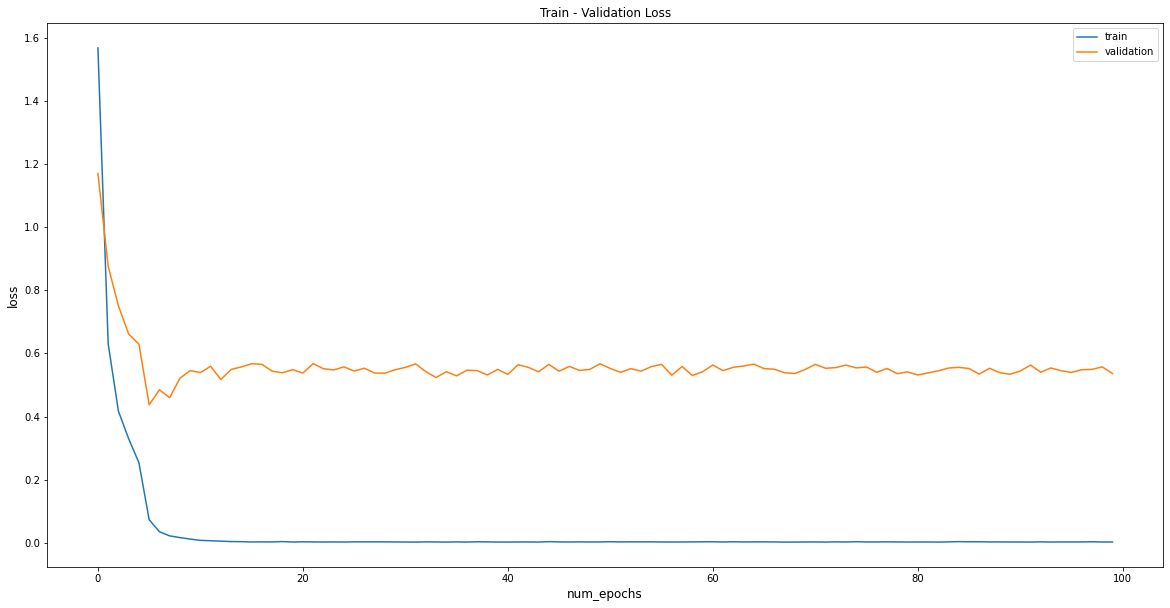

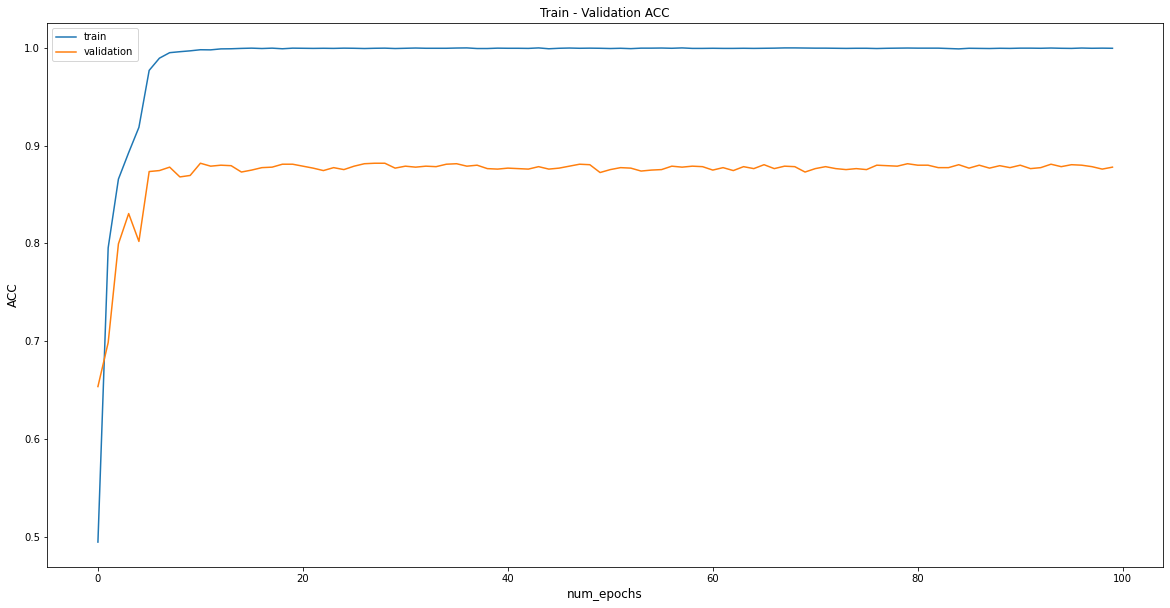

In [ ]:
# define a list of augmentations
aug_seqs = ["None",
            iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))), iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}), iaa.ShearX((-15, 15),cval=255), iaa.PiecewiseAffine(scale=(0.03, 0.05)), iaa.PerspectiveTransform(scale=(0.01, 0.12))]),
            iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))),iaa.ShearX((-15, 15),cval=255),iaa.PerspectiveTransform(scale=(0.01, 0.12))]),
            iaa.Sequential([iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}),iaa.PiecewiseAffine(scale=(0.03, 0.05))]),
            iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))),iaa.PerspectiveTransform(scale=(0.01, 0.12))]),
            iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))),iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}),iaa.PerspectiveTransform(scale=(0.01, 0.12))])]


val_accuracy = []  # save validation accuracy for each augmentation sequence
num_label_train = 800 # 80% of data is for train, so train has 800 images of each label
num_label_val = 1000 - num_label_train


for seq in aug_seqs:
    if seq != "None":
        # augement data using seq
        augment_train_val(seq, num_label_train, num_label_val)
    else:
        # use the data without any augmentation
        copy_train_val()
        
    %run run_train_eval.py
    val_accuracy.append(test_accuracy())
    delete_augs()

In [ ]:
# compare the validation accuracies of all augmentation types
print([acc.item() for acc in val_accuracy])

[0.8560000658035278, 0.940000057220459, 0.9360000491142273, 0.9320000410079956, 0.9440000653266907, 0.9520000219345093]


Above we can see the validation accuracy (of the first validation set) of all of the augmentation combinations we have tried. The list of augmentations and the combinations can be seen in the first rows of the above code cell. <br>
As we can see, the last augmentation which used Brightness+Affine+PerspectiveTransform got the best validation accuracy. Therefore, we will use this augmentation to create our final dataset. 

# Train-Validation Split

Using the selected augmentation, we look for the best split between train and validation while training the model. Because we are limited to 10k images in total, again each label will have exactly 1000 images - some for train and some for validation. For example, a 0.5-0.5 split means that validation and train each has 500 images per label.

Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


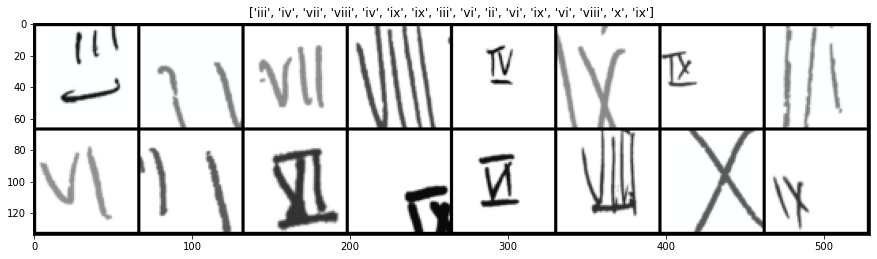

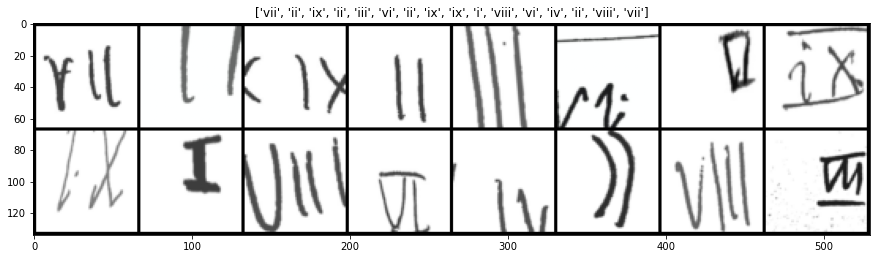

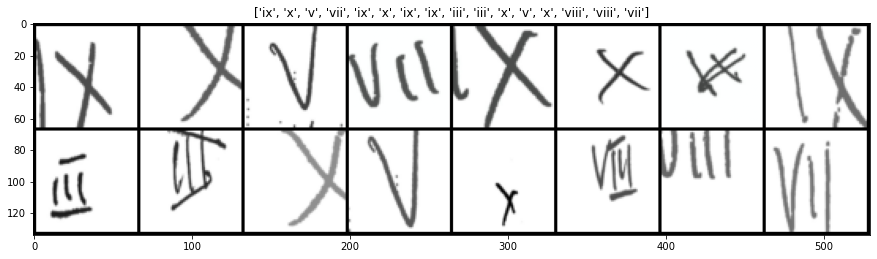

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:50<00:00, 11.21it/s]


train Loss: 1.5948 Acc: 0.4776


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.21it/s]


val Loss: 1.4466 Acc: 0.6280

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.41it/s]


train Loss: 0.6090 Acc: 0.7984


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.38it/s]


val Loss: 0.7279 Acc: 0.7570

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.4215 Acc: 0.8639


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.32it/s]


val Loss: 0.7518 Acc: 0.8000

Epoch 4/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.2981 Acc: 0.9100


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.37it/s]


val Loss: 0.6023 Acc: 0.8390

Epoch 5/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.2430 Acc: 0.9229


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.21it/s]


val Loss: 0.5878 Acc: 0.8450

Epoch 6/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.41it/s]


train Loss: 0.0732 Acc: 0.9776


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.90it/s]


val Loss: 0.5682 Acc: 0.8760

Epoch 7/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0365 Acc: 0.9899


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.25it/s]


val Loss: 0.6037 Acc: 0.8680

Epoch 8/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0249 Acc: 0.9927


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.18it/s]


val Loss: 0.5924 Acc: 0.8780

Epoch 9/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.39it/s]


train Loss: 0.0165 Acc: 0.9956


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.39it/s]


val Loss: 0.6472 Acc: 0.8850

Epoch 10/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0142 Acc: 0.9961


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.16it/s]


val Loss: 0.7133 Acc: 0.8780

Epoch 11/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0099 Acc: 0.9971


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.36it/s]


val Loss: 0.6861 Acc: 0.8800

Epoch 12/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0064 Acc: 0.9982


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.32it/s]


val Loss: 0.6995 Acc: 0.8780

Epoch 13/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0051 Acc: 0.9991


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.29it/s]


val Loss: 0.7101 Acc: 0.8790

Epoch 14/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0040 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.46it/s]


val Loss: 0.7045 Acc: 0.8850

Epoch 15/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.40it/s]


train Loss: 0.0039 Acc: 0.9992


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.47it/s]


val Loss: 0.7053 Acc: 0.8830

Epoch 16/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0041 Acc: 0.9989


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.60it/s]


val Loss: 0.7109 Acc: 0.8850

Epoch 17/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0034 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.39it/s]


val Loss: 0.7257 Acc: 0.8810

Epoch 18/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0025 Acc: 0.9999


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.58it/s]


val Loss: 0.7125 Acc: 0.8810

Epoch 19/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0031 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.62it/s]


val Loss: 0.7082 Acc: 0.8800

Epoch 20/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0029 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.35it/s]


val Loss: 0.7239 Acc: 0.8860

Epoch 21/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0032 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.40it/s]


val Loss: 0.7001 Acc: 0.8850

Epoch 22/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0029 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.10it/s]


val Loss: 0.6989 Acc: 0.8780

Epoch 23/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0028 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.54it/s]


val Loss: 0.7486 Acc: 0.8800

Epoch 24/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0032 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.32it/s]


val Loss: 0.7104 Acc: 0.8810

Epoch 25/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0025 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.46it/s]


val Loss: 0.7270 Acc: 0.8860

Epoch 26/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.48it/s]


train Loss: 0.0029 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.45it/s]


val Loss: 0.7324 Acc: 0.8850

Epoch 27/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0032 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.45it/s]


val Loss: 0.7105 Acc: 0.8830

Epoch 28/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.48it/s]


train Loss: 0.0026 Acc: 0.9999


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.18it/s]


val Loss: 0.7247 Acc: 0.8820

Epoch 29/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0028 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.42it/s]


val Loss: 0.7177 Acc: 0.8800

Epoch 30/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0028 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.57it/s]


val Loss: 0.7185 Acc: 0.8850

Epoch 31/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.48it/s]


train Loss: 0.0027 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.42it/s]


val Loss: 0.7423 Acc: 0.8780

Epoch 32/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.49it/s]


train Loss: 0.0028 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.47it/s]


val Loss: 0.7160 Acc: 0.8830

Epoch 33/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0025 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.66it/s]


val Loss: 0.7376 Acc: 0.8810

Epoch 34/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0024 Acc: 0.9999


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.62it/s]


val Loss: 0.7165 Acc: 0.8830

Epoch 35/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.49it/s]


train Loss: 0.0025 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.20it/s]


val Loss: 0.6953 Acc: 0.8790

Epoch 36/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0028 Acc: 0.9991


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.06it/s]


val Loss: 0.7176 Acc: 0.8820

Epoch 37/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0027 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.49it/s]


val Loss: 0.7217 Acc: 0.8830

Epoch 38/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0026 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.43it/s]


val Loss: 0.7266 Acc: 0.8800

Epoch 39/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0030 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.38it/s]


val Loss: 0.7025 Acc: 0.8840

Epoch 40/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0030 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.47it/s]


val Loss: 0.7048 Acc: 0.8850

Epoch 41/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0026 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.60it/s]


val Loss: 0.7136 Acc: 0.8780

Epoch 42/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0031 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.21it/s]


val Loss: 0.7201 Acc: 0.8850

Epoch 43/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0027 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.58it/s]


val Loss: 0.7078 Acc: 0.8810

Epoch 44/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0026 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.46it/s]


val Loss: 0.7251 Acc: 0.8820

Epoch 45/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0033 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.37it/s]


val Loss: 0.7227 Acc: 0.8830

Epoch 46/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0027 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.57it/s]


val Loss: 0.7045 Acc: 0.8810

Epoch 47/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.48it/s]


train Loss: 0.0025 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.39it/s]


val Loss: 0.7192 Acc: 0.8840

Epoch 48/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0032 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.38it/s]


val Loss: 0.7275 Acc: 0.8820

Epoch 49/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.46it/s]


train Loss: 0.0027 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.42it/s]


val Loss: 0.7153 Acc: 0.8810

Epoch 50/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.47it/s]


train Loss: 0.0025 Acc: 0.9999


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.61it/s]


val Loss: 0.7278 Acc: 0.8850

Epoch 51/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.41it/s]


train Loss: 0.0028 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.26it/s]


val Loss: 0.7176 Acc: 0.8810

Epoch 52/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.41it/s]


train Loss: 0.0028 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.54it/s]


val Loss: 0.7165 Acc: 0.8830

Epoch 53/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0027 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.27it/s]


val Loss: 0.7407 Acc: 0.8820

Epoch 54/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.41it/s]


train Loss: 0.0026 Acc: 0.9999


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.00it/s]


val Loss: 0.7245 Acc: 0.8780

Epoch 55/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0029 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.29it/s]


val Loss: 0.7304 Acc: 0.8850

Epoch 56/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.41it/s]


train Loss: 0.0035 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.40it/s]


val Loss: 0.7338 Acc: 0.8820

Epoch 57/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0028 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.42it/s]


val Loss: 0.7342 Acc: 0.8820

Epoch 58/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0026 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.49it/s]


val Loss: 0.6984 Acc: 0.8800

Epoch 59/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.40it/s]


train Loss: 0.0030 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.47it/s]


val Loss: 0.7461 Acc: 0.8840

Epoch 60/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.37it/s]


train Loss: 0.0033 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.15it/s]


val Loss: 0.7180 Acc: 0.8830

Epoch 61/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.39it/s]


train Loss: 0.0036 Acc: 0.9992


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.53it/s]


val Loss: 0.7011 Acc: 0.8830

Epoch 62/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0023 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.38it/s]


val Loss: 0.7223 Acc: 0.8830

Epoch 63/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0032 Acc: 0.9990


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.17it/s]


val Loss: 0.7242 Acc: 0.8800

Epoch 64/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0027 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.31it/s]


val Loss: 0.7226 Acc: 0.8830

Epoch 65/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.37it/s]


train Loss: 0.0034 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.36it/s]


val Loss: 0.7235 Acc: 0.8780

Epoch 66/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0025 Acc: 0.9999


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.50it/s]


val Loss: 0.7358 Acc: 0.8800

Epoch 67/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0029 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.21it/s]


val Loss: 0.7129 Acc: 0.8850

Epoch 68/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0024 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.23it/s]


val Loss: 0.7268 Acc: 0.8820

Epoch 69/100
----------


  9%|██████▍                                                                 | 50/563 [00:04<00:44, 11.51it/s]Bad pipe message: %s [b'\xe3\x9c\xc3\xfbMQ\xcb\xa9\x11t\x14\xe1N\xf0\x8eO/\x11 \xd7. \xd1\x84\xfaoa:\xe7\xa8@]\xa1\x83I?\xfe`E\x91\xf6$\xd5\xc3\x8b\x86fi\xa5\xce\xe4\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e']
Bad pipe message: %s [b"v\xa3\x97\xa5\x1fA\xc2-'\xd6$\xa3\xca\xf6Y\xd4\xb8\x18\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x

train Loss: 0.0032 Acc: 0.9992


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.34it/s]


val Loss: 0.7267 Acc: 0.8800

Epoch 70/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.45it/s]


train Loss: 0.0031 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.39it/s]


val Loss: 0.7324 Acc: 0.8860

Epoch 71/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0034 Acc: 0.9991


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.09it/s]


val Loss: 0.7102 Acc: 0.8780

Epoch 72/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.27it/s]


train Loss: 0.0030 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.28it/s]


val Loss: 0.7096 Acc: 0.8840

Epoch 73/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.27it/s]


train Loss: 0.0029 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.16it/s]


val Loss: 0.7284 Acc: 0.8850

Epoch 74/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0036 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.51it/s]


val Loss: 0.7102 Acc: 0.8830

Epoch 75/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0031 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.46it/s]


val Loss: 0.7247 Acc: 0.8780

Epoch 76/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0030 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.50it/s]


val Loss: 0.7395 Acc: 0.8780

Epoch 77/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.36it/s]


train Loss: 0.0030 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.31it/s]


val Loss: 0.7208 Acc: 0.8850

Epoch 78/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.38it/s]


train Loss: 0.0026 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.46it/s]


val Loss: 0.7240 Acc: 0.8800

Epoch 79/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.34it/s]


train Loss: 0.0027 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.29it/s]


val Loss: 0.7251 Acc: 0.8780

Epoch 80/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.31it/s]


train Loss: 0.0037 Acc: 0.9994


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.47it/s]


val Loss: 0.7067 Acc: 0.8810

Epoch 81/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.27it/s]


train Loss: 0.0023 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.97it/s]


val Loss: 0.7109 Acc: 0.8820

Epoch 82/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.29it/s]


train Loss: 0.0026 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.33it/s]


val Loss: 0.7176 Acc: 0.8800

Epoch 83/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.35it/s]


train Loss: 0.0037 Acc: 0.9992


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.48it/s]


val Loss: 0.7296 Acc: 0.8830

Epoch 84/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.44it/s]


train Loss: 0.0029 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.44it/s]


val Loss: 0.7176 Acc: 0.8820

Epoch 85/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.34it/s]


train Loss: 0.0031 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.14it/s]


val Loss: 0.7292 Acc: 0.8840

Epoch 86/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.43it/s]


train Loss: 0.0026 Acc: 0.9993


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.11it/s]


val Loss: 0.7194 Acc: 0.8830

Epoch 87/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:50<00:00, 11.17it/s]


train Loss: 0.0029 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.95it/s]


val Loss: 0.7388 Acc: 0.8790

Epoch 88/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.38it/s]


train Loss: 0.0038 Acc: 0.9990


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.16it/s]


val Loss: 0.7105 Acc: 0.8820

Epoch 89/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.27it/s]


train Loss: 0.0049 Acc: 0.9991


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.54it/s]


val Loss: 0.7348 Acc: 0.8810

Epoch 90/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:50<00:00, 11.14it/s]


train Loss: 0.0032 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.82it/s]


val Loss: 0.7394 Acc: 0.8800

Epoch 91/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.40it/s]


train Loss: 0.0026 Acc: 0.9999


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.33it/s]


val Loss: 0.7566 Acc: 0.8780

Epoch 92/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0036 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.42it/s]


val Loss: 0.7265 Acc: 0.8790

Epoch 93/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.40it/s]


train Loss: 0.0035 Acc: 0.9991


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.31it/s]


val Loss: 0.7245 Acc: 0.8780

Epoch 94/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.42it/s]


train Loss: 0.0032 Acc: 0.9990


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.86it/s]


val Loss: 0.7374 Acc: 0.8830

Epoch 95/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.39it/s]


train Loss: 0.0023 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.97it/s]


val Loss: 0.7257 Acc: 0.8840

Epoch 96/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.37it/s]


train Loss: 0.0028 Acc: 0.9996


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.55it/s]


val Loss: 0.7271 Acc: 0.8840

Epoch 97/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.35it/s]


train Loss: 0.0028 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.01it/s]


val Loss: 0.7203 Acc: 0.8850

Epoch 98/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.33it/s]


train Loss: 0.0029 Acc: 0.9998


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.34it/s]


val Loss: 0.7305 Acc: 0.8790

Epoch 99/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.33it/s]


train Loss: 0.0025 Acc: 0.9997


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.46it/s]


val Loss: 0.7224 Acc: 0.8780

Epoch 100/100
----------


100%|███████████████████████████████████████████████████████████████████████| 563/563 [00:49<00:00, 11.40it/s]


train Loss: 0.0030 Acc: 0.9992


100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.44it/s]


val Loss: 0.7146 Acc: 0.8840

Training complete in 86m 24s
Best val Acc: 0.886000
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


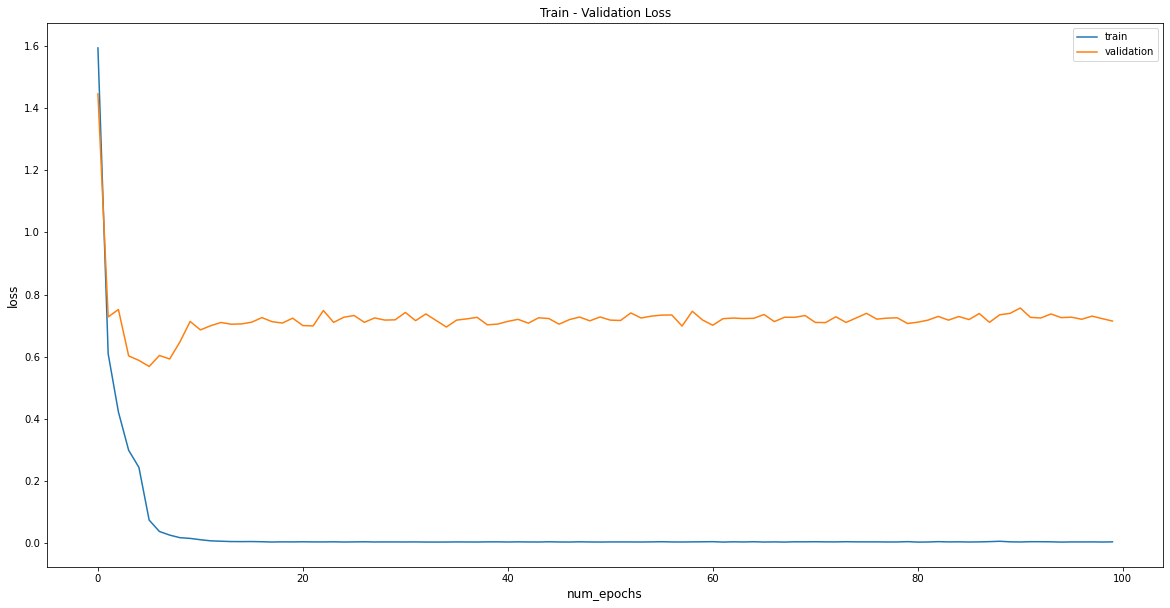

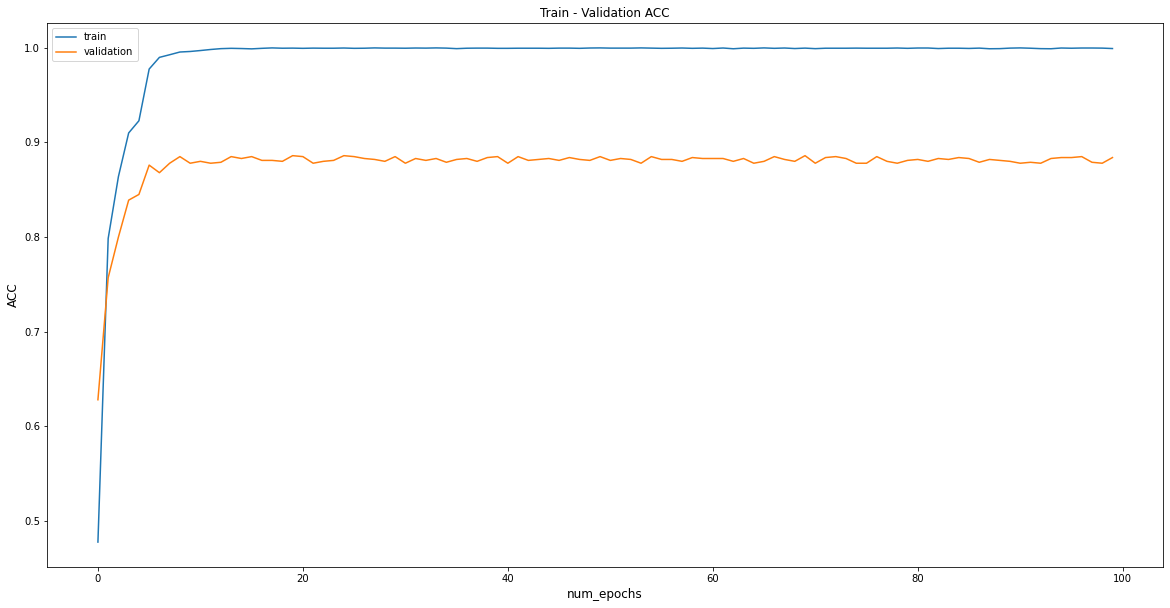

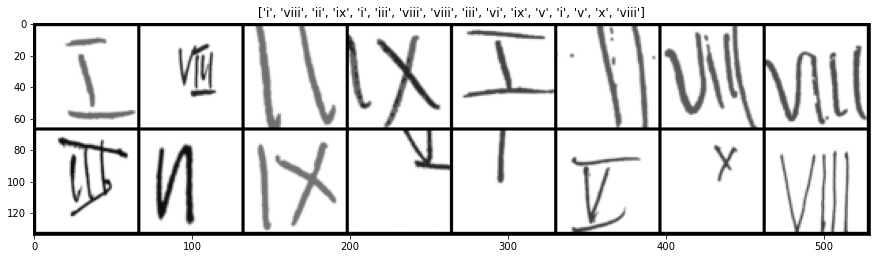

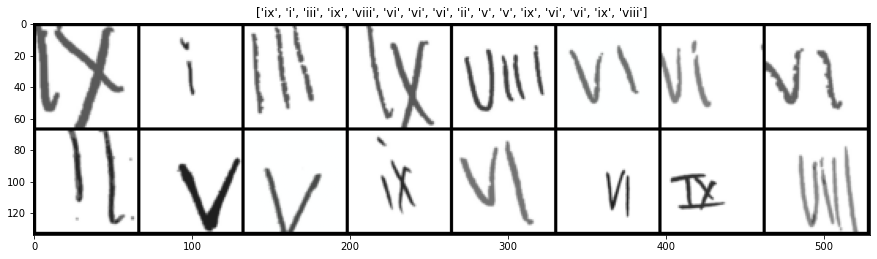

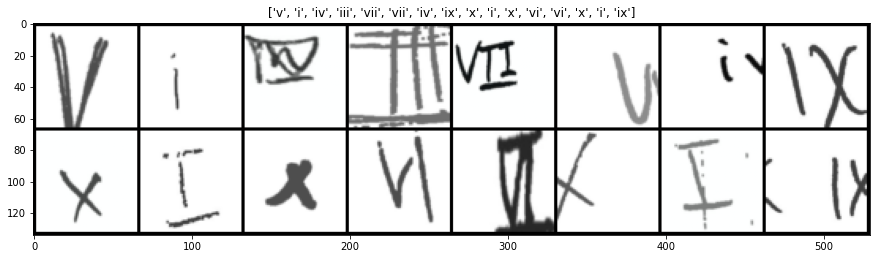

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 1.8789 Acc: 0.3811


100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.25it/s]


val Loss: 1.1337 Acc: 0.6240

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.31it/s]


train Loss: 0.7775 Acc: 0.7468


100%|█████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.72it/s]


val Loss: 1.4390 Acc: 0.6120

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.37it/s]


train Loss: 0.4993 Acc: 0.8352


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.39it/s]


val Loss: 0.7086 Acc: 0.8100

Epoch 4/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.3679 Acc: 0.8833


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.48it/s]


val Loss: 0.6776 Acc: 0.8100

Epoch 5/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.33it/s]


train Loss: 0.2558 Acc: 0.9184


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.65it/s]


val Loss: 0.9482 Acc: 0.7540

Epoch 6/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.33it/s]


train Loss: 0.0744 Acc: 0.9776


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.67it/s]


val Loss: 0.4675 Acc: 0.8660

Epoch 7/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.33it/s]


train Loss: 0.0391 Acc: 0.9875


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.69it/s]


val Loss: 0.4625 Acc: 0.8820

Epoch 8/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.39it/s]


train Loss: 0.0254 Acc: 0.9925


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.62it/s]


val Loss: 0.5173 Acc: 0.8800

Epoch 9/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.39it/s]


train Loss: 0.0217 Acc: 0.9929


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.32it/s]


val Loss: 0.5475 Acc: 0.8680

Epoch 10/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 0.0160 Acc: 0.9956


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.65it/s]


val Loss: 0.6068 Acc: 0.8740

Epoch 11/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0118 Acc: 0.9960


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.30it/s]


val Loss: 0.5671 Acc: 0.8760

Epoch 12/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.32it/s]


train Loss: 0.0070 Acc: 0.9984


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.67it/s]


val Loss: 0.5704 Acc: 0.8820

Epoch 13/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.35it/s]


train Loss: 0.0051 Acc: 0.9992


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.50it/s]


val Loss: 0.6054 Acc: 0.8760

Epoch 14/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.27it/s]


train Loss: 0.0051 Acc: 0.9983


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.61it/s]


val Loss: 0.5895 Acc: 0.8800

Epoch 15/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.26it/s]


train Loss: 0.0057 Acc: 0.9986


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.62it/s]


val Loss: 0.5995 Acc: 0.8740

Epoch 16/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.20it/s]


train Loss: 0.0044 Acc: 0.9991


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.37it/s]


val Loss: 0.6134 Acc: 0.8800

Epoch 17/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.19it/s]


train Loss: 0.0034 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.70it/s]


val Loss: 0.6091 Acc: 0.8740

Epoch 18/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.33it/s]


train Loss: 0.0041 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.04it/s]


val Loss: 0.6258 Acc: 0.8840

Epoch 19/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.34it/s]


train Loss: 0.0042 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.80it/s]


val Loss: 0.6050 Acc: 0.8740

Epoch 20/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.32it/s]


train Loss: 0.0035 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.68it/s]


val Loss: 0.5967 Acc: 0.8820

Epoch 21/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0038 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.66it/s]


val Loss: 0.6249 Acc: 0.8720

Epoch 22/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.30it/s]


train Loss: 0.0032 Acc: 0.9997


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.81it/s]


val Loss: 0.6301 Acc: 0.8740

Epoch 23/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.39it/s]


train Loss: 0.0040 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.59it/s]


val Loss: 0.6059 Acc: 0.8760

Epoch 24/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0031 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.74it/s]


val Loss: 0.6233 Acc: 0.8780

Epoch 25/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0034 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.93it/s]


val Loss: 0.6296 Acc: 0.8780

Epoch 26/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 0.0038 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.58it/s]


val Loss: 0.6396 Acc: 0.8720

Epoch 27/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0037 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.51it/s]


val Loss: 0.6063 Acc: 0.8840

Epoch 28/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.30it/s]


train Loss: 0.0033 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.89it/s]


val Loss: 0.5892 Acc: 0.8820

Epoch 29/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0037 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.64it/s]


val Loss: 0.6223 Acc: 0.8780

Epoch 30/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.03it/s]


train Loss: 0.0035 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.23it/s]


val Loss: 0.6132 Acc: 0.8780

Epoch 31/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.29it/s]


train Loss: 0.0035 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.52it/s]


val Loss: 0.6408 Acc: 0.8680

Epoch 32/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0029 Acc: 0.9997


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.70it/s]


val Loss: 0.6104 Acc: 0.8800

Epoch 33/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.35it/s]


train Loss: 0.0032 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.38it/s]


val Loss: 0.6053 Acc: 0.8840

Epoch 34/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.28it/s]


train Loss: 0.0035 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.16it/s]


val Loss: 0.6310 Acc: 0.8780

Epoch 35/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.32it/s]


train Loss: 0.0038 Acc: 0.9989


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.29it/s]


val Loss: 0.6048 Acc: 0.8780

Epoch 36/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0030 Acc: 0.9997


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.74it/s]


val Loss: 0.6178 Acc: 0.8760

Epoch 37/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0036 Acc: 0.9992


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.29it/s]


val Loss: 0.6032 Acc: 0.8800

Epoch 38/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.10it/s]


train Loss: 0.0039 Acc: 0.9989


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.37it/s]


val Loss: 0.6073 Acc: 0.8820

Epoch 39/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.35it/s]


train Loss: 0.0031 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.60it/s]


val Loss: 0.6185 Acc: 0.8780

Epoch 40/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.26it/s]


train Loss: 0.0032 Acc: 0.9998


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.62it/s]


val Loss: 0.6095 Acc: 0.8820

Epoch 41/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.34it/s]


train Loss: 0.0037 Acc: 0.9998


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.59it/s]


val Loss: 0.6168 Acc: 0.8780

Epoch 42/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0035 Acc: 0.9992


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.65it/s]


val Loss: 0.6092 Acc: 0.8780

Epoch 43/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0035 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.72it/s]


val Loss: 0.6418 Acc: 0.8760

Epoch 44/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.32it/s]


train Loss: 0.0036 Acc: 0.9989


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.59it/s]


val Loss: 0.5776 Acc: 0.8800

Epoch 45/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0039 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.66it/s]


val Loss: 0.5982 Acc: 0.8780

Epoch 46/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0037 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.40it/s]


val Loss: 0.6598 Acc: 0.8620

Epoch 47/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.37it/s]


train Loss: 0.0044 Acc: 0.9991


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.89it/s]


val Loss: 0.5912 Acc: 0.8780

Epoch 48/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0037 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.91it/s]


val Loss: 0.6218 Acc: 0.8780

Epoch 49/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.21it/s]


train Loss: 0.0033 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.69it/s]


val Loss: 0.6075 Acc: 0.8800

Epoch 50/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.35it/s]


train Loss: 0.0038 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.36it/s]


val Loss: 0.6270 Acc: 0.8780

Epoch 51/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0028 Acc: 0.9998


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.66it/s]


val Loss: 0.6343 Acc: 0.8740

Epoch 52/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.39it/s]


train Loss: 0.0033 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.36it/s]


val Loss: 0.6253 Acc: 0.8740

Epoch 53/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0038 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.64it/s]


val Loss: 0.6036 Acc: 0.8820

Epoch 54/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.24it/s]


train Loss: 0.0032 Acc: 0.9997


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.66it/s]


val Loss: 0.5995 Acc: 0.8840

Epoch 55/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.20it/s]


train Loss: 0.0040 Acc: 0.9991


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.30it/s]


val Loss: 0.6017 Acc: 0.8800

Epoch 56/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.31it/s]


train Loss: 0.0029 Acc: 0.9997


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.63it/s]


val Loss: 0.6210 Acc: 0.8840

Epoch 57/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0033 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.76it/s]


val Loss: 0.6127 Acc: 0.8760

Epoch 58/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0031 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.72it/s]


val Loss: 0.6000 Acc: 0.8820

Epoch 59/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.33it/s]


train Loss: 0.0036 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.25it/s]


val Loss: 0.6351 Acc: 0.8820

Epoch 60/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.33it/s]


train Loss: 0.0038 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.35it/s]


val Loss: 0.6080 Acc: 0.8840

Epoch 61/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.31it/s]


train Loss: 0.0039 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.77it/s]


val Loss: 0.6263 Acc: 0.8740

Epoch 62/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0039 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.69it/s]


val Loss: 0.6153 Acc: 0.8800

Epoch 63/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.23it/s]


train Loss: 0.0037 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.23it/s]


val Loss: 0.6180 Acc: 0.8840

Epoch 64/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.28it/s]


train Loss: 0.0032 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.96it/s]


val Loss: 0.6264 Acc: 0.8760

Epoch 65/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0034 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.51it/s]


val Loss: 0.5979 Acc: 0.8800

Epoch 66/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0038 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.73it/s]


val Loss: 0.6364 Acc: 0.8840

Epoch 67/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.32it/s]


train Loss: 0.0041 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.37it/s]


val Loss: 0.5920 Acc: 0.8840

Epoch 68/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.19it/s]


train Loss: 0.0040 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.54it/s]


val Loss: 0.6161 Acc: 0.8820

Epoch 69/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.39it/s]


train Loss: 0.0036 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.52it/s]


val Loss: 0.6144 Acc: 0.8840

Epoch 70/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.25it/s]


train Loss: 0.0036 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.11it/s]


val Loss: 0.5999 Acc: 0.8860

Epoch 71/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.35it/s]


train Loss: 0.0038 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.74it/s]


val Loss: 0.6213 Acc: 0.8740

Epoch 72/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.37it/s]


train Loss: 0.0037 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.66it/s]


val Loss: 0.6065 Acc: 0.8780

Epoch 73/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0037 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.50it/s]


val Loss: 0.6314 Acc: 0.8780

Epoch 74/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 0.0042 Acc: 0.9992


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.67it/s]


val Loss: 0.6279 Acc: 0.8760

Epoch 75/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.34it/s]


train Loss: 0.0036 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.28it/s]


val Loss: 0.6031 Acc: 0.8720

Epoch 76/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.31it/s]


train Loss: 0.0037 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.78it/s]


val Loss: 0.5844 Acc: 0.8800

Epoch 77/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.34it/s]


train Loss: 0.0039 Acc: 0.9989


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.30it/s]


val Loss: 0.5963 Acc: 0.8840

Epoch 78/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0034 Acc: 0.9998


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.83it/s]


val Loss: 0.6228 Acc: 0.8780

Epoch 79/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.19it/s]


train Loss: 0.0034 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.15it/s]


val Loss: 0.5969 Acc: 0.8820

Epoch 80/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.17it/s]


train Loss: 0.0041 Acc: 0.9992


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.41it/s]


val Loss: 0.5971 Acc: 0.8820

Epoch 81/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.37it/s]


train Loss: 0.0027 Acc: 0.9998


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.17it/s]


val Loss: 0.6039 Acc: 0.8800

Epoch 82/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 0.0036 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.59it/s]


val Loss: 0.6284 Acc: 0.8740

Epoch 83/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0036 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.37it/s]


val Loss: 0.5951 Acc: 0.8820

Epoch 84/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.30it/s]


train Loss: 0.0033 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.28it/s]


val Loss: 0.6025 Acc: 0.8800

Epoch 85/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.27it/s]


train Loss: 0.0032 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.54it/s]


val Loss: 0.6121 Acc: 0.8840

Epoch 86/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.37it/s]


train Loss: 0.0030 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.47it/s]


val Loss: 0.6049 Acc: 0.8800

Epoch 87/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.22it/s]


train Loss: 0.0032 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.97it/s]


val Loss: 0.6289 Acc: 0.8840

Epoch 88/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:51<00:00, 11.43it/s]


train Loss: 0.0035 Acc: 0.9996


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.77it/s]


val Loss: 0.6275 Acc: 0.8760

Epoch 89/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0043 Acc: 0.9987


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.72it/s]


val Loss: 0.6271 Acc: 0.8780

Epoch 90/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.40it/s]


train Loss: 0.0037 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.56it/s]


val Loss: 0.6303 Acc: 0.8760

Epoch 91/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.41it/s]


train Loss: 0.0032 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.79it/s]


val Loss: 0.6414 Acc: 0.8780

Epoch 92/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 0.0035 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.60it/s]


val Loss: 0.6016 Acc: 0.8780

Epoch 93/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 0.0037 Acc: 0.9994


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.79it/s]


val Loss: 0.5994 Acc: 0.8820

Epoch 94/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.42it/s]


train Loss: 0.0035 Acc: 0.9993


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.69it/s]


val Loss: 0.6114 Acc: 0.8800

Epoch 95/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.36it/s]


train Loss: 0.0040 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.86it/s]


val Loss: 0.6157 Acc: 0.8740

Epoch 96/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0042 Acc: 0.9992


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 25.44it/s]


val Loss: 0.6100 Acc: 0.8840

Epoch 97/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:53<00:00, 11.19it/s]


train Loss: 0.0048 Acc: 0.9986


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.12it/s]


val Loss: 0.5878 Acc: 0.8860

Epoch 98/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.23it/s]


train Loss: 0.0035 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.20it/s]


val Loss: 0.6086 Acc: 0.8780

Epoch 99/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.38it/s]


train Loss: 0.0029 Acc: 0.9998


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.29it/s]


val Loss: 0.6510 Acc: 0.8720

Epoch 100/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 594/594 [00:52<00:00, 11.21it/s]


train Loss: 0.0035 Acc: 0.9995


100%|████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 24.79it/s]


val Loss: 0.6125 Acc: 0.8780

Training complete in 89m 30s
Best val Acc: 0.886000
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


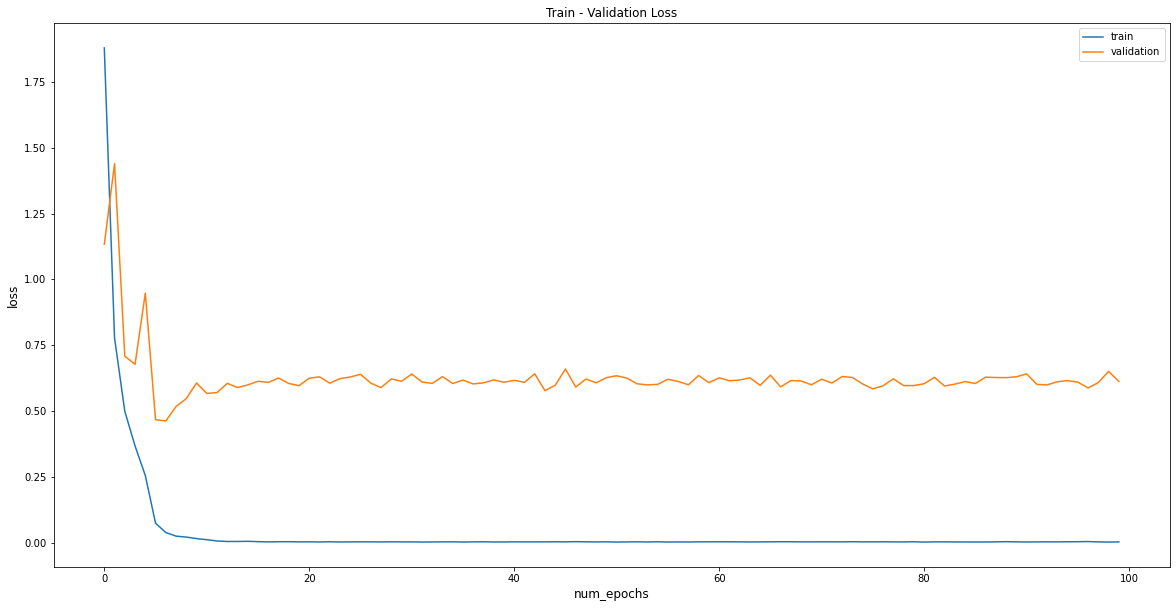

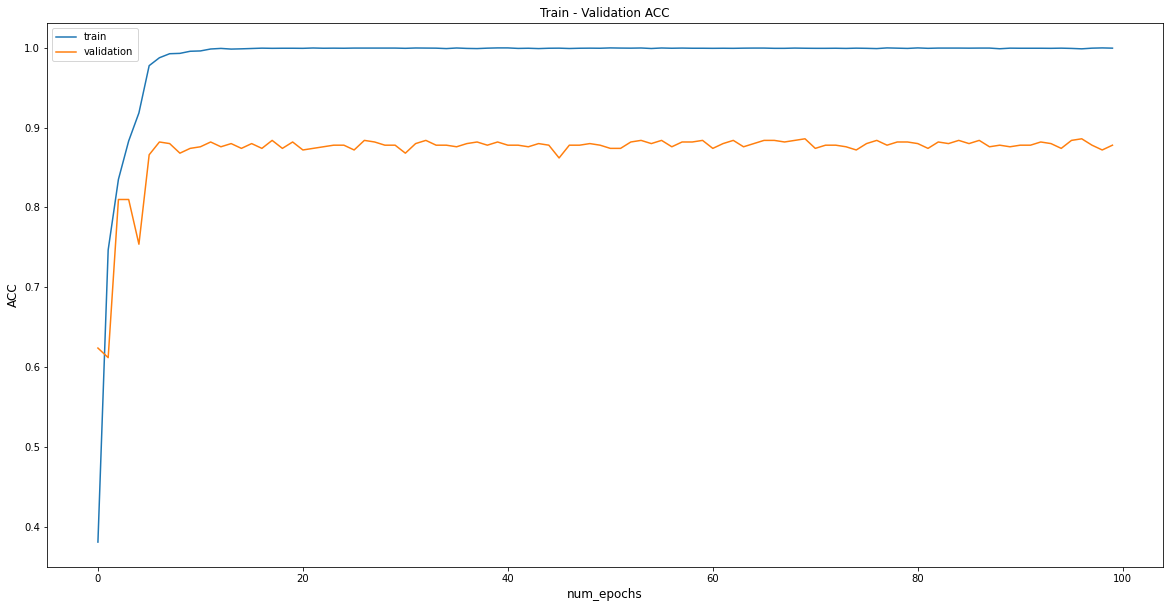

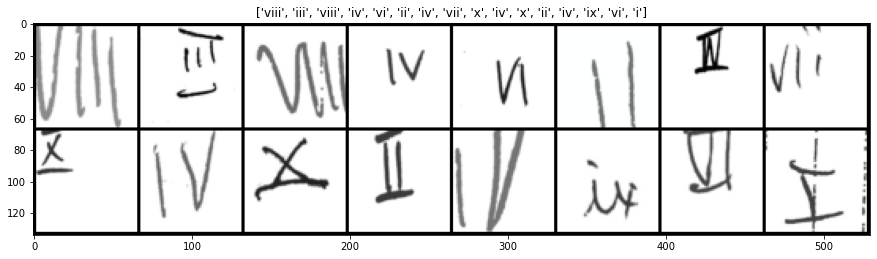

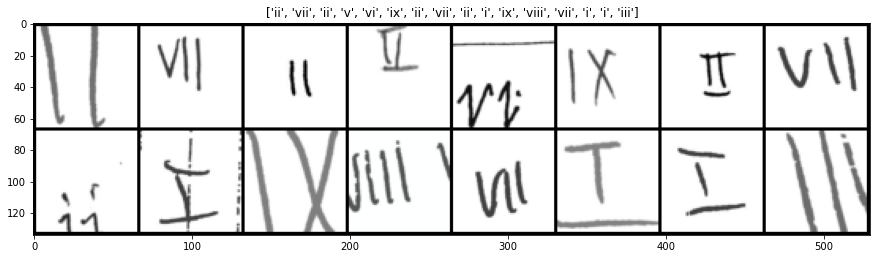

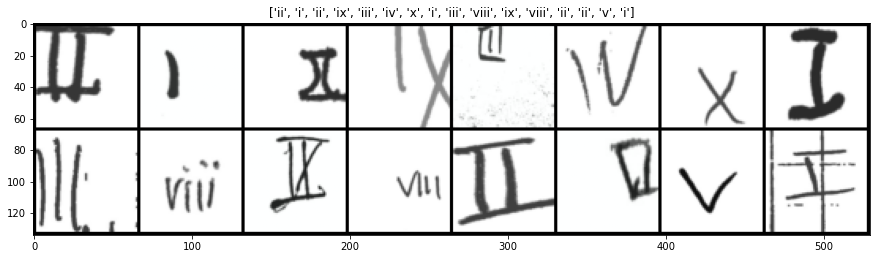

Epoch 1/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.13it/s]


train Loss: 1.6390 Acc: 0.4634


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.97it/s]


val Loss: 1.1743 Acc: 0.6600

Epoch 2/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.7269 Acc: 0.7643


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.02it/s]


val Loss: 1.1897 Acc: 0.6689

Epoch 3/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.45it/s]


train Loss: 0.4749 Acc: 0.8437


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.13it/s]


val Loss: 0.7578 Acc: 0.7849

Epoch 4/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.21it/s]


train Loss: 0.3910 Acc: 0.8745


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.23it/s]


val Loss: 1.8113 Acc: 0.6254

Epoch 5/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.36it/s]


train Loss: 0.2656 Acc: 0.9148


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.18it/s]


val Loss: 0.9278 Acc: 0.7500

Epoch 6/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0797 Acc: 0.9746


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.97it/s]


val Loss: 0.5020 Acc: 0.8651

Epoch 7/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0350 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.90it/s]


val Loss: 0.5117 Acc: 0.8683

Epoch 8/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.38it/s]


train Loss: 0.0265 Acc: 0.9928


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.14it/s]


val Loss: 0.5266 Acc: 0.8657

Epoch 9/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0192 Acc: 0.9958


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.24it/s]


val Loss: 0.5337 Acc: 0.8669

Epoch 10/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.44it/s]


train Loss: 0.0229 Acc: 0.9938


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.34it/s]


val Loss: 0.6276 Acc: 0.8520

Epoch 11/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.34it/s]


train Loss: 0.0118 Acc: 0.9978


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:09<00:00, 23.90it/s]


val Loss: 0.6040 Acc: 0.8537

Epoch 12/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.28it/s]


train Loss: 0.0087 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.32it/s]


val Loss: 0.5812 Acc: 0.8609

Epoch 13/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.24it/s]


train Loss: 0.0098 Acc: 0.9983


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.27it/s]


val Loss: 0.5671 Acc: 0.8606

Epoch 14/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.18it/s]


train Loss: 0.0065 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.31it/s]


val Loss: 0.5753 Acc: 0.8629

Epoch 15/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.38it/s]


train Loss: 0.0071 Acc: 0.9985


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.12it/s]


val Loss: 0.6052 Acc: 0.8583

Epoch 16/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0061 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.14it/s]


val Loss: 0.5917 Acc: 0.8611

Epoch 17/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.33it/s]


train Loss: 0.0055 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.97it/s]


val Loss: 0.5791 Acc: 0.8580

Epoch 18/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.45it/s]


train Loss: 0.0064 Acc: 0.9989


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.31it/s]


val Loss: 0.6069 Acc: 0.8597

Epoch 19/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0049 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.22it/s]


val Loss: 0.5794 Acc: 0.8591

Epoch 20/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.14it/s]


train Loss: 0.0047 Acc: 0.9997


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.11it/s]


val Loss: 0.5948 Acc: 0.8609

Epoch 21/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.12it/s]


train Loss: 0.0067 Acc: 0.9989


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:09<00:00, 24.08it/s]


val Loss: 0.5781 Acc: 0.8603

Epoch 22/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.27it/s]


train Loss: 0.0055 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.09it/s]


val Loss: 0.5904 Acc: 0.8620

Epoch 23/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.27it/s]


train Loss: 0.0060 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.30it/s]


val Loss: 0.5831 Acc: 0.8594

Epoch 24/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.34it/s]


train Loss: 0.0050 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.10it/s]


val Loss: 0.5904 Acc: 0.8591

Epoch 25/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.44it/s]


train Loss: 0.0045 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.45it/s]


val Loss: 0.5885 Acc: 0.8586

Epoch 26/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0044 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.17it/s]


val Loss: 0.5940 Acc: 0.8591

Epoch 27/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.40it/s]


train Loss: 0.0060 Acc: 0.9989


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.09it/s]


val Loss: 0.6098 Acc: 0.8580

Epoch 28/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.36it/s]


train Loss: 0.0052 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.94it/s]


val Loss: 0.5850 Acc: 0.8569

Epoch 29/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.43it/s]


train Loss: 0.0056 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.91it/s]


val Loss: 0.5912 Acc: 0.8600

Epoch 30/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.18it/s]


train Loss: 0.0048 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.24it/s]


val Loss: 0.5839 Acc: 0.8606

Epoch 31/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.10it/s]


train Loss: 0.0052 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.27it/s]


val Loss: 0.5973 Acc: 0.8611

Epoch 32/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0056 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.18it/s]


val Loss: 0.5891 Acc: 0.8631

Epoch 33/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.37it/s]


train Loss: 0.0053 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.13it/s]


val Loss: 0.5842 Acc: 0.8577

Epoch 34/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.25it/s]


train Loss: 0.0062 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.23it/s]


val Loss: 0.5724 Acc: 0.8580

Epoch 35/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.27it/s]


train Loss: 0.0052 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.23it/s]


val Loss: 0.5871 Acc: 0.8631

Epoch 36/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.34it/s]


train Loss: 0.0049 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.26it/s]


val Loss: 0.5858 Acc: 0.8571

Epoch 37/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.26it/s]


train Loss: 0.0047 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.02it/s]


val Loss: 0.5965 Acc: 0.8591

Epoch 38/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0052 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.26it/s]


val Loss: 0.6198 Acc: 0.8614

Epoch 39/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.25it/s]


train Loss: 0.0061 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.21it/s]


val Loss: 0.6038 Acc: 0.8557

Epoch 40/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.22it/s]


train Loss: 0.0057 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.16it/s]


val Loss: 0.5979 Acc: 0.8603

Epoch 41/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.43it/s]


train Loss: 0.0050 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.98it/s]


val Loss: 0.5894 Acc: 0.8594

Epoch 42/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0050 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.22it/s]


val Loss: 0.5873 Acc: 0.8597

Epoch 43/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0060 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.36it/s]


val Loss: 0.5803 Acc: 0.8611

Epoch 44/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.37it/s]


train Loss: 0.0048 Acc: 0.9997


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.20it/s]


val Loss: 0.5860 Acc: 0.8617

Epoch 45/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.37it/s]


train Loss: 0.0067 Acc: 0.9985


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.50it/s]


val Loss: 0.5909 Acc: 0.8603

Epoch 46/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.36it/s]


train Loss: 0.0052 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.25it/s]


val Loss: 0.5906 Acc: 0.8589

Epoch 47/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0048 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.16it/s]


val Loss: 0.5939 Acc: 0.8611

Epoch 48/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.25it/s]


train Loss: 0.0060 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.22it/s]


val Loss: 0.5989 Acc: 0.8594

Epoch 49/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.40it/s]


train Loss: 0.0065 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.00it/s]


val Loss: 0.5939 Acc: 0.8591

Epoch 50/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.39it/s]


train Loss: 0.0052 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.15it/s]


val Loss: 0.5936 Acc: 0.8580

Epoch 51/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.32it/s]


train Loss: 0.0059 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.22it/s]


val Loss: 0.5713 Acc: 0.8597

Epoch 52/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.39it/s]


train Loss: 0.0060 Acc: 0.9989


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.15it/s]


val Loss: 0.5808 Acc: 0.8611

Epoch 53/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.37it/s]


train Loss: 0.0047 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.99it/s]


val Loss: 0.6066 Acc: 0.8611

Epoch 54/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.28it/s]


train Loss: 0.0061 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.10it/s]


val Loss: 0.5835 Acc: 0.8611

Epoch 55/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.15it/s]


train Loss: 0.0053 Acc: 0.9997


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.95it/s]


val Loss: 0.6006 Acc: 0.8583

Epoch 56/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.38it/s]


train Loss: 0.0044 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.25it/s]


val Loss: 0.5808 Acc: 0.8631

Epoch 57/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.33it/s]


train Loss: 0.0069 Acc: 0.9989


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.21it/s]


val Loss: 0.5936 Acc: 0.8611

Epoch 58/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.19it/s]


train Loss: 0.0043 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.24it/s]


val Loss: 0.5769 Acc: 0.8617

Epoch 59/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0051 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.25it/s]


val Loss: 0.5922 Acc: 0.8580

Epoch 60/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.37it/s]


train Loss: 0.0043 Acc: 0.9997


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.13it/s]


val Loss: 0.5957 Acc: 0.8617

Epoch 61/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0053 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.25it/s]


val Loss: 0.5884 Acc: 0.8611

Epoch 62/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.35it/s]


train Loss: 0.0058 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.28it/s]


val Loss: 0.5867 Acc: 0.8631

Epoch 63/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.39it/s]


train Loss: 0.0058 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.18it/s]


val Loss: 0.5867 Acc: 0.8580

Epoch 64/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0054 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.23it/s]


val Loss: 0.5760 Acc: 0.8617

Epoch 65/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0046 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.05it/s]


val Loss: 0.6019 Acc: 0.8577

Epoch 66/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.39it/s]


train Loss: 0.0055 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.23it/s]


val Loss: 0.5810 Acc: 0.8580

Epoch 67/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0056 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.14it/s]


val Loss: 0.5992 Acc: 0.8591

Epoch 68/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.32it/s]


train Loss: 0.0058 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:09<00:00, 24.03it/s]


val Loss: 0.5893 Acc: 0.8603

Epoch 69/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.38it/s]


train Loss: 0.0055 Acc: 0.9997


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.05it/s]


val Loss: 0.6022 Acc: 0.8606

Epoch 70/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0053 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.27it/s]


val Loss: 0.5946 Acc: 0.8591

Epoch 71/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0054 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.29it/s]


val Loss: 0.5924 Acc: 0.8557

Epoch 72/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.34it/s]


train Loss: 0.0054 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.14it/s]


val Loss: 0.6001 Acc: 0.8577

Epoch 73/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.44it/s]


train Loss: 0.0048 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.23it/s]


val Loss: 0.5903 Acc: 0.8583

Epoch 74/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.36it/s]


train Loss: 0.0057 Acc: 0.9989


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:09<00:00, 23.79it/s]


val Loss: 0.5838 Acc: 0.8614

Epoch 75/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.35it/s]


train Loss: 0.0061 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.27it/s]


val Loss: 0.5794 Acc: 0.8583

Epoch 76/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0052 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.05it/s]


val Loss: 0.5867 Acc: 0.8571

Epoch 77/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0048 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.14it/s]


val Loss: 0.5907 Acc: 0.8629

Epoch 78/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.40it/s]


train Loss: 0.0052 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.27it/s]


val Loss: 0.5774 Acc: 0.8591

Epoch 79/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.40it/s]


train Loss: 0.0052 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.08it/s]


val Loss: 0.5959 Acc: 0.8597

Epoch 80/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.41it/s]


train Loss: 0.0065 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.10it/s]


val Loss: 0.5908 Acc: 0.8603

Epoch 81/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.43it/s]


train Loss: 0.0058 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.28it/s]


val Loss: 0.5869 Acc: 0.8597

Epoch 82/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.16it/s]


train Loss: 0.0056 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.00it/s]


val Loss: 0.6113 Acc: 0.8560

Epoch 83/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.32it/s]


train Loss: 0.0052 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.20it/s]


val Loss: 0.5987 Acc: 0.8540

Epoch 84/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.44it/s]


train Loss: 0.0049 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.18it/s]


val Loss: 0.5835 Acc: 0.8586

Epoch 85/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.25it/s]


train Loss: 0.0056 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.13it/s]


val Loss: 0.5867 Acc: 0.8629

Epoch 86/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.29it/s]


train Loss: 0.0060 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.25it/s]


val Loss: 0.6030 Acc: 0.8563

Epoch 87/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.33it/s]


train Loss: 0.0057 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:09<00:00, 23.85it/s]


val Loss: 0.5816 Acc: 0.8591

Epoch 88/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.10it/s]


train Loss: 0.0048 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.49it/s]


val Loss: 0.5793 Acc: 0.8577

Epoch 89/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.35it/s]


train Loss: 0.0049 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.28it/s]


val Loss: 0.6022 Acc: 0.8606

Epoch 90/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.34it/s]


train Loss: 0.0048 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 24.58it/s]


val Loss: 0.5735 Acc: 0.8617

Epoch 91/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.39it/s]


train Loss: 0.0052 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.14it/s]


val Loss: 0.5919 Acc: 0.8563

Epoch 92/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.39it/s]


train Loss: 0.0054 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.28it/s]


val Loss: 0.5967 Acc: 0.8589

Epoch 93/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.40it/s]


train Loss: 0.0055 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.31it/s]


val Loss: 0.6154 Acc: 0.8583

Epoch 94/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0051 Acc: 0.9997


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.31it/s]


val Loss: 0.5846 Acc: 0.8583

Epoch 95/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.44it/s]


train Loss: 0.0057 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.25it/s]


val Loss: 0.5957 Acc: 0.8591

Epoch 96/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.33it/s]


train Loss: 0.0055 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.33it/s]


val Loss: 0.5840 Acc: 0.8577

Epoch 97/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.43it/s]


train Loss: 0.0054 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.33it/s]


val Loss: 0.5835 Acc: 0.8574

Epoch 98/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:36<00:00, 11.16it/s]


train Loss: 0.0057 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.25it/s]


val Loss: 0.5892 Acc: 0.8597

Epoch 99/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.38it/s]


train Loss: 0.0056 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.18it/s]


val Loss: 0.5950 Acc: 0.8597

Epoch 100/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 407/407 [00:35<00:00, 11.42it/s]


train Loss: 0.0055 Acc: 0.9995


100%|██████████████████████████████████████████████████████████████████████████| 219/219 [00:08<00:00, 25.15it/s]


val Loss: 0.5969 Acc: 0.8620

Training complete in 74m 22s
Best val Acc: 0.868286
Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


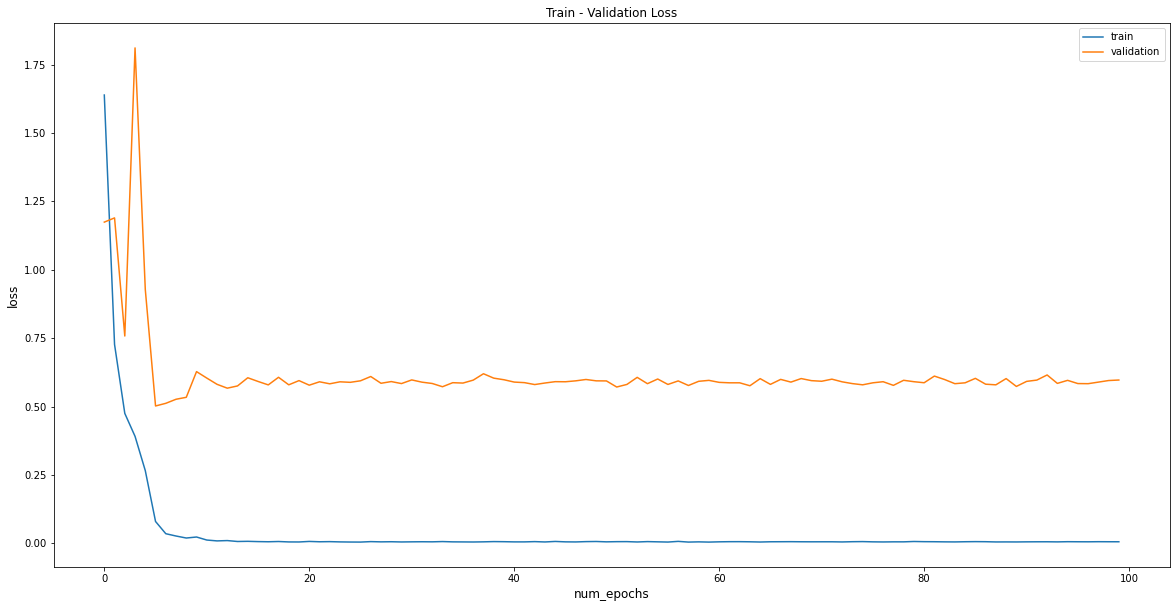

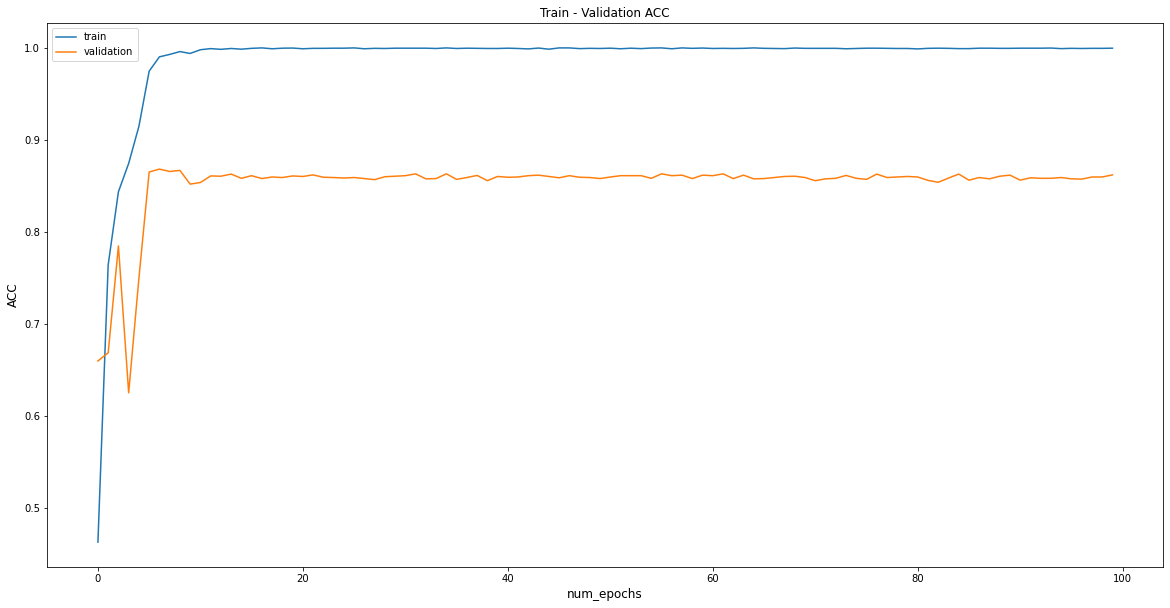

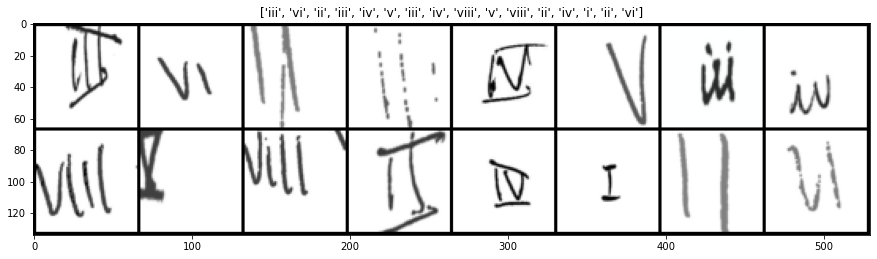

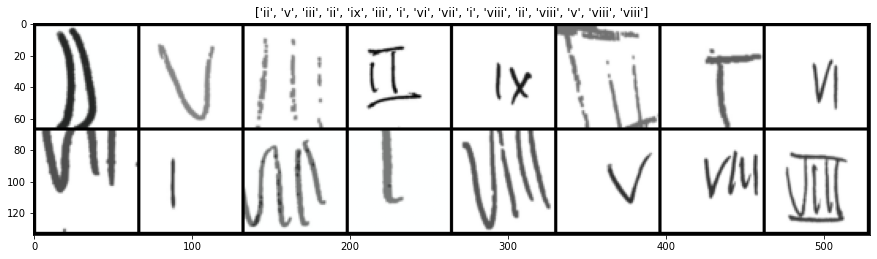

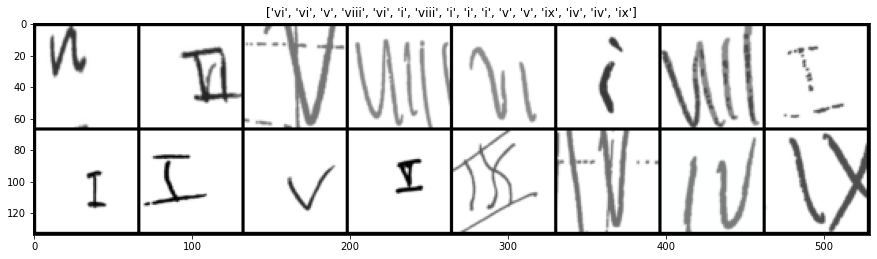

Epoch 1/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.28it/s]


train Loss: 2.0517 Acc: 0.3420


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 1.3060 Acc: 0.5626

Epoch 2/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.42it/s]


train Loss: 0.9600 Acc: 0.6698


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.08it/s]


val Loss: 1.2453 Acc: 0.6212

Epoch 3/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.6246 Acc: 0.7954


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.00it/s]


val Loss: 0.8557 Acc: 0.7354

Epoch 4/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.4490 Acc: 0.8564


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.14it/s]


val Loss: 0.8939 Acc: 0.7364

Epoch 5/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.31it/s]


train Loss: 0.3780 Acc: 0.8798


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.86it/s]


val Loss: 0.9007 Acc: 0.7958

Epoch 6/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.16it/s]


train Loss: 0.1183 Acc: 0.9648


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.82it/s]


val Loss: 0.5943 Acc: 0.8382

Epoch 7/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


train Loss: 0.0705 Acc: 0.9788


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.18it/s]


val Loss: 0.6244 Acc: 0.8320

Epoch 8/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0487 Acc: 0.9874


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.20it/s]


val Loss: 0.6681 Acc: 0.8442

Epoch 9/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0356 Acc: 0.9892


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.32it/s]


val Loss: 0.6460 Acc: 0.8448

Epoch 10/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


train Loss: 0.0252 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.22it/s]


val Loss: 0.7125 Acc: 0.8538

Epoch 11/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.42it/s]


train Loss: 0.0153 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.07it/s]


val Loss: 0.6979 Acc: 0.8508

Epoch 12/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0131 Acc: 0.9970


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.15it/s]


val Loss: 0.7276 Acc: 0.8518

Epoch 13/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.25it/s]


train Loss: 0.0119 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.60it/s]


val Loss: 0.7463 Acc: 0.8488

Epoch 14/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.0115 Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.82it/s]


val Loss: 0.7111 Acc: 0.8512

Epoch 15/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.12it/s]


train Loss: 0.0094 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.28it/s]


val Loss: 0.7148 Acc: 0.8486

Epoch 16/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


train Loss: 0.0080 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.20it/s]


val Loss: 0.7433 Acc: 0.8484

Epoch 17/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.35it/s]


train Loss: 0.0078 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.09it/s]


val Loss: 0.7149 Acc: 0.8476

Epoch 18/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


train Loss: 0.0080 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.21it/s]


val Loss: 0.7385 Acc: 0.8462

Epoch 19/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.21it/s]


train Loss: 0.0090 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.32it/s]


val Loss: 0.7124 Acc: 0.8458

Epoch 20/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.42it/s]


train Loss: 0.0078 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 0.7687 Acc: 0.8474

Epoch 21/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.0105 Acc: 0.9970


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.80it/s]


val Loss: 0.7175 Acc: 0.8510

Epoch 22/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0096 Acc: 0.9976


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.19it/s]


val Loss: 0.7676 Acc: 0.8470

Epoch 23/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0092 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.21it/s]


val Loss: 0.7117 Acc: 0.8494

Epoch 24/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.29it/s]


train Loss: 0.0091 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.93it/s]


val Loss: 0.7386 Acc: 0.8492

Epoch 25/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.21it/s]


train Loss: 0.0092 Acc: 0.9976


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.15it/s]


val Loss: 0.7042 Acc: 0.8516

Epoch 26/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.0092 Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.79it/s]


val Loss: 0.7247 Acc: 0.8496

Epoch 27/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0083 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.93it/s]


val Loss: 0.7733 Acc: 0.8462

Epoch 28/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.0074 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.26it/s]


val Loss: 0.7250 Acc: 0.8504

Epoch 29/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0077 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.25it/s]


val Loss: 0.6920 Acc: 0.8488

Epoch 30/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.21it/s]


train Loss: 0.0077 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 23.85it/s]


val Loss: 0.7194 Acc: 0.8484

Epoch 31/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.22it/s]


train Loss: 0.0097 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.12it/s]


val Loss: 0.7355 Acc: 0.8466

Epoch 32/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0089 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.19it/s]


val Loss: 0.7361 Acc: 0.8482

Epoch 33/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0081 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.18it/s]


val Loss: 0.7503 Acc: 0.8446

Epoch 34/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0073 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 0.7401 Acc: 0.8468

Epoch 35/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0083 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.29it/s]


val Loss: 0.7169 Acc: 0.8484

Epoch 36/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.42it/s]


train Loss: 0.0090 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.36it/s]


val Loss: 0.7492 Acc: 0.8446

Epoch 37/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0088 Acc: 0.9980


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.18it/s]


val Loss: 0.7162 Acc: 0.8466

Epoch 38/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


train Loss: 0.0069 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.90it/s]


val Loss: 0.7330 Acc: 0.8484

Epoch 39/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0075 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.15it/s]


val Loss: 0.7354 Acc: 0.8488

Epoch 40/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.33it/s]


train Loss: 0.0080 Acc: 0.9992


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.84it/s]


val Loss: 0.7302 Acc: 0.8484

Epoch 41/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.10it/s]


train Loss: 0.0086 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.05it/s]


val Loss: 0.7266 Acc: 0.8460

Epoch 42/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0079 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.20it/s]


val Loss: 0.7213 Acc: 0.8498

Epoch 43/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0080 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.13it/s]


val Loss: 0.7565 Acc: 0.8432

Epoch 44/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.33it/s]


train Loss: 0.0061 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.24it/s]


val Loss: 0.7352 Acc: 0.8478

Epoch 45/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.16it/s]


train Loss: 0.0080 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.17it/s]


val Loss: 0.6886 Acc: 0.8508

Epoch 46/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.25it/s]


train Loss: 0.0085 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.37it/s]


val Loss: 0.7342 Acc: 0.8476

Epoch 47/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.04it/s]


train Loss: 0.0084 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.85it/s]


val Loss: 0.7427 Acc: 0.8466

Epoch 48/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.26it/s]


train Loss: 0.0086 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.25it/s]


val Loss: 0.7258 Acc: 0.8500

Epoch 49/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0091 Acc: 0.9980


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.00it/s]


val Loss: 0.7205 Acc: 0.8486

Epoch 50/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


train Loss: 0.0074 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.21it/s]


val Loss: 0.7642 Acc: 0.8458

Epoch 51/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0070 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.20it/s]


val Loss: 0.7345 Acc: 0.8456

Epoch 52/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0078 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.22it/s]


val Loss: 0.7411 Acc: 0.8468

Epoch 53/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


train Loss: 0.0081 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.24it/s]


val Loss: 0.7560 Acc: 0.8456

Epoch 54/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0075 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.18it/s]


val Loss: 0.7469 Acc: 0.8460

Epoch 55/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.16it/s]


train Loss: 0.0079 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.21it/s]


val Loss: 0.7537 Acc: 0.8454

Epoch 56/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0075 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.11it/s]


val Loss: 0.7313 Acc: 0.8444

Epoch 57/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


train Loss: 0.0085 Acc: 0.9978


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.08it/s]


val Loss: 0.7617 Acc: 0.8482

Epoch 58/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.0097 Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.15it/s]


val Loss: 0.7424 Acc: 0.8458

Epoch 59/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.12it/s]


train Loss: 0.0087 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.06it/s]


val Loss: 0.7184 Acc: 0.8476

Epoch 60/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


train Loss: 0.0095 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 0.7684 Acc: 0.8434

Epoch 61/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.22it/s]


train Loss: 0.0090 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.67it/s]


val Loss: 0.7398 Acc: 0.8492

Epoch 62/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.28it/s]


train Loss: 0.0078 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.22it/s]


val Loss: 0.7423 Acc: 0.8480

Epoch 63/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0095 Acc: 0.9976


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 0.7264 Acc: 0.8494

Epoch 64/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0078 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.24it/s]


val Loss: 0.7392 Acc: 0.8506

Epoch 65/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0080 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.03it/s]


val Loss: 0.7232 Acc: 0.8446

Epoch 66/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.17it/s]


train Loss: 0.0111 Acc: 0.9976


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.19it/s]


val Loss: 0.7302 Acc: 0.8476

Epoch 67/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0090 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.82it/s]


val Loss: 0.7365 Acc: 0.8462

Epoch 68/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.32it/s]


train Loss: 0.0084 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.80it/s]


val Loss: 0.7443 Acc: 0.8460

Epoch 69/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0073 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 0.6940 Acc: 0.8520

Epoch 70/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0066 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.16it/s]


val Loss: 0.7275 Acc: 0.8466

Epoch 71/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0085 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.19it/s]


val Loss: 0.7374 Acc: 0.8472

Epoch 72/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.28it/s]


train Loss: 0.0074 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.09it/s]


val Loss: 0.7437 Acc: 0.8470

Epoch 73/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0083 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.19it/s]


val Loss: 0.7489 Acc: 0.8498

Epoch 74/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0087 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.50it/s]


val Loss: 0.7340 Acc: 0.8470

Epoch 75/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.18it/s]


train Loss: 0.0095 Acc: 0.9978


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.91it/s]


val Loss: 0.7858 Acc: 0.8470

Epoch 76/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0080 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.30it/s]


val Loss: 0.7338 Acc: 0.8470

Epoch 77/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.39it/s]


train Loss: 0.0094 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.26it/s]


val Loss: 0.7340 Acc: 0.8472

Epoch 78/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.29it/s]


train Loss: 0.0077 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.53it/s]


val Loss: 0.7036 Acc: 0.8494

Epoch 79/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


train Loss: 0.0087 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.00it/s]


val Loss: 0.7454 Acc: 0.8492

Epoch 80/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.31it/s]


train Loss: 0.0102 Acc: 0.9976


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.19it/s]


val Loss: 0.7647 Acc: 0.8478

Epoch 81/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0068 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 0.7832 Acc: 0.8414

Epoch 82/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0069 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.25it/s]


val Loss: 0.7275 Acc: 0.8464

Epoch 83/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.29it/s]


train Loss: 0.0078 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.07it/s]


val Loss: 0.7613 Acc: 0.8488

Epoch 84/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.24it/s]


train Loss: 0.0067 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.93it/s]


val Loss: 0.7289 Acc: 0.8468

Epoch 85/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.40it/s]


train Loss: 0.0092 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.20it/s]


val Loss: 0.7429 Acc: 0.8492

Epoch 86/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.28it/s]


train Loss: 0.0079 Acc: 0.9986


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.87it/s]


val Loss: 0.7445 Acc: 0.8454

Epoch 87/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.36it/s]


train Loss: 0.0091 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.20it/s]


val Loss: 0.7367 Acc: 0.8468

Epoch 88/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.14it/s]


train Loss: 0.0085 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.67it/s]


val Loss: 0.7249 Acc: 0.8478

Epoch 89/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.18it/s]


train Loss: 0.0082 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.13it/s]


val Loss: 0.7443 Acc: 0.8424

Epoch 90/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.30it/s]


train Loss: 0.0090 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.91it/s]


val Loss: 0.7380 Acc: 0.8482

Epoch 91/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.13it/s]


train Loss: 0.0080 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.94it/s]


val Loss: 0.7554 Acc: 0.8478

Epoch 92/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.33it/s]


train Loss: 0.0086 Acc: 0.9984


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.93it/s]


val Loss: 0.7375 Acc: 0.8460

Epoch 93/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.34it/s]


train Loss: 0.0073 Acc: 0.9994


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.09it/s]


val Loss: 0.7211 Acc: 0.8472

Epoch 94/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.38it/s]


train Loss: 0.0112 Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.23it/s]


val Loss: 0.7559 Acc: 0.8454

Epoch 95/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.37it/s]


train Loss: 0.0087 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.16it/s]


val Loss: 0.7126 Acc: 0.8470

Epoch 96/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.0076 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.81it/s]


val Loss: 0.7313 Acc: 0.8468

Epoch 97/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.26it/s]


train Loss: 0.0083 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.05it/s]


val Loss: 0.7279 Acc: 0.8464

Epoch 98/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.33it/s]


train Loss: 0.0085 Acc: 0.9988


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.17it/s]


val Loss: 0.7234 Acc: 0.8490

Epoch 99/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


train Loss: 0.0090 Acc: 0.9980


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.91it/s]


val Loss: 0.7372 Acc: 0.8460

Epoch 100/100
----------


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.17it/s]


train Loss: 0.0082 Acc: 0.9990


100%|██████████████████████████████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.17it/s]


val Loss: 0.7360 Acc: 0.8502

Training complete in 66m 55s
Best val Acc: 0.853800


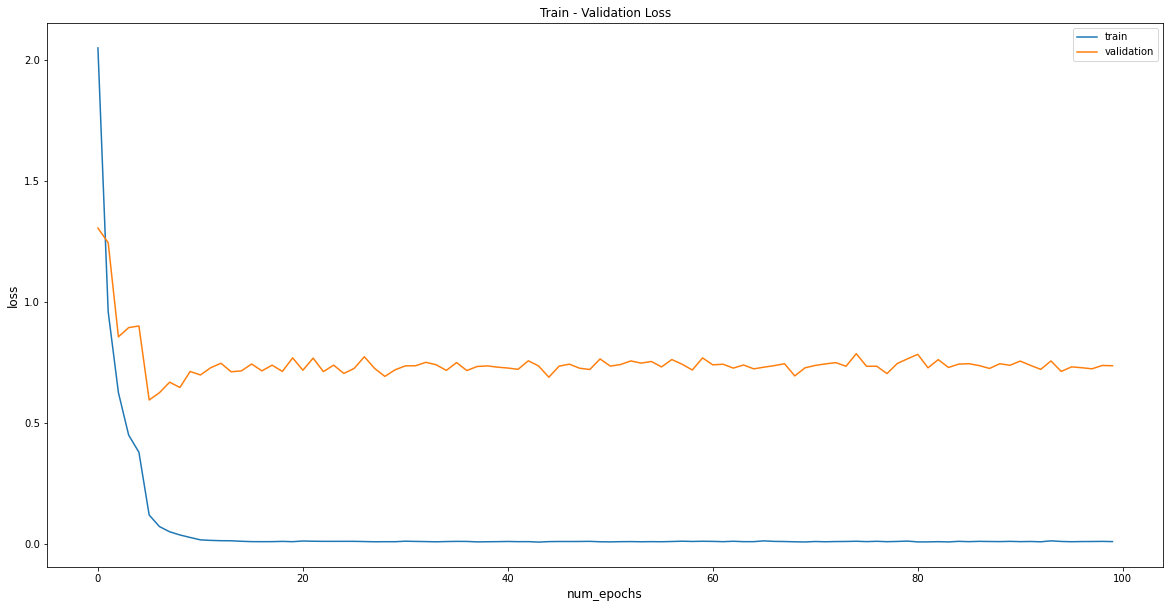

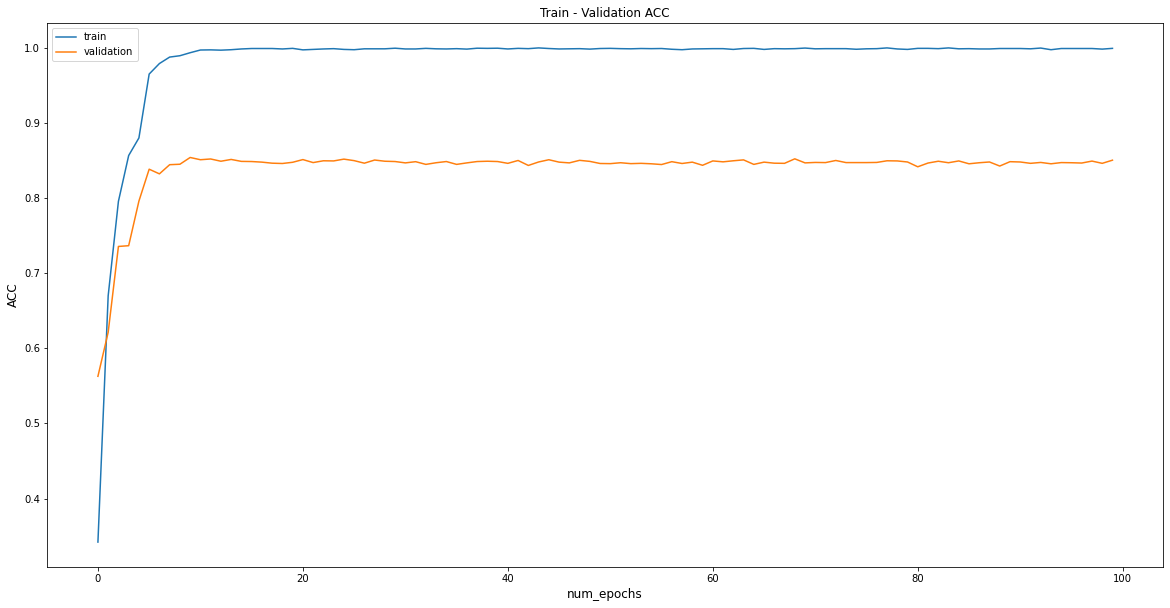

In [ ]:
val_proportions = [0.1,0.05,0.35,0.5]
val_accuracy2 = []  # save validation accuracy for each augmentation sequence
seq = iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))),iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}),iaa.PerspectiveTransform(scale=(0.01, 0.12))])

for p in val_proportions:
    num_label_train = 1000 * (1-p)
    num_label_val = 1000 - num_label_train
    augment_train_val(seq, num_label_train, num_label_val)
    %run run_train_eval.py
    val_accuracy2.append(test_accuracy())
    delete_augs()
    

In [ ]:
print([acc.item() for acc in val_accuracy2])

[0.9480000734329224, 0.940000057220459, 0.9240000247955322, 0.9360000491142273]


Note that with the original 0.8-0.2 split the validation set accuracy was 0.952. That accuracy is greater than any of the accuracies tested with other splits, so the split we will use for the final dataset will be 0.8-0.2.

# Analyzing Results and Model

We now train the best model, with the selected augmentation method and train-val split and then further analyze it.

Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


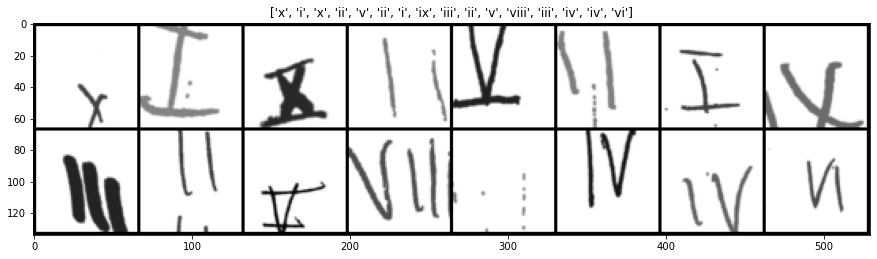

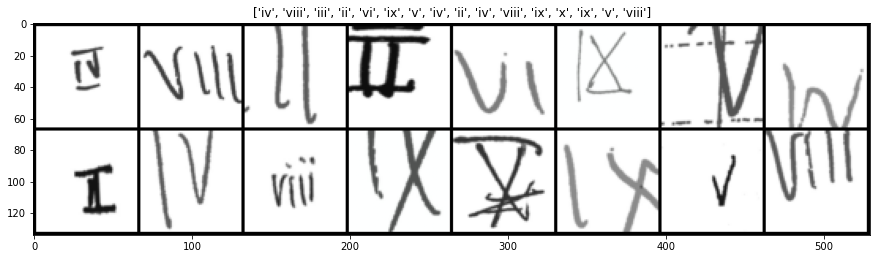

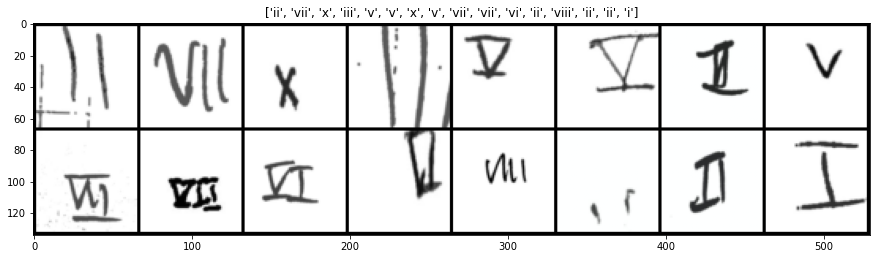

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.14it/s]


train Loss: 1.6274 Acc: 0.4704


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.93it/s]


val Loss: 1.2454 Acc: 0.6085

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.12it/s]


train Loss: 0.6289 Acc: 0.7944


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.72it/s]


val Loss: 0.6024 Acc: 0.7865

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.4204 Acc: 0.8672


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.99it/s]


val Loss: 0.8101 Acc: 0.7480

Epoch 4/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.3419 Acc: 0.8934


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.6125 Acc: 0.8085

Epoch 5/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.2817 Acc: 0.9140


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.07it/s]


val Loss: 0.7588 Acc: 0.7935

Epoch 6/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0884 Acc: 0.9748


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.05it/s]


val Loss: 0.4385 Acc: 0.8615

Epoch 7/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0396 Acc: 0.9901


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.35it/s]


val Loss: 0.4811 Acc: 0.8600

Epoch 8/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.05it/s]


train Loss: 0.0244 Acc: 0.9939


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5193 Acc: 0.8545

Epoch 9/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0181 Acc: 0.9950


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.05it/s]


val Loss: 0.5786 Acc: 0.8470

Epoch 10/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0141 Acc: 0.9961


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.92it/s]


val Loss: 0.5531 Acc: 0.8630

Epoch 11/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0116 Acc: 0.9972


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.87it/s]


val Loss: 0.5594 Acc: 0.8635

Epoch 12/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0095 Acc: 0.9978


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.01it/s]


val Loss: 0.5870 Acc: 0.8615

Epoch 13/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0069 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.83it/s]


val Loss: 0.5419 Acc: 0.8640

Epoch 14/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0060 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.09it/s]


val Loss: 0.5597 Acc: 0.8595

Epoch 15/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0065 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.10it/s]


val Loss: 0.5641 Acc: 0.8625

Epoch 16/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0050 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5875 Acc: 0.8585

Epoch 17/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0050 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.19it/s]


val Loss: 0.5672 Acc: 0.8605

Epoch 18/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0044 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.24it/s]


val Loss: 0.5671 Acc: 0.8630

Epoch 19/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0045 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.10it/s]


val Loss: 0.5820 Acc: 0.8595

Epoch 20/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0039 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5725 Acc: 0.8605

Epoch 21/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0051 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.50it/s]


val Loss: 0.5734 Acc: 0.8595

Epoch 22/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0036 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.27it/s]


val Loss: 0.5892 Acc: 0.8605

Epoch 23/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0040 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.10it/s]


val Loss: 0.5772 Acc: 0.8615

Epoch 24/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0046 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.86it/s]


val Loss: 0.5763 Acc: 0.8630

Epoch 25/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0041 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.04it/s]


val Loss: 0.5773 Acc: 0.8610

Epoch 26/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.17it/s]


train Loss: 0.0048 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.82it/s]


val Loss: 0.5671 Acc: 0.8625

Epoch 27/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0039 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.12it/s]


val Loss: 0.5890 Acc: 0.8620

Epoch 28/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0041 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.02it/s]


val Loss: 0.5556 Acc: 0.8610

Epoch 29/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0042 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.10it/s]


val Loss: 0.5676 Acc: 0.8650

Epoch 30/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0038 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.03it/s]


val Loss: 0.5599 Acc: 0.8615

Epoch 31/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0038 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.21it/s]


val Loss: 0.5746 Acc: 0.8625

Epoch 32/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.26it/s]


train Loss: 0.0040 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.01it/s]


val Loss: 0.5939 Acc: 0.8590

Epoch 33/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0038 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.13it/s]


val Loss: 0.5752 Acc: 0.8620

Epoch 34/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.36it/s]


train Loss: 0.0040 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.05it/s]


val Loss: 0.5642 Acc: 0.8650

Epoch 35/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0038 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.21it/s]


val Loss: 0.5702 Acc: 0.8620

Epoch 36/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0046 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.46it/s]


val Loss: 0.5589 Acc: 0.8655

Epoch 37/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0038 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.16it/s]


val Loss: 0.5643 Acc: 0.8610

Epoch 38/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0039 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 25.00it/s]


val Loss: 0.5732 Acc: 0.8605

Epoch 39/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0039 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.11it/s]


val Loss: 0.5492 Acc: 0.8625

Epoch 40/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0042 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.15it/s]


val Loss: 0.5691 Acc: 0.8620

Epoch 41/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0041 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.86it/s]


val Loss: 0.5600 Acc: 0.8640

Epoch 42/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0040 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.14it/s]


val Loss: 0.5828 Acc: 0.8580

Epoch 43/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0036 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.5823 Acc: 0.8610

Epoch 44/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0042 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.09it/s]


val Loss: 0.5626 Acc: 0.8590

Epoch 45/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0042 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.18it/s]


val Loss: 0.5873 Acc: 0.8620

Epoch 46/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0042 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.10it/s]


val Loss: 0.5792 Acc: 0.8620

Epoch 47/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0041 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.13it/s]


val Loss: 0.5821 Acc: 0.8625

Epoch 48/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0038 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.19it/s]


val Loss: 0.5692 Acc: 0.8615

Epoch 49/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0039 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.95it/s]


val Loss: 0.5774 Acc: 0.8645

Epoch 50/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0040 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.22it/s]


val Loss: 0.5918 Acc: 0.8600

Epoch 51/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0047 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.15it/s]


val Loss: 0.5818 Acc: 0.8605

Epoch 52/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0043 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.21it/s]


val Loss: 0.5754 Acc: 0.8630

Epoch 53/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0046 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.19it/s]


val Loss: 0.5862 Acc: 0.8620

Epoch 54/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0041 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.13it/s]


val Loss: 0.5638 Acc: 0.8595

Epoch 55/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0039 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.19it/s]


val Loss: 0.5853 Acc: 0.8620

Epoch 56/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0044 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.11it/s]


val Loss: 0.6050 Acc: 0.8630

Epoch 57/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0050 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.13it/s]


val Loss: 0.5593 Acc: 0.8635

Epoch 58/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0044 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.01it/s]


val Loss: 0.5882 Acc: 0.8620

Epoch 59/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0046 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.00it/s]


val Loss: 0.5670 Acc: 0.8645

Epoch 60/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0040 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.14it/s]


val Loss: 0.5796 Acc: 0.8620

Epoch 61/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0050 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.17it/s]


val Loss: 0.5756 Acc: 0.8645

Epoch 62/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0045 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.11it/s]


val Loss: 0.5663 Acc: 0.8585

Epoch 63/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0041 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.99it/s]


val Loss: 0.5945 Acc: 0.8615

Epoch 64/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0044 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.5892 Acc: 0.8635

Epoch 65/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0042 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.95it/s]


val Loss: 0.5886 Acc: 0.8615

Epoch 66/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.29it/s]


train Loss: 0.0041 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5729 Acc: 0.8605

Epoch 67/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0036 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5815 Acc: 0.8610

Epoch 68/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0034 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.16it/s]


val Loss: 0.5648 Acc: 0.8630

Epoch 69/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0041 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.14it/s]


val Loss: 0.5701 Acc: 0.8635

Epoch 70/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0037 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.12it/s]


val Loss: 0.5881 Acc: 0.8640

Epoch 71/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0043 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.21it/s]


val Loss: 0.5856 Acc: 0.8625

Epoch 72/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0042 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.20it/s]


val Loss: 0.5795 Acc: 0.8620

Epoch 73/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.20it/s]


train Loss: 0.0047 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.5783 Acc: 0.8595

Epoch 74/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.30it/s]


train Loss: 0.0042 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.75it/s]


val Loss: 0.5669 Acc: 0.8645

Epoch 75/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0056 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.23it/s]


val Loss: 0.5853 Acc: 0.8630

Epoch 76/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0040 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.84it/s]


val Loss: 0.5844 Acc: 0.8640

Epoch 77/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0038 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.14it/s]


val Loss: 0.5744 Acc: 0.8635

Epoch 78/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0042 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.03it/s]


val Loss: 0.5853 Acc: 0.8645

Epoch 79/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0035 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.30it/s]


val Loss: 0.5763 Acc: 0.8640

Epoch 80/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0041 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.97it/s]


val Loss: 0.5580 Acc: 0.8630

Epoch 81/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0047 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.19it/s]


val Loss: 0.5571 Acc: 0.8640

Epoch 82/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0040 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.18it/s]


val Loss: 0.5658 Acc: 0.8610

Epoch 83/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0040 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.20it/s]


val Loss: 0.5801 Acc: 0.8650

Epoch 84/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0043 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.19it/s]


val Loss: 0.5750 Acc: 0.8590

Epoch 85/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0047 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.12it/s]


val Loss: 0.5814 Acc: 0.8620

Epoch 86/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0041 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.98it/s]


val Loss: 0.5872 Acc: 0.8635

Epoch 87/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0042 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.99it/s]


val Loss: 0.5797 Acc: 0.8635

Epoch 88/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.18it/s]


train Loss: 0.0049 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.85it/s]


val Loss: 0.5865 Acc: 0.8615

Epoch 89/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0051 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.09it/s]


val Loss: 0.5694 Acc: 0.8655

Epoch 90/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.22it/s]


train Loss: 0.0036 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.11it/s]


val Loss: 0.5660 Acc: 0.8645

Epoch 91/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0034 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.93it/s]


val Loss: 0.5687 Acc: 0.8630

Epoch 92/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0038 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.98it/s]


val Loss: 0.5969 Acc: 0.8600

Epoch 93/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0035 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.17it/s]


val Loss: 0.5701 Acc: 0.8595

Epoch 94/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0036 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.12it/s]


val Loss: 0.5761 Acc: 0.8600

Epoch 95/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0046 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.06it/s]


val Loss: 0.5737 Acc: 0.8645

Epoch 96/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0039 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.08it/s]


val Loss: 0.5571 Acc: 0.8665

Epoch 97/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0039 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.26it/s]


val Loss: 0.5856 Acc: 0.8635

Epoch 98/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0038 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.04it/s]


val Loss: 0.5687 Acc: 0.8620

Epoch 99/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0037 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.18it/s]


val Loss: 0.5800 Acc: 0.8625

Epoch 100/100
----------


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0039 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.01it/s]


val Loss: 0.5694 Acc: 0.8650

Training complete in 81m 52s
Best val Acc: 0.866500


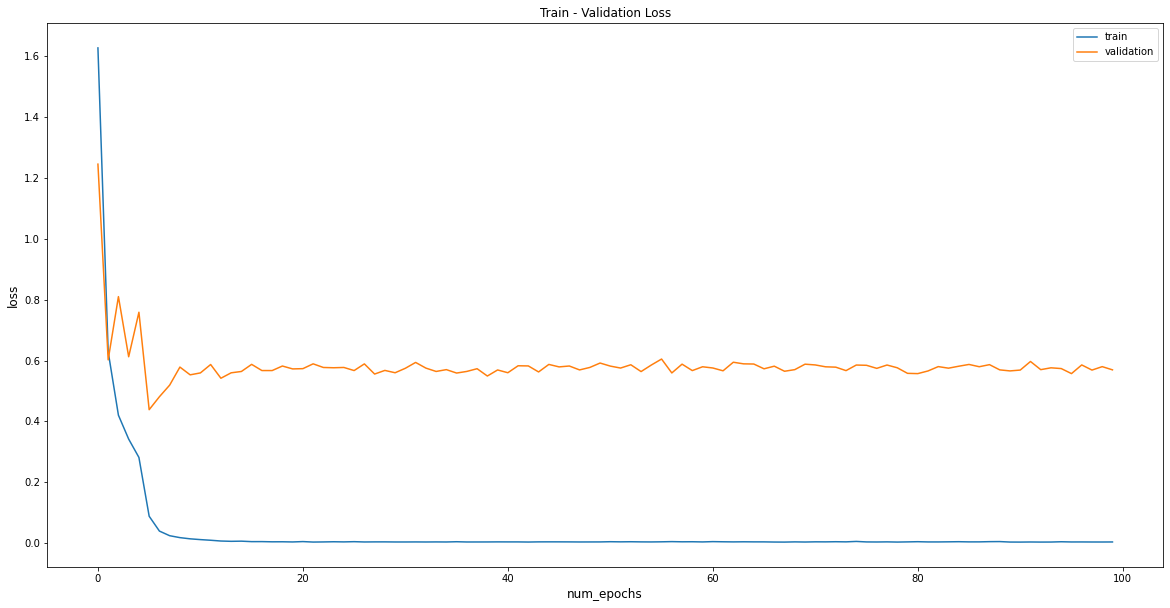

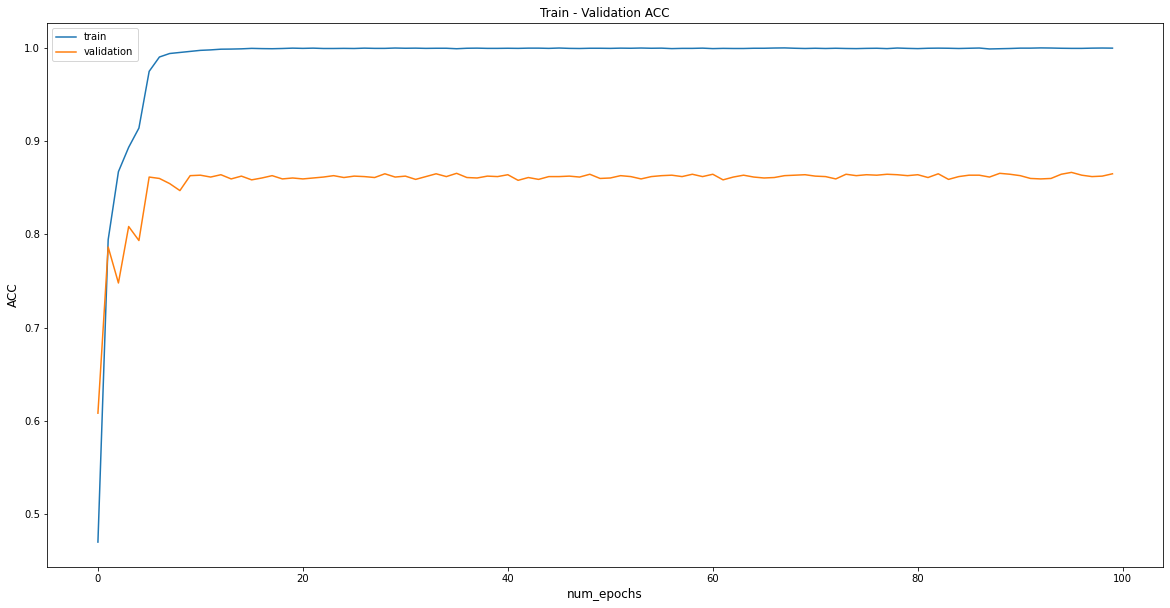

In [ ]:
seq = iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))),iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}),iaa.PerspectiveTransform(scale=(0.01, 0.12))])
num_label_train = 800
num_label_val = 1000 - num_label_train
augment_train_val(seq, num_label_train, num_label_val)
%run run_train_eval.py
delete_augs()


In [ ]:
test_accuracy(test_path="data/test").item()

0.940000057220459

The model got 0.94 accuracy on the test. We expect to get a similiar accuracy on the hidden test set using the model we will train on the whole dataset. This result is an improvement of 13% of the initial benchmark (validation accuracy of the ResNet model which does not use augmentation and is trained on the original data without any changes was 81%), which is a very significant improvement, even not considering the fact that the benchmark was regarding a validation set and this result is on a test set never seen before by the model. We are satisified with the result and will now make further analysis of the accuracy.

We look at how well our model performs on different labels. We might want to see if there is a label which the model has difficulty to classify.

In [ ]:
classes = os.listdir('data/train_/')
classes.sort()
_, labelStats = test_accuracy(test_path="data/test", labelStats=True)
print({classes[label]:labelStats[label] for label in range(len(classes))})

{'i': 0.96, 'ii': 0.84, 'iii': 0.92, 'iv': 0.92, 'ix': 0.92, 'v': 1.0, 'vi': 0.96, 'vii': 0.96, 'viii': 0.96, 'x': 0.96}


As we can see, the model performs well on most labels, and the worst label has an accuracy of 84%. That is, there isn't a label which the model perform poorly on it, as the 84% is still an imporvement over the original 81% accuracy on the overall dataset of the original model. The model has great success classifying the roman number "V", with 100% accuracy, which is impressive. On most other labels, the model has around 96% accuracy.

We are interested to see between which groups of labels the model gets confused with, for example we hypothesize that the model sometimes classifies 'ii' as 'iii' and vice verse and that might explain the performance on them. Building a confusion table could give us that information:

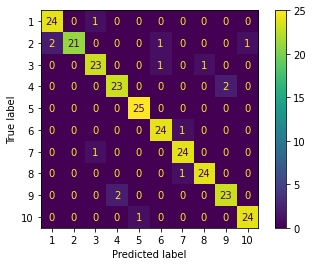

In [ ]:
_, y_true, y_preds = test_accuracy(test_path="data/test", returnPreds=True)
cm = confusion_matrix(y_true, y_preds, labels=[0, 1, 2, 3, 5, 6, 7, 8, 4, 9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
disp.plot()

As we can see, the model mainly gets 'i' and 'ii' or 'ix' and 'iv' confused, but there isn't a lot of data to support it. However, this was to be expected, since given unclear handwriting in most cases these are proably the pairs of labels that look most alike (so this result is somewhat intuitive). We will use augmentation to get a more accurate confusion matrix. (We use the same augmentation as before but we apply it on the first validation set which wasn't used for training the model)

In [ ]:
num_label_val = 1000
labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
seq = iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))),iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}),iaa.PerspectiveTransform(scale=(0.01, 0.12))])
for label in labels:
        images_val = os.listdir('data/test/'+label)
        times_augment = math.ceil(num_label_val/len(images_val))-1
        i = 0
        saved = 0
        for image_path in images_val:
            original = Image.open('data/test/'+label+'/'+image_path).convert("RGB")
            original_np = np.array(original)
            images = [original_np]*(times_augment)
            images_aug = seq(images=images)
            
            if (saved<num_label_val):
                original.save('data/val/'+label+'/'+str(i)+'.jpg')
                saved += 1
            i += 1
            for j in range(0, times_augment):
                if (saved<num_label_val):
                    im = Image.fromarray(np.uint8(images_aug[j]))
                    im.save('data/val/'+label+'/'+str(i)+'_'+str(j)+'.jpg')
                    saved += 1
            if saved == num_label_val:
                break

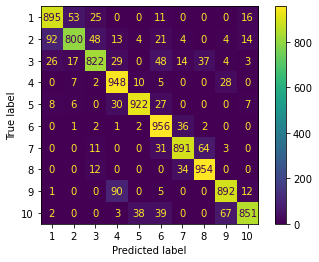

In [ ]:
_, y_true, y_preds = test_accuracy(test_path="data/val", returnPreds=True)  # val directory currently contains augmentations of test set, which the model wasn't train on
cm = confusion_matrix(y_true, y_preds, labels=[0, 1, 2, 3, 5, 6, 7, 8, 4, 9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
disp.plot()
delete_augs()

We get similar results as before, but we can see the model also mixes 'i', 'ii' and 'iii', 'vi' with 'vii', 'vii' with 'viii', and it sometimes classifes: 'x' as 'ix' / 'iii' as 'iv', 'vi' and 'viii' / 'x' as  'v' and 'vi'. This time however, we have more data to get slightly more sound conclusions with.

# Creating the Final Dataset

We use the augmentation method specified above to make a dataset with labels distributed uniformly, and as before we split each label to 0.8-0.2 between train and validation. We then train the ResNet on the dataset and save it. 

In [ ]:
# move validation, test and train to a single directory
labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
if not os.path.exists("data/complete"):
    os.mkdir("data/complete")
for direc in ["data/train_","data/test","data/val_","data/validation_first"]:
    for label in labels:
        if not os.path.exists("data/complete/"+label):
            os.mkdir("data/complete/"+label)
        images = os.listdir(direc+'/'+label)
        for image in images:
            shutil.copy(direc+'/'+label+'/'+image, "data/complete/"+label)

In [ ]:
# split to train and val
labels = ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']
for label in labels:
    files = glob.glob('data/train_/'+label+'/*')
    for f in files:
        os.remove(f)
for label in labels:
    files = glob.glob('data/val_/'+label+'/*')
    for f in files:
        os.remove(f)
move_train(path="data/val_", from_path="data/complete/" , move_size = 50)
move_train(path="data/train_", from_path="data/complete/" , move_size = 1)

In [ ]:
# use selected augmentation method to create train and validation sets. 
seq = iaa.Sequential([iaa.WithBrightnessChannels(iaa.Add((10, 80))),iaa.Affine(scale={"x": (1, 1.2), "y": (1, 1.5)}),iaa.PerspectiveTransform(scale=(0.01, 0.12))])
num_label_train = 800
num_label_val = 1000 - num_label_train
augment_train_val(seq, num_label_train, num_label_val)

Your working directory is:  /home/student/hw2
The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


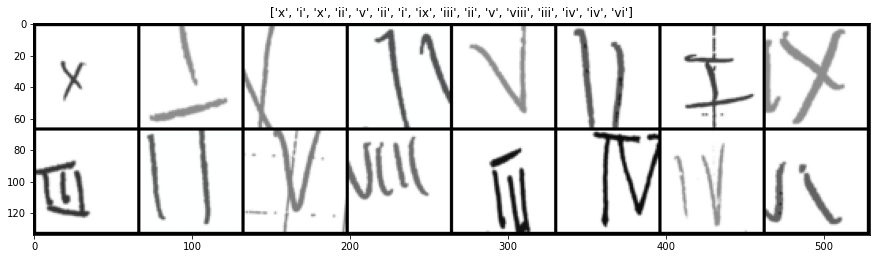

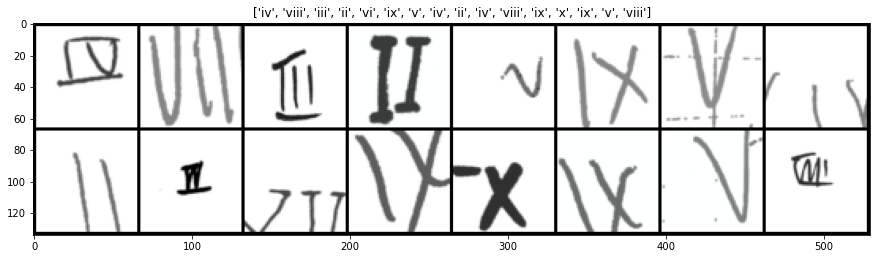

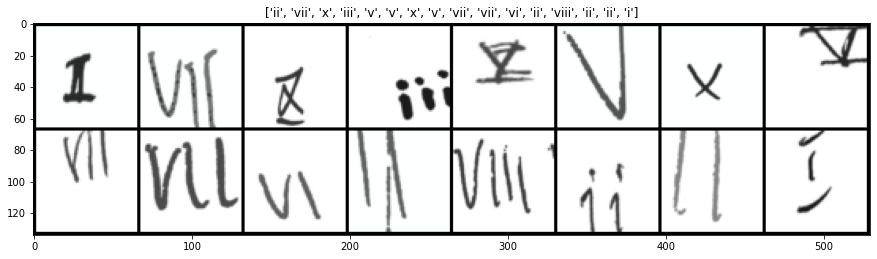

Epoch 1/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.60it/s]


train Loss: 1.6961 Acc: 0.4479


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.29it/s]


val Loss: 2.5178 Acc: 0.5965

Epoch 2/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.6826 Acc: 0.7756


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.31it/s]


val Loss: 0.6503 Acc: 0.7985

Epoch 3/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.4036 Acc: 0.8711


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.55it/s]


val Loss: 0.7367 Acc: 0.8090

Epoch 4/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.4018 Acc: 0.8744


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.37it/s]


val Loss: 0.7190 Acc: 0.7995

Epoch 5/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.36it/s]


train Loss: 0.2526 Acc: 0.9185


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.56it/s]


val Loss: 0.7319 Acc: 0.8020

Epoch 6/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0867 Acc: 0.9745


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.35it/s]


val Loss: 0.5435 Acc: 0.8680

Epoch 7/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0394 Acc: 0.9886


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.40it/s]


val Loss: 0.5670 Acc: 0.8700

Epoch 8/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0253 Acc: 0.9935


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.58it/s]


val Loss: 0.5938 Acc: 0.8790

Epoch 9/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0219 Acc: 0.9939


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.43it/s]


val Loss: 0.6422 Acc: 0.8780

Epoch 10/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0188 Acc: 0.9949


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.43it/s]


val Loss: 0.6660 Acc: 0.8770

Epoch 11/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0103 Acc: 0.9974


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.43it/s]


val Loss: 0.6495 Acc: 0.8815

Epoch 12/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0089 Acc: 0.9980


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.29it/s]


val Loss: 0.6714 Acc: 0.8805

Epoch 13/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0074 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.46it/s]


val Loss: 0.6540 Acc: 0.8820

Epoch 14/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0076 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.60it/s]


val Loss: 0.6837 Acc: 0.8810

Epoch 15/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0060 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.50it/s]


val Loss: 0.6839 Acc: 0.8790

Epoch 16/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0048 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.64it/s]


val Loss: 0.6913 Acc: 0.8810

Epoch 17/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0050 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.54it/s]


val Loss: 0.6863 Acc: 0.8785

Epoch 18/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0046 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.54it/s]


val Loss: 0.6707 Acc: 0.8805

Epoch 19/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0053 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.57it/s]


val Loss: 0.6760 Acc: 0.8780

Epoch 20/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0045 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.49it/s]


val Loss: 0.6857 Acc: 0.8780

Epoch 21/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0044 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.59it/s]


val Loss: 0.6827 Acc: 0.8775

Epoch 22/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0044 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.60it/s]


val Loss: 0.6878 Acc: 0.8780

Epoch 23/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0035 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.44it/s]


val Loss: 0.6882 Acc: 0.8790

Epoch 24/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0047 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.25it/s]


val Loss: 0.6802 Acc: 0.8800

Epoch 25/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0040 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.58it/s]


val Loss: 0.6908 Acc: 0.8785

Epoch 26/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0045 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.44it/s]


val Loss: 0.6927 Acc: 0.8795

Epoch 27/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.36it/s]


train Loss: 0.0045 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.57it/s]


val Loss: 0.6954 Acc: 0.8790

Epoch 28/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0045 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.75it/s]


val Loss: 0.6892 Acc: 0.8800

Epoch 29/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0045 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.50it/s]


val Loss: 0.6935 Acc: 0.8800

Epoch 30/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0042 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.67it/s]


val Loss: 0.6753 Acc: 0.8785

Epoch 31/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0043 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.46it/s]


val Loss: 0.6899 Acc: 0.8785

Epoch 32/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0042 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.58it/s]


val Loss: 0.6819 Acc: 0.8780

Epoch 33/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0045 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.73it/s]


val Loss: 0.6865 Acc: 0.8795

Epoch 34/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0038 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.60it/s]


val Loss: 0.6767 Acc: 0.8825

Epoch 35/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0042 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.62it/s]


val Loss: 0.6968 Acc: 0.8785

Epoch 36/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0053 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.52it/s]


val Loss: 0.6791 Acc: 0.8795

Epoch 37/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0042 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.48it/s]


val Loss: 0.6883 Acc: 0.8805

Epoch 38/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0043 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.72it/s]


val Loss: 0.6716 Acc: 0.8790

Epoch 39/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0051 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.56it/s]


val Loss: 0.6879 Acc: 0.8800

Epoch 40/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0045 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.49it/s]


val Loss: 0.6822 Acc: 0.8795

Epoch 41/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0052 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.53it/s]


val Loss: 0.6829 Acc: 0.8790

Epoch 42/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0041 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.51it/s]


val Loss: 0.6892 Acc: 0.8790

Epoch 43/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0047 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.71it/s]


val Loss: 0.6827 Acc: 0.8800

Epoch 44/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0046 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.64it/s]


val Loss: 0.6872 Acc: 0.8795

Epoch 45/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0058 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.52it/s]


val Loss: 0.6871 Acc: 0.8790

Epoch 46/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0050 Acc: 0.9986


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.72it/s]


val Loss: 0.6784 Acc: 0.8815

Epoch 47/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.43it/s]


train Loss: 0.0046 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.33it/s]


val Loss: 0.6990 Acc: 0.8780

Epoch 48/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.44it/s]


train Loss: 0.0046 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.60it/s]


val Loss: 0.6855 Acc: 0.8805

Epoch 49/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0046 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.63it/s]


val Loss: 0.7016 Acc: 0.8795

Epoch 50/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0058 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.80it/s]


val Loss: 0.6842 Acc: 0.8775

Epoch 51/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0047 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.50it/s]


val Loss: 0.6833 Acc: 0.8820

Epoch 52/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0045 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.78it/s]


val Loss: 0.6924 Acc: 0.8810

Epoch 53/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0037 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.74it/s]


val Loss: 0.6834 Acc: 0.8790

Epoch 54/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0042 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.55it/s]


val Loss: 0.6888 Acc: 0.8785

Epoch 55/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0043 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.72it/s]


val Loss: 0.6907 Acc: 0.8790

Epoch 56/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0050 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.64it/s]


val Loss: 0.6994 Acc: 0.8790

Epoch 57/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0043 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.46it/s]


val Loss: 0.6902 Acc: 0.8795

Epoch 58/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0057 Acc: 0.9985


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.29it/s]


val Loss: 0.7053 Acc: 0.8785

Epoch 59/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0058 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.82it/s]


val Loss: 0.6950 Acc: 0.8775

Epoch 60/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0041 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.70it/s]


val Loss: 0.6814 Acc: 0.8790

Epoch 61/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.41it/s]


train Loss: 0.0048 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.74it/s]


val Loss: 0.6972 Acc: 0.8775

Epoch 62/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.43it/s]


train Loss: 0.0045 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.53it/s]


val Loss: 0.6866 Acc: 0.8790

Epoch 63/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.43it/s]


train Loss: 0.0040 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.52it/s]


val Loss: 0.6961 Acc: 0.8810

Epoch 64/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0046 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.68it/s]


val Loss: 0.6941 Acc: 0.8810

Epoch 65/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.42it/s]


train Loss: 0.0043 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.72it/s]


val Loss: 0.6844 Acc: 0.8780

Epoch 66/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0042 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.61it/s]


val Loss: 0.6866 Acc: 0.8795

Epoch 67/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0049 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.67it/s]


val Loss: 0.6915 Acc: 0.8795

Epoch 68/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0050 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.59it/s]


val Loss: 0.6817 Acc: 0.8800

Epoch 69/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.35it/s]


train Loss: 0.0043 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 23.99it/s]


val Loss: 0.6757 Acc: 0.8825

Epoch 70/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0039 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.27it/s]


val Loss: 0.6918 Acc: 0.8795

Epoch 71/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.36it/s]


train Loss: 0.0043 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.64it/s]


val Loss: 0.6940 Acc: 0.8790

Epoch 72/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0045 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.64it/s]


val Loss: 0.6914 Acc: 0.8815

Epoch 73/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.31it/s]


train Loss: 0.0037 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.53it/s]


val Loss: 0.6776 Acc: 0.8805

Epoch 74/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s]


train Loss: 0.0053 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.24it/s]


val Loss: 0.6882 Acc: 0.8805

Epoch 75/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0045 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.39it/s]


val Loss: 0.7037 Acc: 0.8785

Epoch 76/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.27it/s]


train Loss: 0.0049 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.66it/s]


val Loss: 0.7028 Acc: 0.8780

Epoch 77/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0039 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.45it/s]


val Loss: 0.6962 Acc: 0.8805

Epoch 78/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0037 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.68it/s]


val Loss: 0.7044 Acc: 0.8795

Epoch 79/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


train Loss: 0.0042 Acc: 0.9995


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.25it/s]


val Loss: 0.6861 Acc: 0.8775

Epoch 80/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0050 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.55it/s]


val Loss: 0.6928 Acc: 0.8770

Epoch 81/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


train Loss: 0.0046 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.75it/s]


val Loss: 0.6804 Acc: 0.8790

Epoch 82/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0037 Acc: 0.9998


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.45it/s]


val Loss: 0.6882 Acc: 0.8785

Epoch 83/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0043 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.73it/s]


val Loss: 0.6883 Acc: 0.8790

Epoch 84/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.38it/s]


train Loss: 0.0046 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.61it/s]


val Loss: 0.6801 Acc: 0.8800

Epoch 85/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0053 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.99it/s]


val Loss: 0.7255 Acc: 0.8805

Epoch 86/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0044 Acc: 0.9996


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.47it/s]


val Loss: 0.6904 Acc: 0.8810

Epoch 87/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


train Loss: 0.0046 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.10it/s]


val Loss: 0.6968 Acc: 0.8795

Epoch 88/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.28it/s]


train Loss: 0.0043 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.66it/s]


val Loss: 0.6881 Acc: 0.8800

Epoch 89/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.32it/s]


train Loss: 0.0049 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.77it/s]


val Loss: 0.6789 Acc: 0.8780

Epoch 90/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.34it/s]


train Loss: 0.0046 Acc: 0.9991


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.73it/s]


val Loss: 0.6787 Acc: 0.8810

Epoch 91/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0042 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.22it/s]


val Loss: 0.6808 Acc: 0.8800

Epoch 92/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0040 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.37it/s]


val Loss: 0.6994 Acc: 0.8770

Epoch 93/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.15it/s]


train Loss: 0.0051 Acc: 0.9989


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.69it/s]


val Loss: 0.6888 Acc: 0.8785

Epoch 94/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0046 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.73it/s]


val Loss: 0.6977 Acc: 0.8790

Epoch 95/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.37it/s]


train Loss: 0.0051 Acc: 0.9988


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.66it/s]


val Loss: 0.6903 Acc: 0.8785

Epoch 96/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.39it/s]


train Loss: 0.0045 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.34it/s]


val Loss: 0.6815 Acc: 0.8815

Epoch 97/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.36it/s]


train Loss: 0.0049 Acc: 0.9990


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 24.45it/s]


val Loss: 0.6972 Acc: 0.8795

Epoch 98/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.24it/s]


train Loss: 0.0042 Acc: 0.9999


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.40it/s]


val Loss: 0.6941 Acc: 0.8800

Epoch 99/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.33it/s]


train Loss: 0.0047 Acc: 0.9992


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.49it/s]


val Loss: 0.6930 Acc: 0.8790

Epoch 100/100
----------


100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.36it/s]


train Loss: 0.0044 Acc: 0.9994


100%|███████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 25.64it/s]


val Loss: 0.6958 Acc: 0.8785

Training complete in 81m 35s
Best val Acc: 0.882500


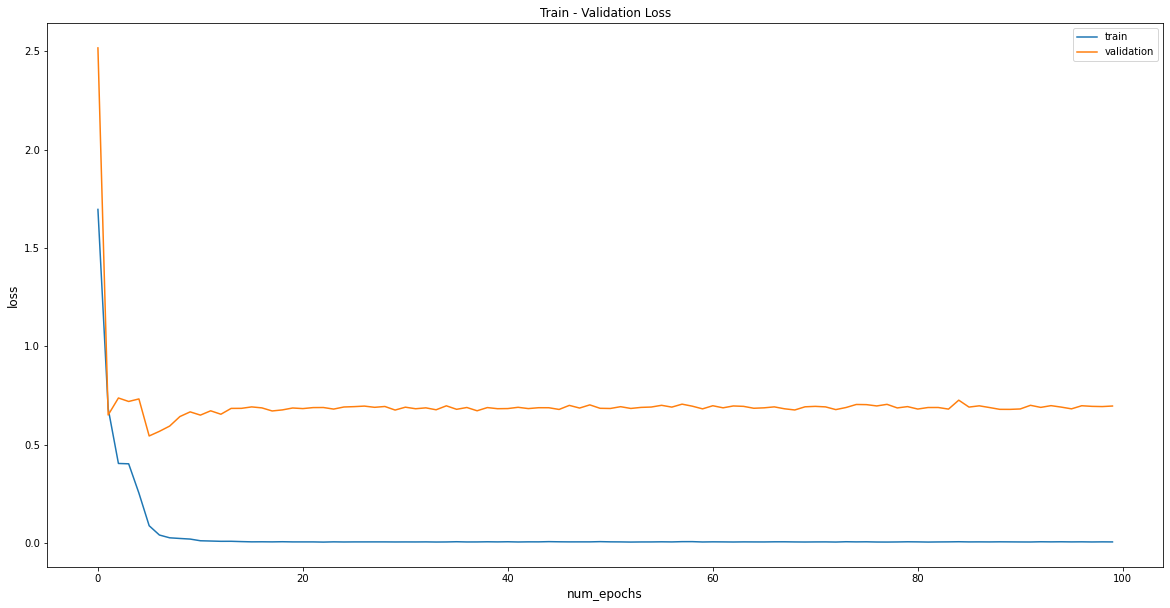

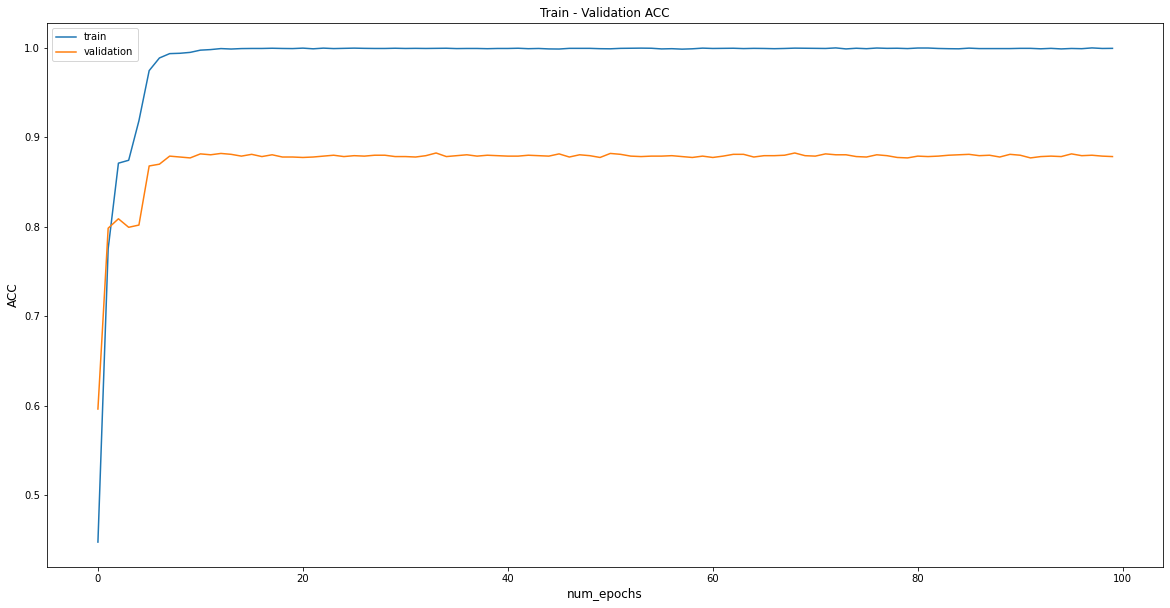

In [ ]:
# train final model
%run run_train_eval.py

### Conclusions

- During our work we had the chance to see how important it is to build a good dataset for ML tasks. We got to feel why gathering / creating a good dataset is such a significant step in building a well-performing models. Moreover, we got a good feeling of the crucial importance specifically of this aspect of ML, since our entire focus was directed towards it, and we didn't have to make our own model. This allowed us to really explore the specific differences throughout various experiments of data augmentation.
- Data augmentation was our main method for creating the new dataset. Even though it relies on images that are originally in our training set, it had a great impact on the model's performance. This is likely because of a few reasons:
    - Augmentation greatly increases the amount of data to learn from, which is a rule of thumb for better performance.
    - Augmentation makes for more varied images due to changes and distortions it makes in the data, usually helping to avoid overfitting.
    - Empirically, augmentation is a recommended and frequently used method in ML and DL for improving training results.
- The best types of augmentation for this task were Brightness, Affine, and PerspectiveTransform. This is likely since these were the ones that best simulated variance in real handwriting. However, we do note that there are other types of augmentation that can be applied to images that we have not tried due to time constraints, which could very well change our results for better or worse. In choosing our types of augmentations to experiment with, we usually went for augmentation types that we were already familiar with or that intuitively seemed to get us varied kinds of images based on their description.
- Using varied sizes of train-validation sets did not give as significant improvements as different combinations of augmentations, but it did give us an indication of the split size that would likely be good to use. We think that the fact that the 80-20 split got the best results makes sense because there is a big amount of data to learn from, but the test set is not too small to be unrepresentative of real world data.
- The final results on the test set that was unseen by the model through the entire process were satisying (94% accuracy), and we have managed to significantly improve the performance of the model on the original data. We have created it to test our best and final model, to hopefully get a (very) rough indication of how to model would perform on the hidden test set, and also to simulate real-life model training practices. Because of this, this test set was only used once throughout the entire process of this task.